In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter
from qutip import entropy_vn, concurrence
from jax import jit, value_and_grad
import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *
import os
import pickle
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

global_cache_data_digital = None
global_processed_files_digital = None

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [18]:
import os
import pickle
import re
import numpy as np
from pathlib import Path


def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                # Attempt to load the pickle file
                df = pickle.load(f)
                
            return True
        else:
            return False
    except EOFError:
        return False
def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0
def read_jax_file(file_path, gate_name):
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        df = clean_array(df)
        costs = np.asarray([float(i) for i in df['costs'][0]], dtype=np.float64)
        grads_per_epoch = [np.asarray(i, dtype=np.float64) for i in df['grads_per_epoch'][0]]

        fidelity =df['avg_fidelity'][0]
        num_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
        try:
            test_results =  np.asarray(df['fidelities'][0], dtype=np.float64)
        except KeyError:
            
            test_results =  np.asarray(df['testing_results'][0], dtype=np.float64)
        num_epochs = df['epochs'][0]
        return costs, fidelity, num_params, test_results,grads_per_epoch
def clean_array(data):
    """Helper function to clean any deprecated JAX arrays."""
    if isinstance(data, np.ndarray):
        return np.array(data)  # Ensure the array doesn't have deprecated attributes
    elif isinstance(data, dict):
        return {k: clean_array(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_array(v) for v in data]
    else:
        return data
    
def get_cached_data_once_digital(base_path):
    """Load cached data only once and keep it in memory for future runs for the digital model."""
    global global_cache_data_digital, global_processed_files_digital

    # If the cache has already been loaded, skip re-loading
    if global_cache_data_digital is not None and global_processed_files_digital is not None:
        return global_cache_data_digital, global_processed_files_digital

    # Load the cache from disk (only happens once)
    cache_file = os.path.join(base_path, 'cached_results.pkl')
    if os.path.exists(cache_file):
        if os.stat(cache_file).st_size == 0:
            print(f"[ERROR] Cache file {cache_file} is empty. Returning empty cache.")
            global_cache_data_digital = {}
            global_processed_files_digital = set()
            return global_cache_data_digital, global_processed_files_digital

        try:
            with open(cache_file, 'rb') as f:
                global_cache_data_digital, global_processed_files_digital = pickle.load(f)
            global_cache_data_digital = clean_array(global_cache_data_digital)

            # Filter the cache to only include files from the correct base path
            global_processed_files_digital = set(
                file for file in global_processed_files_digital if file.startswith(base_path)
            )
            return global_cache_data_digital, global_processed_files_digital
        except (EOFError, pickle.UnpicklingError) as e:
            print(f"[ERROR] Failed to load cache file {cache_file}: {e}")
            global_cache_data_digital = {}
            global_processed_files_digital = set()
            return global_cache_data_digital, global_processed_files_digital
    else:
        print(f"[INFO] Cache file {cache_file} does not exist. Creating empty cache.")
        global_cache_data_digital = {}
        global_processed_files_digital = set()
        return global_cache_data_digital, global_processed_files_digital

def clean_cached_data_with_missing_paths(cached_data):
    """
    Remove entries from the cached data where 'path' is None.
    """
    for N_ctrl, gates in cached_data.items():
        for gate, reservoirs in gates.items():
            for reservoir_count, trotter_steps in reservoirs.items():
                for trotter_step, data_points in trotter_steps.items():
                    valid_data_points = [dp for dp in data_points if dp.get('path') is not None]
                    cached_data[N_ctrl][gate][reservoir_count][trotter_step] = valid_data_points
    return cached_data


def retrofit_cached_data_with_path(base_path, cached_data):
    """
    Adds the 'path' key to cached data if it doesn't exist.
    """
    for N_ctrl, gates in cached_data.items():
        for gate, reservoirs in gates.items():
            for reservoir_count, trotter_steps in reservoirs.items():
                for trotter_step, data_points in trotter_steps.items():
                    for data_point in data_points:
                        if 'path' not in data_point:
                            # Attempt to reconstruct the file path
                            trotter_path = os.path.join(
                                base_path,
                                gate,
                                f"reservoirs_{reservoir_count}",
                                f"trotter_step_{trotter_step}",
                            )
                            # Example logic: Assume file names can be inferred from 'run' key
                            if 'run' in data_point:
                                file_name = f"{data_point['run']}.pickle"
                                file_path = os.path.join(trotter_path, file_name)
                                if os.path.exists(file_path):
                                    data_point['path'] = file_path
                                else:
                                    data_point['path'] = None  # Mark as unknown if file is missing
                            else:
                                data_point['path'] = None  # Mark as unknown if 'run' is missing
    return cached_data

def save_cached_data(base_path, cached_data, processed_files):
    """Save cached data and list of processed files to cache stored in the base_path."""
    cache_file = os.path.join(base_path, f'cached_results.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)
def update_cache_with_new_data(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Update cache with new key/values without reprocessing already processed files."""
    print(f"Processing for N_ctrl = {N_ctrl}")
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name

                for bath_status in ['bath_True', 'bath_False/']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            if reservoir_count not in reservoir_counts:
                                continue

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    if trotter_step not in trots:
                                        continue

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)

                                    # Count data runs already in cache
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    num_data_runs = len(cached_trotter_data)

                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.join(trotter_path, file)
                                            
                                            # Normalize the file path to ensure consistency in checking
                                            pickle_file = os.path.normpath(pickle_file)

                                            # Extract just the data_run_<i> part from the file name
                                            run = os.path.basename(pickle_file).replace('.pickle', '')

                                            # Check if the file has already been processed
                                            if pickle_file in processed_files:
                                                # Update the run field in cached data if missing
                                                for cached_result in cached_trotter_data:
                                                    if 'run' not in cached_result or 'gate' not in cached_result or cached_result['path'] != pickle_file:
                                                        cached_result['run'] = run
                                                        cached_result['gate'] = gate
                                                # print(f"Data missing from")
                                                continue

                                            # Process new file
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                costs, fidelity, num_params, test_results, grads_per_epoch = read_jax_file(pickle_file, gate)
                                                
                                                

                                                # Store the new data point
                                                if gate not in cached_data[N_ctrl]:
                                                    cached_data[N_ctrl][gate] = {}
                                                if reservoir_count not in cached_data[N_ctrl][gate]:
                                                    cached_data[N_ctrl][gate][reservoir_count] = {}
                                                if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                                    cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                     
                                                
                                                num_data_runs += 1  # Increment the number of data runs
                                                # Extract just the data_run_<i> part from the file name
                                                run = os.path.basename(pickle_file).replace('.pickle', '')

                                                # Prepare the new data point
                                                data_point = {
                                                    'costs': costs,
                                                    'gate': gate,
                                                    'fidelity': fidelity,
                                                    'test_results': test_results,
                                                    'param_count': num_params,
                                                    'run': run,  # Store the data_run_<i> value
                                                    'num_data_runs': num_data_runs,
                                                    'grads_per_epoch':grads_per_epoch,
                                                    # 'selected_indices':selected_indices
                                                }

                                                # Append the new data point to the cache
                                                cached_data[N_ctrl][gate][reservoir_count][trotter_step].append(data_point)


                                                
                                                processed_files.add(pickle_file)  # Mark file as processed

    print(f"Cache updated for N_ctrl={N_ctrl}")
    return cached_data, processed_files
def process_new_files_digital(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Process new files that haven't been processed before, and update cache with the best fidelity."""
    print(f"Processing for N_ctrl = {N_ctrl}")
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name

                # Ensure that N_ctrl is a top-level key in the cache
                if N_ctrl not in cached_data:
                    cached_data[N_ctrl] = {}

                for bath_status in ['bath_True', 'bath_False/']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                        

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)
                                    current_best_fidelity = float('-inf')  # Set initial best fidelity as lowest possible value
                                    current_best_data_point = None
                                    num_data_runs = 0

                                    # Check if there's already cached data for this trotter step
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    missing_paths = 0  # Counter for entries with missing paths

                                    # Retrofit 'path' for cached data if missing
                                    for data_point in cached_trotter_data:
                                        if 'path' not in data_point or data_point['path'] is None:
                                            run = data_point.get('run', None)
                                            if run:
                                                potential_file_path = os.path.join(trotter_path, f"{run}.pickle")
                                                if not potential_file_path.startswith('/Users/sophieblock/QRCCapstone/digital_results_trainable_global/trainsize_20_optimized_by_cost3/'):
                                                    print(f"Incorrect filepath: {potential_file_path}")
                                                
                                                if os.path.exists(potential_file_path):
                                                    data_point['path'] = potential_file_path
                                                else:
                                                    missing_paths += 1
                                        # else:
                                        #     files_to_check = [
                                        #             file for file in processed_files 
                                        #             if not file.startswith('/Users/sophieblock/QRCCapstone/digital_results_trainable_global/trainsize_20_optimized_by_cost3/')
                                        #         ]

                                        #     if files_to_check:
                                        #         print("Files found matching the criteria:")
                                        #         for file in files_to_check:
                                        #             print(file)
                                        #     else:
                                        #         print("No files found matching the criteria.")

                                        #     print(f"Path apparently found")
                                    # if cached_trotter_data:
                                    #     current_best_data_point = cached_trotter_data[0]  # Assuming one best result per trotter step
                                    #     current_best_fidelity = np.mean(current_best_data_point['fidelity'])
                                    #     num_data_runs = current_best_data_point.get('num_data_runs', 0)
                                    if missing_paths > 0:
                                        print(
                                            f"[WARNING] {missing_paths} data points missing files for "
                                            f"N_C={N_ctrl}, N_R={reservoir_count}, T={trotter_step}"
                                        )
                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.join(trotter_path, file)
                                            
                                            # Normalize the file path to ensure consistency in checking
                                            pickle_file = os.path.normpath(pickle_file)

                                            # Ensure the file belongs to the correct base path
                                            # if not pickle_file.startswith(base_path):
                                            #     continue

                                            # Check if the file has been processed before
                                            if pickle_file not in processed_files and is_valid_pickle_file(Path(pickle_file)):
                                                # Process the file and find the fidelity
                                                costs, fidelity, num_params, test_results, grads_per_epoch = read_jax_file(pickle_file, gate)
                                                
                                                num_data_runs += 1  # Increment the number of data runs
                                                run = os.path.basename(pickle_file).replace('.pickle', '')

                                                # Check if this new file has a better fidelity
                                                if fidelity > current_best_fidelity:
                                                    current_best_fidelity = fidelity
                                                    current_best_data_point = {
                                                        'costs': costs,
                                                        'gate': gate,
                                                        'fidelity': fidelity,
                                                        'test_results': test_results,
                                                        'param_count': num_params,
                                                        'run': run,
                                                        'num_data_runs': num_data_runs,
                                                        'grads_per_epoch': grads_per_epoch,
                                                        'path': pickle_file,  # Add path here
                                                    }
                                                processed_files.add(pickle_file)


                                    # If we found a valid data point with better fidelity, cache it
                                    if current_best_data_point:
                                        if gate not in cached_data[N_ctrl]:
                                            cached_data[N_ctrl][gate] = {}
                                        if reservoir_count not in cached_data[N_ctrl][gate]:
                                            cached_data[N_ctrl][gate][reservoir_count] = {}
                                        if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                            cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                        # Replace the cached data with the new best data point
                                        cached_data[N_ctrl][gate][reservoir_count][trotter_step] = [current_best_data_point]
                                        # processed_files.add(pickle_file)  # Mark file as processed

    return cached_data, processed_files

# Initialization and execution
N_ctrls = [1,2,3]
num_train = 20
reservoir_counts = [1,2,3,4,5,6,7,8,9,10]
# reservoir_counts = [1,2,3,4,5,6,7,8,9]
processed_files_global_digital = set()
base_path = f'/Users/sophieblock/QRCCapstone/digital_results_trainable_global/trainsize_{num_train}_no_hypertraining/'

cached_data, processed_files = get_cached_data_once_digital(base_path)

# # Retrofit with 'path' key
# cached_data = retrofit_cached_data_with_path(base_path, cached_data)

# # Save the retrofitted cache
# save_cached_data(base_path, cached_data, processed_files)


# cached_data, processed_files = {},set()
# Update the processed files set globally for digital
# processed_files.update(processed_files_global_digital)
for N_ctrl in N_ctrls:
    
    gate_prefixes = [f'U{N_ctrl}']
    


    trots = np.arange(1, 54, 1)

    # Process files and update the cache
    cached_data, processed_files = process_new_files_digital(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl)
    # cached_data, processed_files = update_cache_with_new_data(
    #     base_path, gate_prefixes, reservoir_counts, trots, 
    #     cached_data, processed_files, N_ctrl
    # )
    # cached_data, processed_files = process_new_files_digital(
    #     base_path, gate_prefixes, reservoir_counts, trots, 
    #     cached_data, processed_files, N_ctrl
    # )
    
    save_cached_data(base_path, cached_data, processed_files)
    processed_files_global_digital.update(processed_files)

Processing for N_ctrl = 1
Processing for N_ctrl = 2
Processing for N_ctrl = 3


In [11]:
import numpy as np
import pandas as pd

N_ctrls = [2]
rows = []  # List to hold rows temporarily
negative_fidelity_values = []
global_min_error = 100
for N_ctrl in N_ctrls:
    data_i = cached_data[N_ctrl]

    for gate, gate_data in data_i.items():
        for reservoir_count, res_data in gate_data.items():
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    avg_fidelity = results.get('fidelity', np.nan)
                    std_fidelity = np.nanstd(results.get('test_results', []))
                    
                    if pd.isna(avg_fidelity):
                        raise ValueError(
                            f"NaN detected in avg_fidelity! Gate: {gate}, N_C: {N_ctrl}, "
                            f"N_R: {reservoir_count}, Trotter_Step: {trotter_step}, Run: {results.get('run', None)}"
                        )

                    log_infidelities = []
                    infidelities, fidelities = [], []
                    num_clipped = {}
                    all_og_fidelities = {}

                    # Get test results
                    test_results = results.get('test_results', [])
                    optimal_min_error = None
                    optimal_jitter_scale = None

                    # Step 1: Determine min_error and jitter_scale dynamically
                    non_clipped_fidelities = []
                    for fidelity in test_results:
                        if fidelity >= 1.0 or fidelity <= 0:
                            continue  # Skip clearly invalid values
                        non_clipped_fidelities.append(fidelity)

                    if non_clipped_fidelities:
                        sorted_non_clipped_fidelities = sorted(non_clipped_fidelities)
                        
                        n = len(sorted_non_clipped_fidelities)
                        std_dev = np.std(sorted_non_clipped_fidelities)
                        std_err = std_dev / np.sqrt(n) if n > 1 else global_min_error
                        optimal_min_error = 1.0 - sorted_non_clipped_fidelities[-1]  # Largest valid infidelity
                        if global_min_error > optimal_min_error:
                            # print(f"\nNEW GLOBAL MIN: {global_min_error}")

                            
                            global_min_error = max(1e-16, optimal_min_error)
                            # print(f"\nNEW GLOBAL MIN: {global_min_error}")
                        optimal_jitter_scale = std_dev/2 if std_dev/2 < optimal_min_error else optimal_min_error
                        
                        # if N_ctrl == 1 and trotter_step == 13 and reservoir_count ==1:
                        #     print(f"\nGate: {gate}, avg fidel: {results.get('test_results', [])}")
                        #     print(f"Optimal Min Error: {optimal_min_error:.2e}")
                        #     print(f"Standard Error / {n}: {std_err:.2e}")
                        #     print(f"Standard Deviation / 2: {std_dev / 2:.2e}")
                    else:
                        optimal_min_error = global_min_error
                        optimal_jitter_scale = global_min_error

                    clipped_count = 0

                    # Step 2: Process each fidelity in 'Test Results' with determined min_error and jitter_scale
                    for i, fidelity in enumerate(test_results):
                        
                        
                        all_og_fidelities[i] = fidelity
                        infidelity = 1.0 - fidelity

                        if infidelity <= 0:
                            # Numerical error, apply clipping with dynamically determined values
                            clipped_count += 1
                            jitter = np.random.uniform(-optimal_jitter_scale, optimal_jitter_scale)
                            num_clipped[i] = {'fidelity': fidelity, 'jit': jitter}
                            infidelity = optimal_min_error + jitter
                            assert infidelity > 0, f"Adjusted infidelity is non-positive. Index: {i}, min error: {optimal_min_error} Jitter: {optimal_jitter_scale}. {num_clipped[i]}"
                            fidelity = 1.0 - infidelity

                        infidelities.append(infidelity)
                        fidelities.append(fidelity)
                        log_infidelities.append(np.log10(infidelity))

                    # Step 3: Add results to the row
                    avg_fidelity = np.mean(fidelities)
                    avg_infidelity = np.mean(infidelities)

                    row = {
                        'N_C': int(N_ctrl),
                        'Trotter_Step': int(trotter_step),
                        'Gate': results['gate'],
                        'Reservoir Count': int(reservoir_count),
                        'Avg_Fidelity': avg_fidelity,
                        'std_fidelity': std_fidelity,
                        'Avg_infidelity': avg_infidelity,
                        'var_infid': np.var(infidelities),
                        'Error_Test_Results': log_infidelities,
                        'Avg Error': np.nanmean(log_infidelities) if log_infidelities else np.nan,
                        'infidelities': infidelities,
                        'Costs': results.get('costs', []),
                        'Test Results': test_results,
                        'N_params': results.get('param_count', np.nan),
                        'run': results.get('run', None),
                        'indices_clipped': num_clipped,
                        'all_og': all_og_fidelities,
                        'Optimal_min_error': optimal_min_error,
                        'Optimal_jitter_scale': optimal_jitter_scale,
                    }

                    rows.append(row)

# Create DataFrame from rows
all_data_df = pd.DataFrame(rows)

# Final validation of the DataFrame
invalid_infidelity = all_data_df[(all_data_df['Avg_infidelity'] <= 0) | (all_data_df['Avg_infidelity'].isna())]
if not invalid_infidelity.empty:
    print(f"Invalid values found in 'Avg_infidelity': {len(invalid_infidelity)} rows.")
    raise ValueError("Invalid 'Avg_infidelity' detected in the dataset.")
else:
    print("All 'Avg_infidelity' values are valid.")

# Print a preview of the DataFrame
print(all_data_df[['Gate', 'Optimal_min_error', 'Optimal_jitter_scale']].head())

All 'Avg_infidelity' values are valid.
   Gate  Optimal_min_error  Optimal_jitter_scale
0  U2_0           0.212033              0.076903
1  U2_0           0.083848              0.069639
2  U2_0           0.052479              0.050692
3  U2_0           0.023287              0.023287
4  U2_0           0.015791              0.014543


#### <b> More aggressive clipping</b>

In [19]:
min_error = 1e-10
N_ctrls = [2]
rows = []  # List to hold rows temporarily
negative_fidelity_values = []
jitter_results = False
for N_ctrl in N_ctrls:
    data_i = cached_data[N_ctrl]

    previous_valid_results = {}

    # Inside the loop where results are processed
    for gate, gate_data in data_i.items():
        for reservoir_count, res_data in gate_data.items():
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    avg_fidelity = results.get('fidelity', np.nan)
                    std_fidelity = np.nanstd(results.get('test_results', []))

                    if pd.isna(avg_fidelity):
                        raise ValueError(
                            f"NaN detected in avg_fidelity! Gate: {gate}, N_C: {N_ctrl}, "
                            f"N_R: {reservoir_count}, Trotter_Step: {trotter_step}, Run: {results.get('run', None)}"
                        )

                    log_infidelities,ln_infidelities = [],[]
                    infidelities, fidelities = [], []
                    num_clipped = {}
                    all_og_fidelities = {}

                    # Get test results
                    test_results = results.get('test_results', [])
                    optimal_min_error = None
                    optimal_jitter_scale = None

                    # Define key for the current configuration
                    key = (N_ctrl, reservoir_count, trotter_step)

                    # Step 1: Determine min_error and jitter_scale dynamically
                    non_clipped_fidelities = [
                        fidelity for fidelity in test_results if 0 < fidelity < 1.0
                    ]

                    if non_clipped_fidelities:
                        # Use the largest infidelity (smallest fidelity)
                        sorted_non_clipped_fidelities = sorted(non_clipped_fidelities)
                        optimal_min_error = max(min_error, 1.0 - sorted_non_clipped_fidelities[-1])
                        optimal_jitter_scale = (
                            min(
                                optimal_min_error,
                                np.std(sorted_non_clipped_fidelities),
                            )
                            if len(sorted_non_clipped_fidelities) > 1 and np.std(sorted_non_clipped_fidelities) != 0
                            else optimal_min_error
                        )
                        # Store valid results for the current key
                        previous_valid_results.setdefault(key, []).extend(
                            non_clipped_fidelities
                        )
                    elif key in previous_valid_results:
                        # Use the average of previous valid results for the same key
                        optimal_min_error = max(
                            min_error, 1.0 - np.mean(previous_valid_results[key])
                        )
                        optimal_jitter_scale = optimal_min_error
                    else:
                        # Default to machine precision as the fallback
                        optimal_min_error = min_error
                        optimal_jitter_scale = optimal_min_error

                    clipped_count = 0

                    # Step 2: Process each fidelity in 'Test Results' with determined min_error and jitter_scale
                    for i, fidelity in enumerate(test_results):
                        all_og_fidelities[i] = fidelity
                        infidelity = 1.0 - fidelity

                        if infidelity <= min_error:
                            # Numerical error, apply clipping with dynamically determined values
                            # clipped_count += 1
                            # jitter = np.random.uniform(
                            #     -optimal_jitter_scale, 0.0
                            # )
                            # num_clipped[i] = {"fidelity": fidelity, "jit": jitter}
                            if jitter_results:
                                infidelity = np.random.uniform(optimal_min_error*.2,optimal_min_error*5)
                            else:
                                infidelity = optimal_min_error
                            assert (
                                infidelity > 0
                            ), f"Adjusted infidelity is non-positive. Index: {i}, min error: {optimal_min_error} infidelity: {infidelity} Jitter: {jitter}"
                            fidelity = 1.0 - infidelity

                        infidelities.append(infidelity)
                        fidelities.append(fidelity)
                        log_infidelities.append(np.log10(infidelity))
                        ln_infidelities.append(np.log(infidelity))

                    # Step 3: Add results to the row
                    avg_fidelity = np.mean(fidelities)
                    avg_infidelity = np.mean(infidelities)

                    row = {
                        "N_C": int(N_ctrl),
                        "Trotter_Step": int(trotter_step),
                        "Gate": results["gate"],
                        "Reservoir Count": int(reservoir_count),
                        "Avg_Fidelity": avg_fidelity,
                        "std_fidelity": std_fidelity,
                        "Avg_infidelity": avg_infidelity,
                        "var_infid": np.var(infidelities),
                        "Error_Test_Results": log_infidelities,
                        "Avg Error": np.nanmean(log_infidelities),
                        "Avg_ln": np.nanmean(ln_infidelities),
                        "infidelities": infidelities,
                        "Costs": results.get("costs", []),
                        "Test Results": test_results,
                        "N_params": results.get("param_count", np.nan),
                        "run": results.get("run", None),
                        "indices_clipped": num_clipped,
                        "all_og": all_og_fidelities,
                        "Optimal_min_error": optimal_min_error,
                        "Optimal_jitter_scale": optimal_jitter_scale,
                    }

                    rows.append(row)

# Create DataFrame from rows
all_data_df = pd.DataFrame(rows)

# Final validation of the DataFrame
invalid_infidelity = all_data_df[(all_data_df['Avg_infidelity'] <= 0) | (all_data_df['Avg_infidelity'].isna())]
if not invalid_infidelity.empty:
    print(f"Invalid values found in 'Avg_infidelity': {len(invalid_infidelity)} rows.")
    raise ValueError("Invalid 'Avg_infidelity' detected in the dataset.")
else:
    print("All 'Avg_infidelity' values are valid.")

# Print a preview of the DataFrame
print(all_data_df[['Gate', 'Optimal_min_error', 'Optimal_jitter_scale', 'indices_clipped']].head())


All 'Avg_infidelity' values are valid.
   Gate  Optimal_min_error  Optimal_jitter_scale indices_clipped
0  U2_0           0.212033              0.153806              {}
1  U2_0           0.083848              0.083848              {}
2  U2_0           0.052479              0.052479              {}
3  U2_0           0.023287              0.023287              {}
4  U2_0           0.015791              0.015791              {}


In [20]:
# Verify that all cached data points have a valid 'path'
total_missing_paths = 0
for N_ctrl, gates in cached_data.items():
    for gate, reservoirs in gates.items():
        for reservoir_count, trotter_steps in reservoirs.items():
            for trotter_step, data_points in trotter_steps.items():
                for data_point in data_points:
                    if 'path' not in data_point or data_point['path'] is None:
                        total_missing_paths += 1

print(f"[SUMMARY] Total missing paths in cached data: {total_missing_paths}")
# Verify that all cached data points have a valid 'path'
# After constructing the DataFrame



[SUMMARY] Total missing paths in cached data: 0


global_min_y: -11.0, global_max_y: -0.0001839051497062027
global_min_fidelity: 0.35108348235144515, global_max_fidelity: 0.9999998682109714


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_4163/2114023083.py:110: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs.set_ylim(global_min_y, global_max_y)


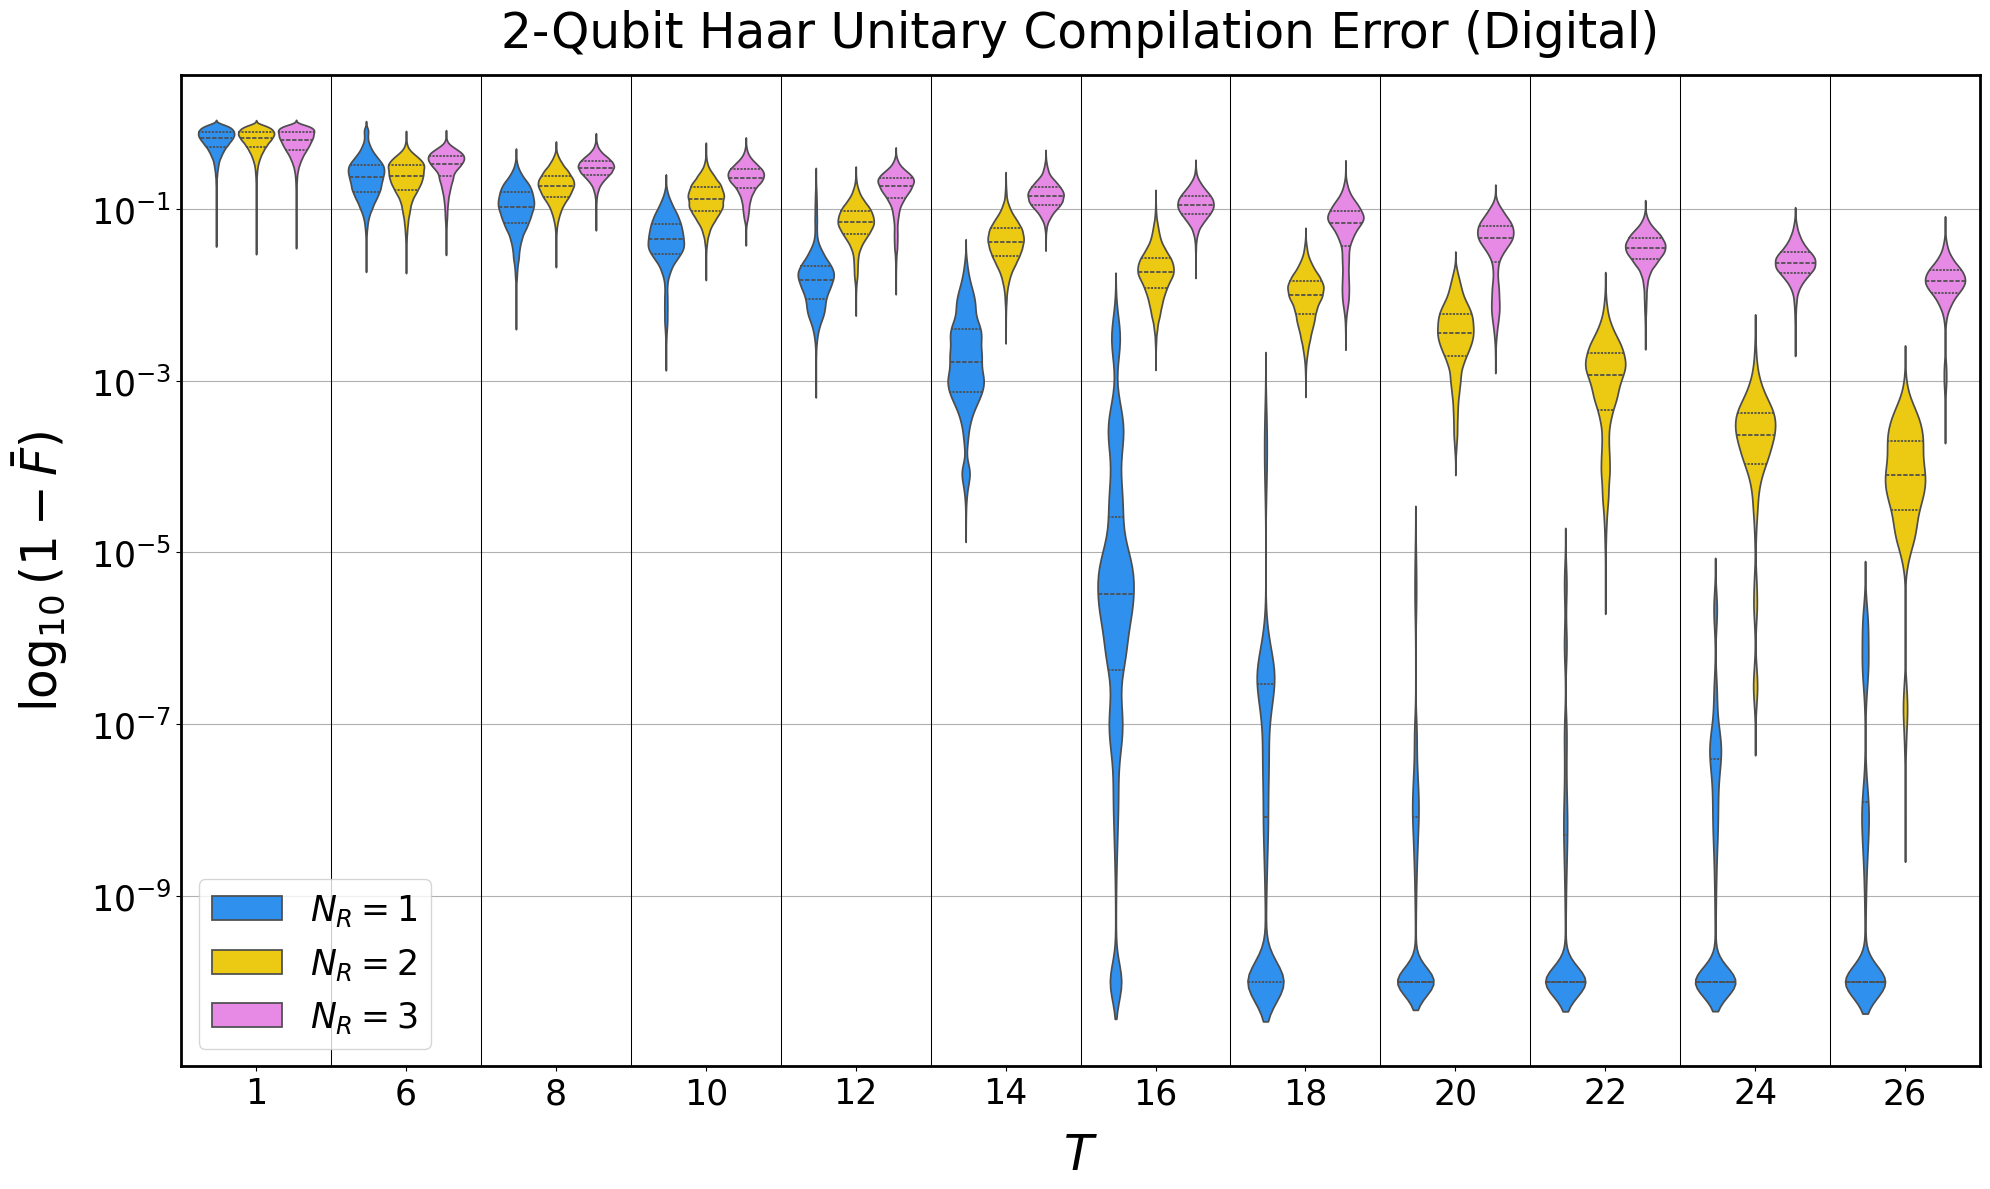

In [21]:

# Initialize variables to store global min and max y-values
global_min_y = float('inf')
global_max_y = float('-inf')
global_min_fidelity = float('inf')
global_max_fidelity = float('-inf')

custom_palette = ['dodgerblue', 'gold', 'violet'] 
plt.close('all')  # Close previous figures to avoid conflicts
N_ctrls = [2]
resies = [1,2,3,4,5,6,7,8,9]
resies = [1,2,3]
for N_ctrl in N_ctrls:
    
    if N_ctrl == 2:
        trots = [1, 10, 11, 12, 13, 14, 16, 17,18, 20, 22, 24, 26, 28]
        resies = [1,2,3]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8,9,10]
        resies = [1,2,3]
    else:
        trots = np.arange(1, 50, 1)

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))]

    # Aggregate average fidelity by Trotter_Step and Reservoir Count
    aggregated_fidelity = data_df.groupby(['Trotter_Step', 'Reservoir Count'])['Avg_Fidelity'].mean().reset_index()

    # Get the min and max fidelity from aggregated results
    current_min_fidelity = aggregated_fidelity['Avg_Fidelity'].min()
    current_max_fidelity = aggregated_fidelity['Avg_Fidelity'].max()

    # Explode test results into separate rows to plot each error individually
    test_results_df_error = data_df.explode('Error_Test_Results').dropna(subset=['Error_Test_Results'])

    # Get min and max y-values for the current N_ctrl (log-error test results)
    current_min_y = test_results_df_error['Error_Test_Results'].min()
    current_max_y = test_results_df_error['Error_Test_Results'].max()

    # Update global min/max values
    global_min_y = min(global_min_y, current_min_y)
    global_max_y = max(global_max_y, current_max_y)
    global_min_fidelity = min(global_min_fidelity, current_min_fidelity)
    global_max_fidelity = max(global_max_fidelity, current_max_fidelity)

# Add a slight margin to avoid cutoff on the plot
margin_factor = 0.1
global_min_y -= margin_factor * abs(global_min_y)
global_max_y += margin_factor * abs(global_max_y)

print(f"global_min_y: {global_min_y}, global_max_y: {global_max_y}")
print(f"global_min_fidelity: {global_min_fidelity}, global_max_fidelity: {global_max_fidelity}")

custom_palette = ['dodgerblue', 'gold', 'violet'] 
# Now that we have the global y-limits, we can proceed to plotting
for N_ctrl in N_ctrls:
    if N_ctrl == 2:
        trots = [1, 6, 8,10, 12,13,14,15, 16,17, 18,19,20,22,24,25,26,27,28]
        # trots = [1,2,3,4,5,6]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14]

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['Trotter_Step'].isin(trots)]
    data_df = data_df[data_df['Reservoir Count'].isin(resies)]

    # Explode test results into separate rows to plot each error individually
    test_results_df = data_df.explode('infidelities')

    # Find the common Trotter steps across all reservoir counts
    grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'Reservoir Count']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # Filter the DataFrame to only include those Trotter steps
    test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

    # Drop rows with NaN values in 'Error_Test_Results' to avoid errors
    test_results_df = test_results_df.dropna(subset=['infidelities'])

    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(20, 12))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    # Violin plot for Error_Test_Results (log10(1 - Test Results))
    sns.violinplot(x='Trotter_Step', y='infidelities', hue='Reservoir Count', data=test_results_df, 
                   ax=axs,width=0.8, palette=custom_palette,log_scale=True,cut=2, density_norm='count', inner='quartile', saturation=0.85)

    # Set titles and labels with padding
    # axs.set_title(f"$\\log_{{10}}(1 - \\bar{{F}}) \\, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$", fontsize=30, pad=20)
    axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Digital)", fontsize=35, pad=20)
    
    axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding


    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)

    # # Set the global Y-limits
    axs.set_ylim(global_min_y, global_max_y)

    # # Set Y-ticks and labels
    # y_ticks = axs.get_yticks()
    # whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    # min_tick = min(whole_y_ticks)
    # max_tick = max(whole_y_ticks)
    # whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
    # print(whole_y_ticks)
    # axs.set_yticks(whole_y_ticks)
    # axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set tick parameters
    axs.tick_params(axis='y', labelsize=25)
    axs.tick_params(axis='x', labelsize=25)

    # Add vertical lines to separate groups
    unique_trotter_steps = test_results_df['Trotter_Step'].unique()
    positions = range(1, len(unique_trotter_steps), 1)
    for pos in positions:
        axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

    # Prevent clipping of y-axis ticks/labels
    # plt.tight_layout(pad=3.0)
    # plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

    # Show the plot for the current N_ctrl
    plt.tight_layout()
    plt.show()

global_min_fidelity: 0.35108348235144515, global_max_fidelity: 0.9999998682109714


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_4163/728287608.py:14: RuntimeWarning: invalid value encountered in power
  return normalized ** self.gamma  # Exaggerate higher values
/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_4163/728287608.py:14: RuntimeWarning: invalid value encountered in power
  return normalized ** self.gamma  # Exaggerate higher values


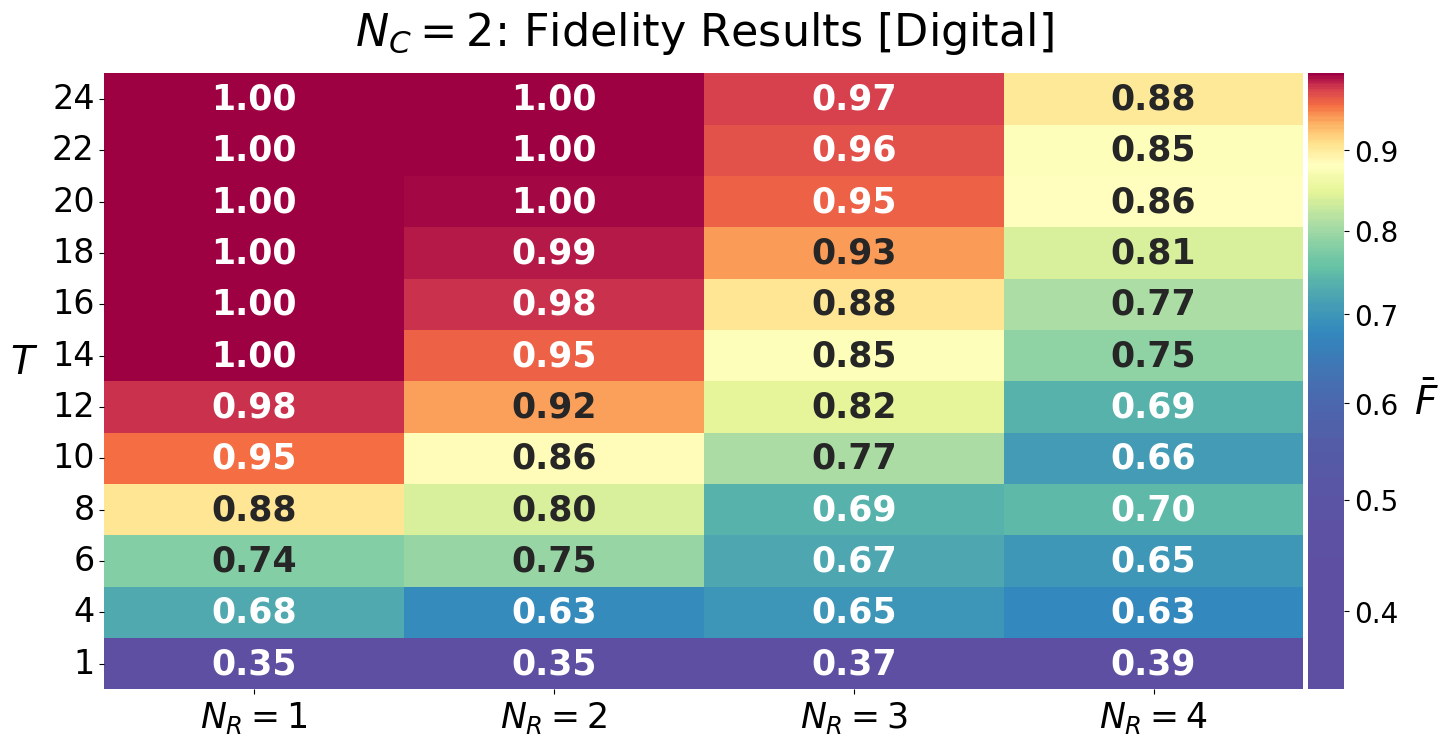

In [22]:
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
class ExaggeratedPowerNorm(Normalize):
    def __init__(self, gamma, vmin=None, vmax=None, clip=False):
        super().__init__(vmin=vmin, vmax=vmax, clip=clip)
        self.gamma = gamma

    def __call__(self, value, clip=None):
        vmin, vmax = self.vmin, self.vmax
        if vmin is None or vmax is None:
            raise ValueError("You must set both vmin and vmax for normalization")
        normalized = (value - vmin) / (vmax - vmin)  # Normalize to [0, 1]
        return normalized ** self.gamma  # Exaggerate higher values


width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(reservoir_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.inferno  # Base colormap for visual appeal

from matplotlib.colors import LinearSegmentedColormap


base_colormap = sns.color_palette("Spectral", as_cmap=True).reversed()

N_ctrls = [2]

# N_ctrls = [1,2]
# global_min_fidelity *= 1.25 
print(f"global_min_fidelity: {global_min_fidelity}, global_max_fidelity: {global_max_fidelity}")
resies = [1,2,3,4,5,6]
for N_ctrl in N_ctrls:
    if N_ctrl == 3:
        trots = np.arange(1,50,1)
    elif N_ctrl == 2:
        trots = [1, 4, 6, 8, 10, 12, 14, 16, 17,18,19,20,21,22, 24]
        # trots = np.arange(1,50,1)
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14]

    # Filter data for the current N_ctrl and specific Trotter steps
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))  & (all_data_df['Reservoir Count'].isin(resies))]

    # Compute average fidelity and standard deviation for each Trotter step and Reservoir Count
    averaged_data = data_df.groupby(['Trotter_Step', 'Reservoir Count', 'N_params']).agg(
        Average_Fidelity=('Avg_Fidelity', 'mean'),
        Std_Dev=('Avg_Fidelity', 'std')
    ).reset_index()

    # Pivot the data for the heatmap
    pivot_avg = averaged_data.pivot(index="Trotter_Step", columns="Reservoir Count", values="Average_Fidelity")
    pivot_std = averaged_data.pivot(index="Trotter_Step", columns="Reservoir Count", values="N_params")

    # Create annotation matrix for Average Fidelity heatmap
    annotation_matrix_avg = pivot_avg.map("{:.2f}".format)
    # annotation_matrix_avg = pivot_std.map("{:.0f}".format)

    # Define the custom colormap
    values = np.linspace(global_min_fidelity**2, 1, n_colors)**4
    colors = base_colormap(values)
    # custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_inferno', colors, N=n_colors)
    custom_colormap = LinearSegmentedColormap.from_list('vibrant', colors, N=n_colors)
    # Create the figure and axis for the heatmap
    fig, axs = plt.subplots(1, figsize=(16, 8))
    heatmap_ax_avg = axs

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(heatmap_ax_avg)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # Plot the average fidelity heatmap with annotations
    # sns.heatmap(
    #     pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, 
    #     ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'}, 
    #     annot_kws={"weight": "bold", "size": 14}, vmin=0.3, vmax=1.00
    # )
    sns.heatmap(
    pivot_avg, 
    annot=annotation_matrix_avg, 
    fmt="s", 
    cmap=custom_colormap, 
    ax=heatmap_ax_avg, 
    cbar_ax=cax, 
    cbar_kws={'label': 'Fidelity'}, 
    annot_kws={"weight": "bold", "size": 25}, 
    #  vmin=global_min_fidelity, vmax=global_max_fidelity
    norm=ExaggeratedPowerNorm(gamma=.8, vmin=global_min_fidelity, vmax=global_max_fidelity)  # Custom exaggeration norm

    # norm=PowerNorm(gamma=0.6, vmin=global_min_fidelity, vmax=global_max_fidelity)  # Adjust gamma (e.g., 0.5 for more contrast in low range)
    )

    # Adjust the color bar
    cbar = heatmap_ax_avg.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\bar{F}$', rotation=0, labelpad=20, fontsize=28, weight='bold')

    # Customize the plot appearance
    heatmap_ax_avg.invert_yaxis()
    heatmap_ax_avg.set_title(f'$N_{{C}} = {N_ctrl}$: Fidelity Results [Digital]', fontsize=32, pad=20)
    heatmap_ax_avg.set_ylabel("$T$", labelpad=20, fontsize=28, rotation=0)
    heatmap_ax_avg.set_xticklabels([f'$N_R = {int(rc)}$' for rc in pivot_avg.columns], fontweight='bold', fontsize=25, rotation=0)
    heatmap_ax_avg.set_yticklabels([int(ts) for ts in pivot_avg.index], fontsize=24, rotation=0)
    heatmap_ax_avg.set_xlabel('')

    plt.show()

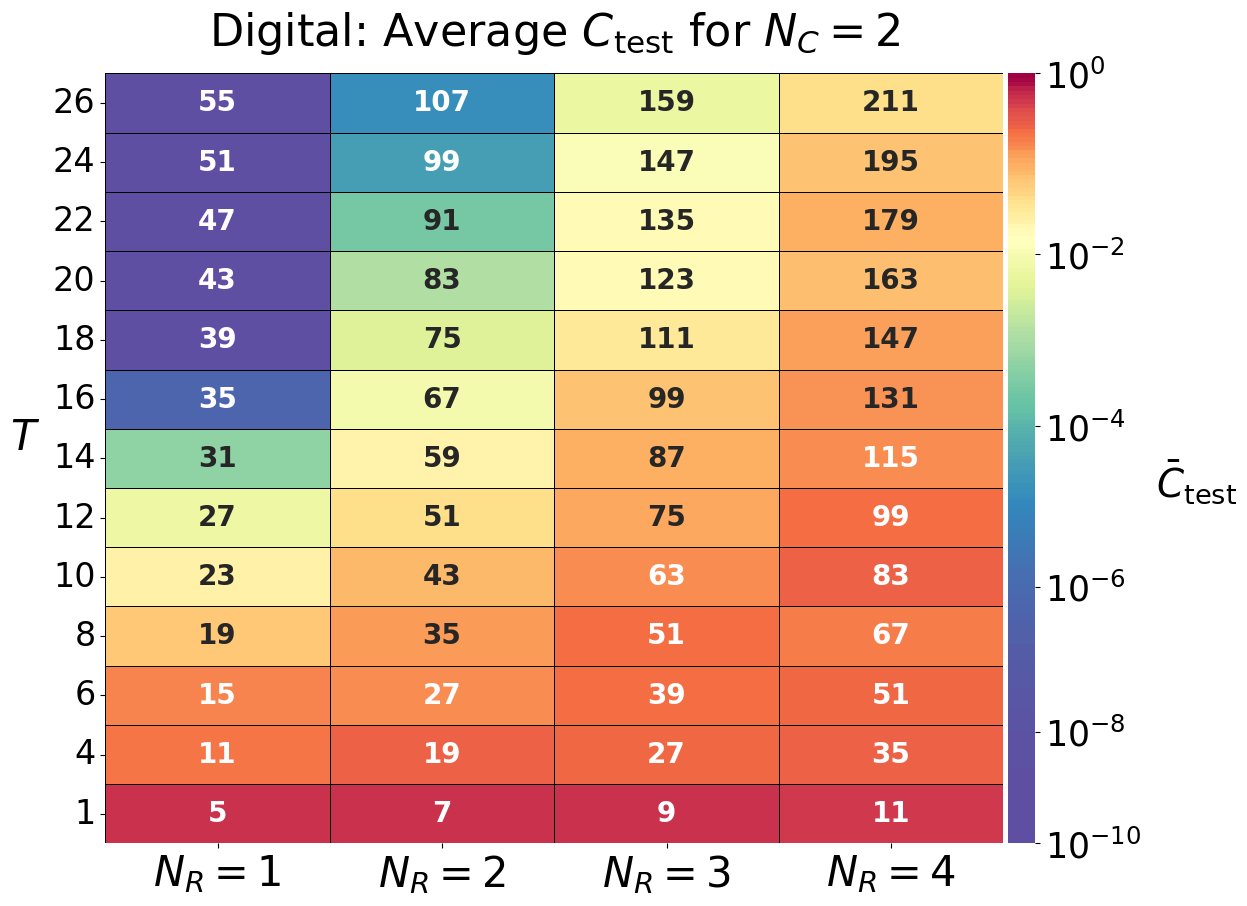

In [25]:
resies = [1,2,3,4,5,6]
for N_ctrl in N_ctrls:
    if N_ctrl == 3:
        trots = np.arange(1,50,1)
    elif N_ctrl == 2:
        trots = [1, 4, 6, 8, 10, 12, 14, 16, 17,18,19,20,21,22, 24,26]
        # trots = np.arange(1,50,1)
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14]

    # Filter data for the current N_ctrl and specific Trotter steps
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))  & (all_data_df['Reservoir Count'].isin(resies))]

    # Compute average fidelity and standard deviation for each Trotter step and Reservoir Count
    averaged_data = data_df.groupby(['Trotter_Step', 'Reservoir Count', 'N_params']).agg(
        Average_infidelity=('Avg_infidelity', 'mean'),
        Avg_Error=('Avg Error', 'mean')
    ).reset_index()
    

    # Pivot the data for the heatmap
    pivot_avg = averaged_data.pivot(index="Trotter_Step", columns="Reservoir Count", values="Avg_Error")
    pivot_std = averaged_data.pivot(index="Trotter_Step", columns="Reservoir Count", values="N_params")

    # Create annotation matrix for Average Fidelity heatmap
    # annotation_matrix_avg = pivot_avg.map("{:.1f}".format)
    annotation_matrix_avg = pivot_std.map("{:.0f}".format)

    # Define the custom colormap
    values = np.linspace(global_min_fidelity**2, 1, n_colors)**4
    colors = base_colormap(values)
    # custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_inferno', colors, N=n_colors)
    custom_colormap = LinearSegmentedColormap.from_list('vibrant', colors, N=n_colors)
    # Create the figure and axis for the heatmap
    fig, axs = plt.subplots(1, figsize=(12, 10))
    heatmap_ax_avg = axs

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(heatmap_ax_avg)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # Plot the average fidelity heatmap with annotations
    # sns.heatmap(
    #     pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, 
    #     ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'}, 
    #     annot_kws={"weight": "bold", "size": 14}, vmin=0.3, vmax=1.00
    # )
    sns.heatmap(
    pivot_avg, 
    annot=annotation_matrix_avg, 
    fmt="s", 
    cmap=custom_colormap, 
    ax=heatmap_ax_avg, 
    cbar_ax=cax, 
    cbar_kws={'label': 'Fidelity'}, 
    annot_kws={"weight": "bold", "size": 20}, 
    #  vmin=global_min_fidelity, vmax=global_max_fidelity
    norm=ExaggeratedPowerNorm(gamma=1.2, vmin=-10, vmax=0),  # Custom exaggeration norm
    linewidths=0.5,  # Width of the cell borders
    linecolor="black"  # Color of the borders
    # norm=PowerNorm(gamma=0.8, vmin=-9, vmax=0)  # Adjust gamma (e.g., 0.5 for more contrast in low range)
    )

    # Adjust the color bar
    cbar = heatmap_ax_avg.collections[0].colorbar
    cbar.ax.tick_params(labelsize=25)
    # Set the ticks and labels for the color bar
    ticks = cbar.get_ticks()  # Get current ticks
    cbar.set_ticks(ticks)  # Reset ticks to match current settings
    cbar.set_ticklabels([r"$10^{{{:.0f}}}$".format(t) for t in ticks])  # Set labels as 10^tick

    cbar.set_label(r'$\bar{C}_{\text{test}}$', rotation=0, labelpad=40, fontsize=28, weight='bold')
    cbar.ax.xaxis.set_label_position('top')
    # Customize the plot appearance
    heatmap_ax_avg.invert_yaxis()
    ctest_str = r'$C_{\text{test}}$'
    heatmap_ax_avg.set_title(f'Digital: Average {ctest_str} for $N_{{C}} = {N_ctrl}$', fontsize=32, pad=20)
    heatmap_ax_avg.set_ylabel("$T$", labelpad=20, fontsize=30, rotation=0)
    heatmap_ax_avg.set_xticklabels([f'$N_R = {int(rc)}$' for rc in pivot_avg.columns], fontweight='bold', fontsize=30, rotation=0)
    heatmap_ax_avg.set_yticklabels([int(ts) for ts in pivot_avg.index], fontsize=24, rotation=0)
    heatmap_ax_avg.set_xlabel('')

    plt.show()

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_4163/1666990989.py:20: RuntimeWarning: invalid value encountered in power
  return normalized ** self.gamma  # Exaggerate higher values
/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_4163/1666990989.py:20: RuntimeWarning: invalid value encountered in power
  return normalized ** self.gamma  # Exaggerate higher values


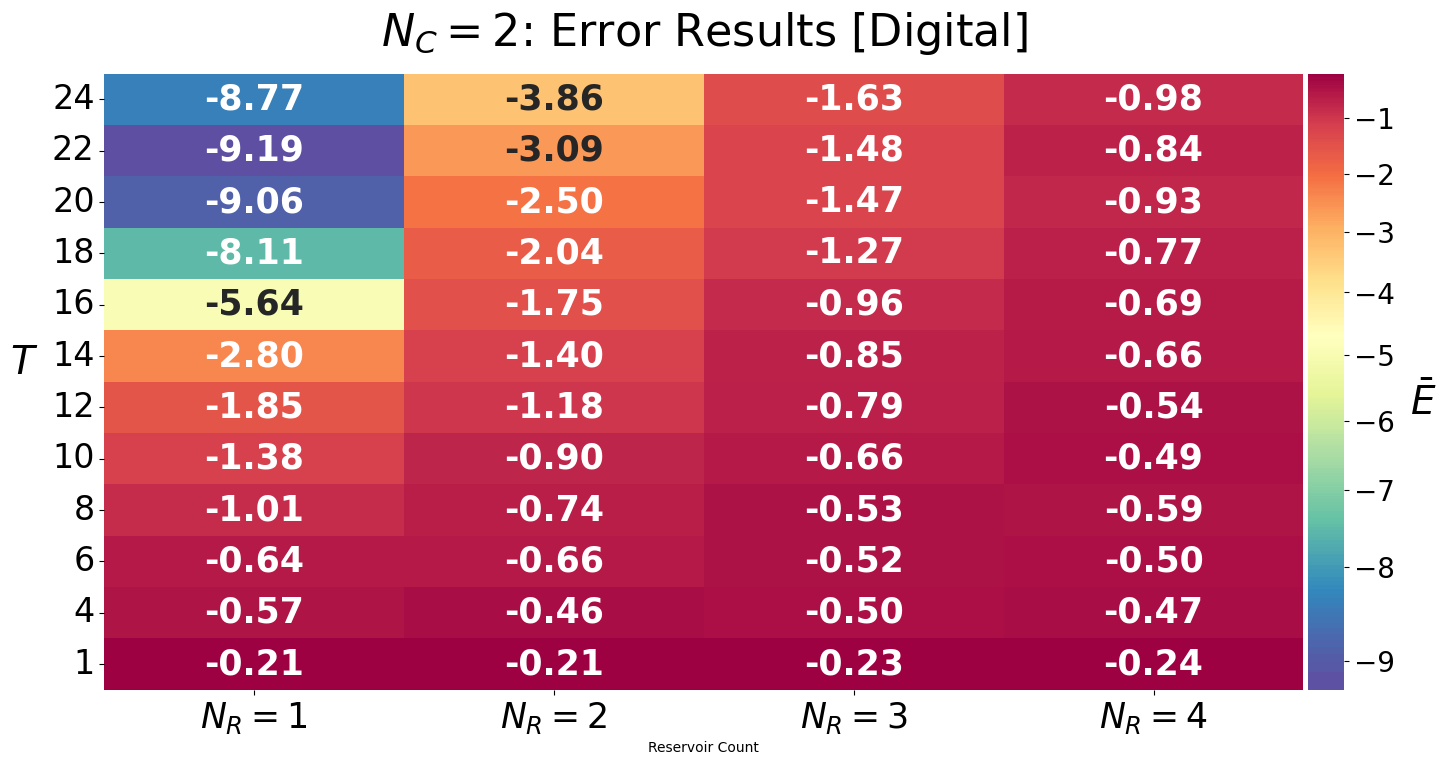

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize

# Define custom normalization for the heatmap
class ExaggeratedPowerNorm(Normalize):
    def __init__(self, gamma, vmin=None, vmax=None, clip=False):
        super().__init__(vmin=vmin, vmax=vmax, clip=clip)
        self.gamma = gamma

    def __call__(self, value, clip=None):
        vmin, vmax = self.vmin, self.vmax
        if vmin is None or vmax is None:
            raise ValueError("You must set both vmin and vmax for normalization")
        normalized = (value - vmin) / (vmax - vmin)  # Normalize to [0, 1]
        return normalized ** self.gamma  # Exaggerate higher values

# Global variables for plotting
width = 0.6  # Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
base_colormap = sns.color_palette("Spectral", as_cmap=True).reversed()  # Base colormap
reservoir_counts = [1, 2, 3, 4, 5, 6]
N_ctrls = [2]


# Loop over control counts to generate heatmaps
for N_ctrl in N_ctrls:
    if N_ctrl == 3:
        trots = np.arange(1, 50, 1)
    elif N_ctrl == 2:
        trots = [1, 4, 6, 8, 10, 12, 14, 16, 17, 18, 19, 20, 21, 22, 24]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

    # Filter data for the current N_ctrl and specific Trotter steps
    filtered_df = all_data_df[
        (all_data_df['N_C'] == N_ctrl) & 
        (all_data_df['Trotter_Step'].isin(trots)) & 
        (all_data_df['Reservoir Count'].isin(reservoir_counts))
    ]
     # Step 2: Flatten Error_Test_Results for each group
    aggregated_data = (
        filtered_df
        .groupby(['Trotter_Step', 'Reservoir Count', 'N_params'], as_index=False)  # Avoid using the index
        .agg({
            'Error_Test_Results': lambda x: np.concatenate(x.values)  # Flatten arrays
        })
    )
    # # print("Aggregated Data (Flattened Error_Test_Results):")
    # print(aggregated_data.head())

    # Step 3: Compute the mean of the flattened Error_Test_Results
    aggregated_data['Final_Error'] = aggregated_data['Error_Test_Results'].apply(
        lambda x: np.mean(x) if isinstance(x, np.ndarray) else np.nan
    )
    # print("Aggregated Data with Final_Error:")
    # print(aggregated_data[['Trotter_Step', 'Reservoir Count', 'N_params', 'Final_Error']].head())

    # Step 4: Create the final averaged_data for pivoting
    averaged_data = aggregated_data[['Trotter_Step', 'Reservoir Count', 'N_params', 'Final_Error']]
    # print("Averaged Data:")
    # print(averaged_data.head())

    # Step 5: Pivot data for heatmap
    pivot_avg = averaged_data.pivot(index="Trotter_Step", columns="Reservoir Count", values="Final_Error")
    # print("Pivoted Data for Heatmap:")
    # print(pivot_avg.head())

    

    annotation_matrix_avg = pivot_avg.map("{:.2f}".format)

    # Define custom colormap
    values = np.linspace(0, 1, n_colors)
    colors = base_colormap(values)
    custom_colormap = LinearSegmentedColormap.from_list('error_colormap', colors, N=n_colors)

    # Plot the heatmap
    fig, axs = plt.subplots(1, figsize=(16, 8))
    heatmap_ax_avg = axs
    divider = make_axes_locatable(heatmap_ax_avg)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    sns.heatmap(
        pivot_avg, 
        annot=annotation_matrix_avg, 
        fmt="s", 
        cmap=custom_colormap, 
        ax=heatmap_ax_avg, 
        cbar_ax=cax, 
        cbar_kws={'label': 'Avg Error'}, 
        annot_kws={"weight": "bold", "size": 25}, 
        norm=ExaggeratedPowerNorm(gamma=0.8, vmin=pivot_avg.min().min(), vmax=pivot_avg.max().max())
    )

    # Customize the plot
    cbar = heatmap_ax_avg.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\bar{E}$', rotation=0, labelpad=20, fontsize=28, weight='bold')

    heatmap_ax_avg.invert_yaxis()
    heatmap_ax_avg.set_title(f'$N_{{C}} = {N_ctrl}$: Error Results [Digital]', fontsize=32, pad=20)
    heatmap_ax_avg.set_ylabel("$T$", labelpad=20, fontsize=28, rotation=0)
    heatmap_ax_avg.set_xticklabels(
        [f'$N_R = {int(rc)}$' for rc in pivot_avg.columns], 
        fontweight='bold', fontsize=25, rotation=0
    )
    heatmap_ax_avg.set_yticklabels(
        [int(ts) for ts in pivot_avg.index], 
        fontsize=24, rotation=0
    )

    plt.show()


Filtering data for N_ctrl=2 and N_R=1...
Calculating median and IQR...


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_50523/1282690393.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


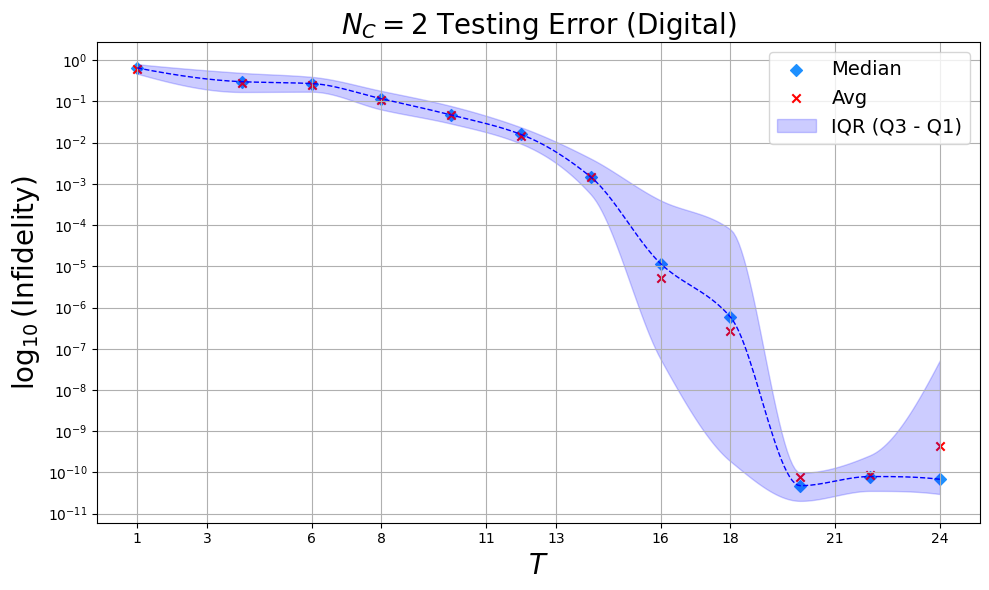

Filtering data for N_ctrl=2 and N_R=2...
Calculating median and IQR...


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_50523/1282690393.py:151: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


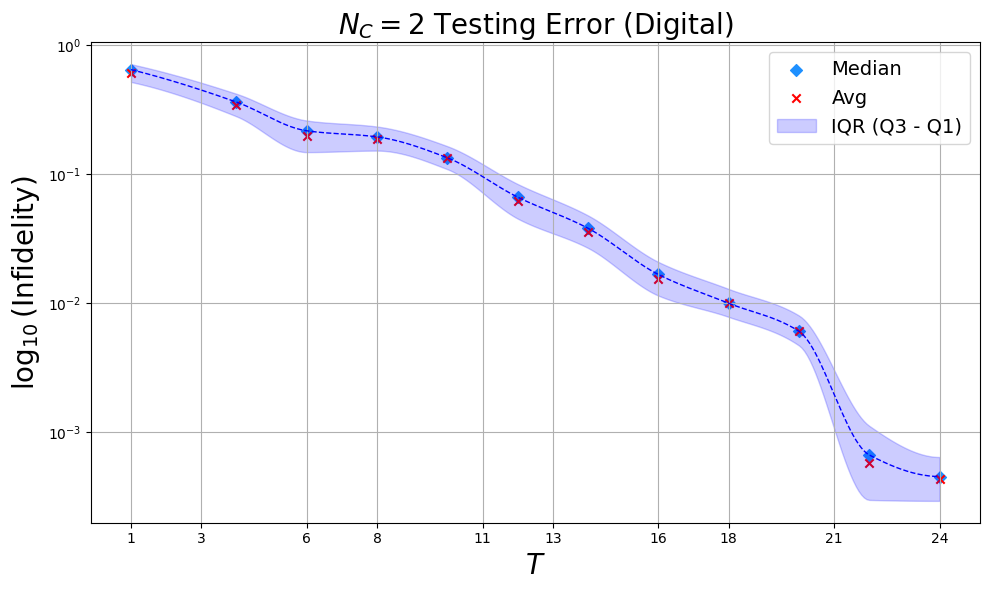

In [20]:


from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator
def plot_error_with_smoothed_bands(data_df, N_ctrl, N_R, xlabel, ylabel, title, midpoint_metric = 'Total_Avg_Infidelity',std_metric='Error_Test_Results'):
    """
    Plot error statistics using the median and IQR for the existing 'Avg Error' column.

    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', 'Avg Error', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): Reservoir count to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
    """


    # Filter the DataFrame for specific N_ctrl and Reservoir Count
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)].copy()

    # Flatten the std_metric column if it contains lists
    # Flatten the std_metric column if it contains lists
    if std_metric in ['Error_Test_Results', 'infidelities']:
        # For list-based metrics, flatten using np.concatenate
        filtered_df.loc[:, std_metric] = filtered_df[std_metric].apply(
            lambda x: np.concatenate(x) if isinstance(x, list) else x
        )
    elif std_metric in ['Avg Error', 'Avg_infidelity']:
        # For scalar metrics, no flattening is needed
        filtered_df.loc[:, std_metric] = filtered_df[std_metric]
    else:
        raise ValueError(f"Unexpected std_metric: {std_metric}")

    # Ensure there are no NaNs in the std_metric column
    if filtered_df[std_metric].isna().any():
        raise ValueError("NaN values detected in the specified std_metric column! Check the data preprocessing step.")
    
    # Group by 'Trotter_Step' and calculate statistics
    print("Calculating median and IQR...")
    stats = (
        filtered_df.groupby('Trotter_Step', group_keys=False)
        .apply(lambda group: pd.Series({
            # 'median': group[midpoint_metric].iloc[0],  # Median is already a single value per group
             'median': np.median(np.concatenate(group[std_metric].values)), 
              
            'lower_bound': np.percentile(np.concatenate(group[std_metric].values), 20),  # Q1 from std_metric
            'upper_bound': np.percentile(np.concatenate(group[std_metric].values), 80),   # Q3 from std_metric
            'avg': np.mean(np.concatenate(group[std_metric].values)),   # Q3 from std_metric
            'std': np.std(np.concatenate(group[std_metric].values))   # Q3 from std_metric
        }))
        .reset_index()
    )
    
    # Print statistics for verification
    # print("\nTrotter Step | Median | Q1 (Lower Bound) | Q3 (Upper Bound)")
    # for _, row in stats.iterrows():
    #     print(f"Trotter Step: {row['Trotter_Step']} | Median: {row['median']:.1e} | Mean: {row['avg']:.1e} | Q3-Q1: {abs(row['upper_bound']) - abs(row['lower_bound']):.2e} ")

    pchip_median = PchipInterpolator(stats['Trotter_Step'], stats['median'])
    pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])
   

    # Generate fine-grained x-axis for smooth plotting
    x_fine = np.linspace(stats['Trotter_Step'].min(), stats['Trotter_Step'].max(), 300)

    # Evaluate the PCHIP interpolators
    median_smooth = pchip_median(x_fine)
    lower_smooth = pchip_lower(x_fine)
    upper_smooth = pchip_upper(x_fine)


    # # Evaluate the splines
    # median_smooth = spline_median(x_fine)
    # lower_smooth = spline_lower(x_fine)
    # upper_smooth = spline_upper(x_fine)

    # Plot the splines
    fig, axs = plt.subplots(figsize=(10, 6))
    plt.plot(x_fine, median_smooth,linestyle='--',lw=1, color='blue')
    plt.scatter(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='D', 
        color='dodgerblue'
    )
    plt.scatter(stats['Trotter_Step'], stats['avg'], label='Avg', marker='x', color='red')
    # plt.plot(x_fine, upper_smooth, label='Smoothed Upper Bound (Q3)', linestyle='--', color='red')
    plt.fill_between(x_fine, lower_smooth, upper_smooth, color='blue', alpha=0.2,label='IQR (Q3 - Q1)')
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick+1, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
    num_ticks = 10  # Adjust this for more or fewer ticks
    x_ticks = np.linspace(min(stats['Trotter_Step']), max(stats['Trotter_Step']), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])
    # Customize the plot
    plt.xlabel('$T$', fontsize=20)
    plt.ylabel(r'$\log_{10}\left(\text{Infidelity}\right)$', fontsize=20)
    plt.title(f"$N_C={N_ctrl}$ Testing Error (Digital)", fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()
def plot_error_with_smoothed_bands_std(data_df, N_ctrl, N_R, xlabel, ylabel, title, midpoint_metric = 'Total_Avg_Infidelity',std_metric='Error_Test_Results'):
    """
    Plot error statistics using the median and IQR for the existing 'Avg Error' column.

    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', 'Avg Error', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): Reservoir count to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
    """


    # Filter the DataFrame for specific N_ctrl and Reservoir Count
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)].copy()

    # Flatten the std_metric column if it contains lists
    # Flatten the std_metric column if it contains lists
    if std_metric in ['Error_Test_Results', 'infidelities']:
        # For list-based metrics, flatten using np.concatenate
        filtered_df.loc[:, std_metric] = filtered_df[std_metric].apply(
            lambda x: np.concatenate(x) if isinstance(x, list) else x
        )
    elif std_metric in ['Avg Error', 'Avg_infidelity']:
        # For scalar metrics, no flattening is needed
        filtered_df.loc[:, std_metric] = filtered_df[std_metric]
    else:
        raise ValueError(f"Unexpected std_metric: {std_metric}")

    # Ensure there are no NaNs in the std_metric column
    if filtered_df[std_metric].isna().any():
        raise ValueError("NaN values detected in the specified std_metric column! Check the data preprocessing step.")
    
    # Group by 'Trotter_Step' and calculate statistics
    print("Calculating median and IQR...")
    stats = (
        filtered_df.groupby('Trotter_Step', group_keys=False)
        .apply(lambda group: pd.Series({
            # 'median': group[midpoint_metric].iloc[0],  # Median is already a single value per group
             'median': np.median(np.concatenate(group[std_metric].values)), 
              
            'q1': np.percentile(np.concatenate(group[std_metric].values), 25),  # Q1 from std_metric
            'q3': np.percentile(np.concatenate(group[std_metric].values), 75),   # Q3 from std_metric
            'avg': np.mean(np.concatenate(group[std_metric].values)),   # Q3 from std_metric
            'lower_bound':np.mean(np.concatenate(group[std_metric].values))- np.std(np.concatenate(group[std_metric].values))/2,   # Q3 from std_metric
            'upper_bound':np.mean(np.concatenate(group[std_metric].values))+ np.std(np.concatenate(group[std_metric].values))/2 # Q3 from std_metric
        }))
        .reset_index()
    )
    
    # Print statistics for verification
    # print("\nTrotter Step | Median | Q1 (Lower Bound) | Q3 (Upper Bound)")
    # for _, row in stats.iterrows():
    #     print(f"Trotter Step: {row['Trotter_Step']} | Median: {row['median']:.1e} | Mean: {row['avg']:.1e} | Q3-Q1: {abs(row['upper_bound']) - abs(row['lower_bound']):.2e} ")

    pchip_median = PchipInterpolator(stats['Trotter_Step'], stats['median'])
    # pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    # pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])
    pchip_mean = PchipInterpolator(stats['Trotter_Step'], stats['avg'])
    pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])

    # Generate fine-grained x-axis for smooth plotting
    x_fine = np.linspace(stats['Trotter_Step'].min(), stats['Trotter_Step'].max(), 300)

    # Evaluate the PCHIP interpolators
    median_smooth = pchip_median(x_fine)
    lower_smooth = pchip_lower(x_fine)
    upper_smooth = pchip_upper(x_fine)


    # # Evaluate the splines
    # median_smooth = spline_median(x_fine)
    # lower_smooth = spline_lower(x_fine)
    # upper_smooth = spline_upper(x_fine)

    # Plot the splines
    fig, axs = plt.subplots(figsize=(10, 6))
    plt.plot(x_fine, median_smooth,linestyle='--',lw=1, color='blue')
    plt.scatter(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='D', 
        color='dodgerblue'
    )
    plt.scatter(stats['Trotter_Step'], stats['avg'], label='Avg', marker='x', color='red')
    # plt.plot(x_fine, upper_smooth, label='Smoothed Upper Bound (Q3)', linestyle='--', color='red')
    plt.fill_between(x_fine, lower_smooth, upper_smooth, color='blue', alpha=0.2,label='IQR (Q3 - Q1)')
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick+1, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
    num_ticks = 10  # Adjust this for more or fewer ticks
    x_ticks = np.linspace(min(stats['Trotter_Step']), max(stats['Trotter_Step']), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])
    # Customize the plot
    plt.xlabel('$T$', fontsize=20)
    plt.ylabel(r'$\log_{10}\left(\text{Infidelity}\right)$', fontsize=20)
    plt.title(f"$N_C={N_ctrl}$ Testing Error (Digital)", fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()
aggregated_data = (
    all_data_df
    .groupby(['Trotter_Step', 'Reservoir Count', 'N_C', 'N_params'])
    .agg({
        'infidelities': lambda x: np.concatenate(x.values),  # Flatten infidelities
        'Error_Test_Results': lambda x: np.concatenate(x.values),  # Flatten test results
         'Avg_infidelity': list,  # Aggregate floats into a list
        'Avg Error': list,  # Aggregate floats into a list
    })
    .reset_index()
)

# print(aggregated_data)

aggregated_data['Total_Avg_Error'] = aggregated_data['Error_Test_Results'].apply(
    lambda res: np.mean(res)
)
aggregated_data['Total_Avg_Infidelity'] = aggregated_data['infidelities'].apply(
    lambda res: np.mean(res)
)
aggregated_data['Median_Error'] = aggregated_data['Error_Test_Results'].apply(
    lambda res: np.median(res)
)
aggregated_data['Median_infidelity'] = aggregated_data['infidelities'].apply(
    lambda res: np.median(res)
)
# print(aggregated_data.head())

plot_error_with_smoothed_bands(
    data_df=aggregated_data,
    N_ctrl=2,
    N_R=1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps',
    midpoint_metric = 'Total_Avg_Error',
    # midpoint_metric = 'Total_Avg_Error',
    std_metric = 'Error_Test_Results'
)
plot_error_with_smoothed_bands_std(
    data_df=aggregated_data,
    N_ctrl=2,
    N_R=2,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps',
    midpoint_metric = 'Avg Error',
    std_metric = 'Error_Test_Results'
)

# #
# # Plot for N_ctrl=1 and Reservoir Count=1
# plot_error_with_iqr_averaged(
#     data_df=aggregated_data,
#     N_ctrl=1,
#     N_R=1,
#     xlabel='$T$', 
#     ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
#     title='Median and IQR of Averaged Compilation Error vs Trotter Steps'
# )

In [31]:
rows = []  # List to hold rows temporarily
negative_fidelity_values = []

print("[DEBUG] Starting DataFrame construction...")
for N_ctrl in N_ctrls:
    print(f"[DEBUG] Processing N_C={N_ctrl}")

    # Extract cached data for this N_C
    data_i = cached_data[N_ctrl]
    for gate, gate_data in data_i.items():
        print(f"  [DEBUG] Processing Gate: {gate}")

        for reservoir_count, res_data in gate_data.items():
            print(f"    [DEBUG] Processing Reservoir Count: {reservoir_count}, Total Trotter Steps: {len(res_data)}")

            for trotter_step, results_list in res_data.items():
                print(f"      [DEBUG] Processing Trotter Step: {trotter_step}, Results List Length: {len(results_list)}")

                for results in results_list:
                    # Handle missing fidelity and other fields
                    avg_fidelity = float(results['fidelity']) if 'fidelity' in results else np.nan
                    if pd.isna(avg_fidelity):
                        print(f"        [WARNING] NaN avg_fidelity for Gate={gate}, Reservoir Count={reservoir_count}, Trotter Step={trotter_step}")
                        continue  # Skip this row if avg_fidelity is NaN
                    
                    log_infidelities = []
                    infidelities = []
                    if 'test_results' in results:
                        test_results = results['test_results']
                        for fidelity in test_results:
                            if fidelity < 0:
                                # Track negative fidelity values
                                negative_fidelity_values.append((gate, reservoir_count, trotter_step))
                            if fidelity >= 1.0:
                                fidelity = avg_fidelity
                            infidelity = max(1.0 - fidelity, min_error)
                            infidelities.append(infidelity)
                            log_infidelities.append(np.log10(infidelity))
                    else:
                        test_results = []
                        log_infidelities = []

                    num_params = results.get('param_count', np.nan)
                    run = results.get('run', None)

                    # Calculate average log infidelity
                    avg_log_infidelity = (
                        np.log10(1.0 - avg_fidelity)
                        if pd.notna(avg_fidelity) and avg_fidelity < 1.0
                        else np.log10(min_error)
                    )

                    # Prepare the row dictionary
                    row = {
                        'N_C': N_ctrl,
                        'Trotter_Step': trotter_step,
                        'Gate': results['gate'],
                        'Reservoir Count': reservoir_count,
                        'Avg_Fidelity': avg_fidelity,
                        'Avg_infidelity': 1.0 - avg_fidelity,
                        'Error_Test_Results': len(log_infidelities),  # Only log the count
                        'Avg Error': avg_log_infidelity,
                        'infidelities': len(infidelities),  # Log count of infidelities
                        'Costs': len(results.get('costs', [])),  # Log count of costs
                        'Test Results': len(test_results),  # Log count of test results
                        'N_params': num_params,
                        'run': run,
                    }

                    rows.append(row)  # Add row to rows

# Report any issues found
if negative_fidelity_values:
    print("[WARNING] Negative fidelity values detected!")
    for gate, reservoir_count, trotter_step in negative_fidelity_values:
        print(f"  Gate: {gate}, Reservoir Count: {reservoir_count}, Trotter Step: {trotter_step}")
else:
    print("[INFO] No negative fidelity values detected.")

# Create the DataFrame from the list of rows
all_data_df = pd.DataFrame(rows)

# Debug DataFrame summary
print("[DEBUG] DataFrame Construction Complete")
print("[DEBUG] Unique Reservoir Counts in DataFrame:", all_data_df['Reservoir Count'].unique())
print("[DEBUG] Total Rows in DataFrame:", len(all_data_df))
print("[DEBUG] Unique Gates in DataFrame:", all_data_df['Gate'].unique())



[DEBUG] Starting DataFrame construction...
[DEBUG] Processing N_C=1
  [DEBUG] Processing Gate: U1_0
    [DEBUG] Processing Reservoir Count: 1, Total Trotter Steps: 8
      [DEBUG] Processing Trotter Step: 1, Results List Length: 1
      [DEBUG] Processing Trotter Step: 2, Results List Length: 1
      [DEBUG] Processing Trotter Step: 3, Results List Length: 1
      [DEBUG] Processing Trotter Step: 4, Results List Length: 1
      [DEBUG] Processing Trotter Step: 5, Results List Length: 1
      [DEBUG] Processing Trotter Step: 6, Results List Length: 1
      [DEBUG] Processing Trotter Step: 7, Results List Length: 1
      [DEBUG] Processing Trotter Step: 8, Results List Length: 1
    [DEBUG] Processing Reservoir Count: 4, Total Trotter Steps: 1
      [DEBUG] Processing Trotter Step: 1, Results List Length: 1
    [DEBUG] Processing Reservoir Count: 5, Total Trotter Steps: 1
      [DEBUG] Processing Trotter Step: 1, Results List Length: 1
    [DEBUG] Processing Reservoir Count: 6, Total Tro

In [21]:
fp = '/Users/sophieblock/QRCCapstone//digital_results_trainable_global/trainsize_10_optimized_by_cost3/U1_5/reservoirs_6/trotter_step_8//bath_False/data_run_0.pickle'
fp in processed_files

False

In [33]:
df_U1_6 = all_data_df[all_data_df['N_C'] == 1]
df_U1_6 = df_U1_6[df_U1_6['Reservoir Count'] == 2]
   

In [35]:

N_ctrls = [1,2]
jitter_scale = 1e-8
min_error = 1e-9
rows = []  # List to hold rows temporarily
negative_fidelity_values = []

for N_ctrl in N_ctrls:
    data_i = cached_data[N_ctrl]

    for gate, gate_data in data_i.items():
        for reservoir_count, res_data in gate_data.items():
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    # Handle missing fidelity and other fields
                    avg_fidelity = float(results['fidelity']) if 'fidelity' in results else np.nan
                    log_infidelities = []
                    infidelites = []
                    if 'test_results' in results:
                        test_results = results['test_results']
                        for fidelity in test_results:
                            if fidelity < 0:
                                negative_fidelity_values.append({
                                    'Gate': gate,
                                    'Reservoir Count': reservoir_count,
                                    'Trotter_Step': trotter_step,
                                    'Fidelity': fidelity
                                })
                            if fidelity >= 1.0:
                                fidelity = avg_fidelity
                                # fidelity = 1.0 - np.random.uniform(0, jitter_scale)
                                # print(f"applying jitter: {fidelity:.8f}")
                            infidelity = max(1.0 - fidelity, min_error)
                            infidelites.append(infidelity)
                            log_infidelity = np.log10(infidelity)
                            log_infidelities.append(log_infidelity)
                    else:
                        test_results = []
                        log_infidelities = []

                    num_params = results.get('param_count', np.nan)
                    run = results.get('run', None)
                    # Check if avg_fidelity is NaN
                    if pd.isna(avg_fidelity):
                        print(f"NaN detected! Test: Gate: {gate}, Reservoir Count: {reservoir_count}, Trotter_Step: {trotter_step}, Run: {run}")
                    
                    # If avg_fidelity is valid, calculate log_infidelity
                    avg_log_infidelity = np.nan
                    if pd.notna(avg_fidelity) and avg_fidelity < 1.0:
                        avg_log_infidelity = np.log10(1.0 - avg_fidelity)
                    else:
                        avg_log_infidelity = np.log10(min_error)
                    # Prepare the row dictionary with all fields
                    # print(results.keys())
                    row = {
                        'N_C': N_ctrl,
                        'Trotter_Step': trotter_step,
                        'Gate': results['gate'],
                        'Reservoir Count': reservoir_count,
                        'Avg_Fidelity': avg_fidelity,
                        'Avg_infidelity': 1.0-avg_fidelity,
                        'Error_Test_Results': log_infidelities,
                        'Avg Error': avg_log_infidelity,
                        'infidelities':infidelites,
                        'Costs': results.get('costs', []),
                        'Test Results': test_results,
                        'N_params': num_params,
                        'run': run,
                    }
                   
                    rows.append(row)
# Report any issues found
if negative_fidelity_values:
    print("Negative fidelity values detected!")
    for issue in negative_fidelity_values:
        print(f"Gate: {issue['Gate']}, Reservoir Count: {issue['Reservoir Count']}, Trotter_Step: {issue['Trotter_Step']}, Fidelity: {issue['Fidelity']}")
else:
    print("No negative fidelity values detected.")
# Create the DataFrame from the list of rows
all_data_df = pd.DataFrame(rows)


No negative fidelity values detected.


In [36]:
print("[DEBUG] Unique Reservoir Counts in all_data_df:", all_data_df['Reservoir Count'].unique())
print("[DEBUG] Total Rows in all_data_df:", len(all_data_df))

# Before applying filters (e.g., for df_U1_6)
df_filtered = all_data_df[all_data_df['N_C'] == 1]
print("[DEBUG] Unique Reservoir Counts after N_C=1 filter:", df_filtered['Reservoir Count'].unique())
print("[DEBUG] Total Rows after N_C=1 filter:", len(df_filtered))

# Specific filter for Reservoir Count
df_U1_6 = df_filtered[df_filtered['Reservoir Count'] == 2]
print("[DEBUG] Total Rows after Reservoir Count=2 filter:", len(df_U1_6))
print("[DEBUG] df_U1_6 Head:")
print(df_U1_6.head())

[DEBUG] Unique Reservoir Counts in all_data_df: [ 1  4  5  6  7  8  9  2  3 10 11 12]
[DEBUG] Total Rows in all_data_df: 1232
[DEBUG] Unique Reservoir Counts after N_C=1 filter: [1 4 5 6 7 8 9]
[DEBUG] Total Rows after N_C=1 filter: 280
[DEBUG] Total Rows after Reservoir Count=2 filter: 0
[DEBUG] df_U1_6 Head:
Empty DataFrame
Columns: [N_C, Trotter_Step, Gate, Reservoir Count, Avg_Fidelity, Avg_infidelity, Error Test Results, Avg Error, infidelities, Costs, Test Results, N_params, run]
Index: []


global_min_y: -9.9, global_max_y: -8.519558842417274e-05
global_min_fidelity: 0.30340537428855896, global_max_fidelity: 0.9999996334314346


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_69411/818974388.py:90: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.violinplot(x='Trotter_Step', y='Error Test Results', hue='Reservoir Count', data=test_results_df,


[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.]


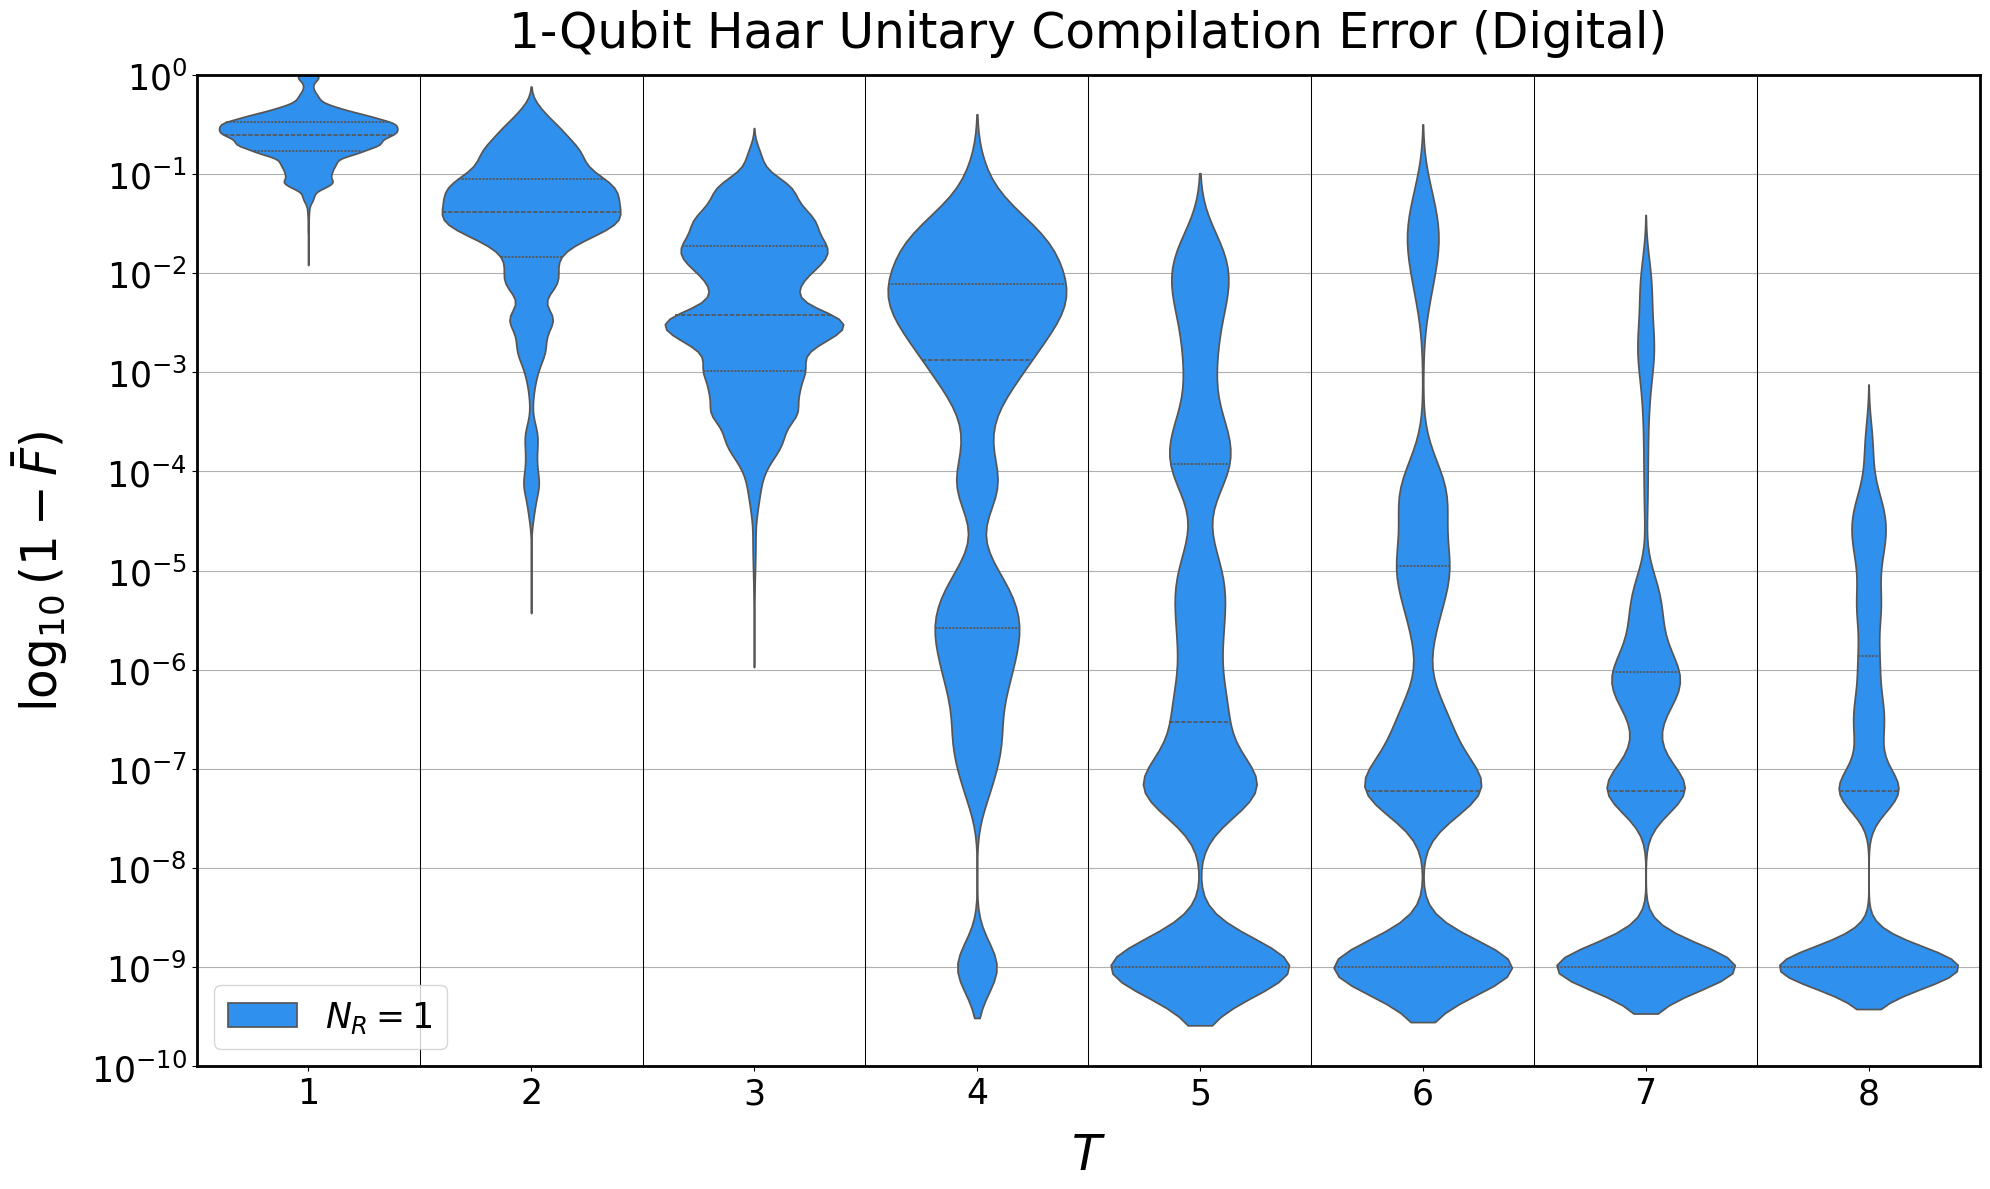

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_69411/818974388.py:90: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.violinplot(x='Trotter_Step', y='Error Test Results', hue='Reservoir Count', data=test_results_df,


[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.]


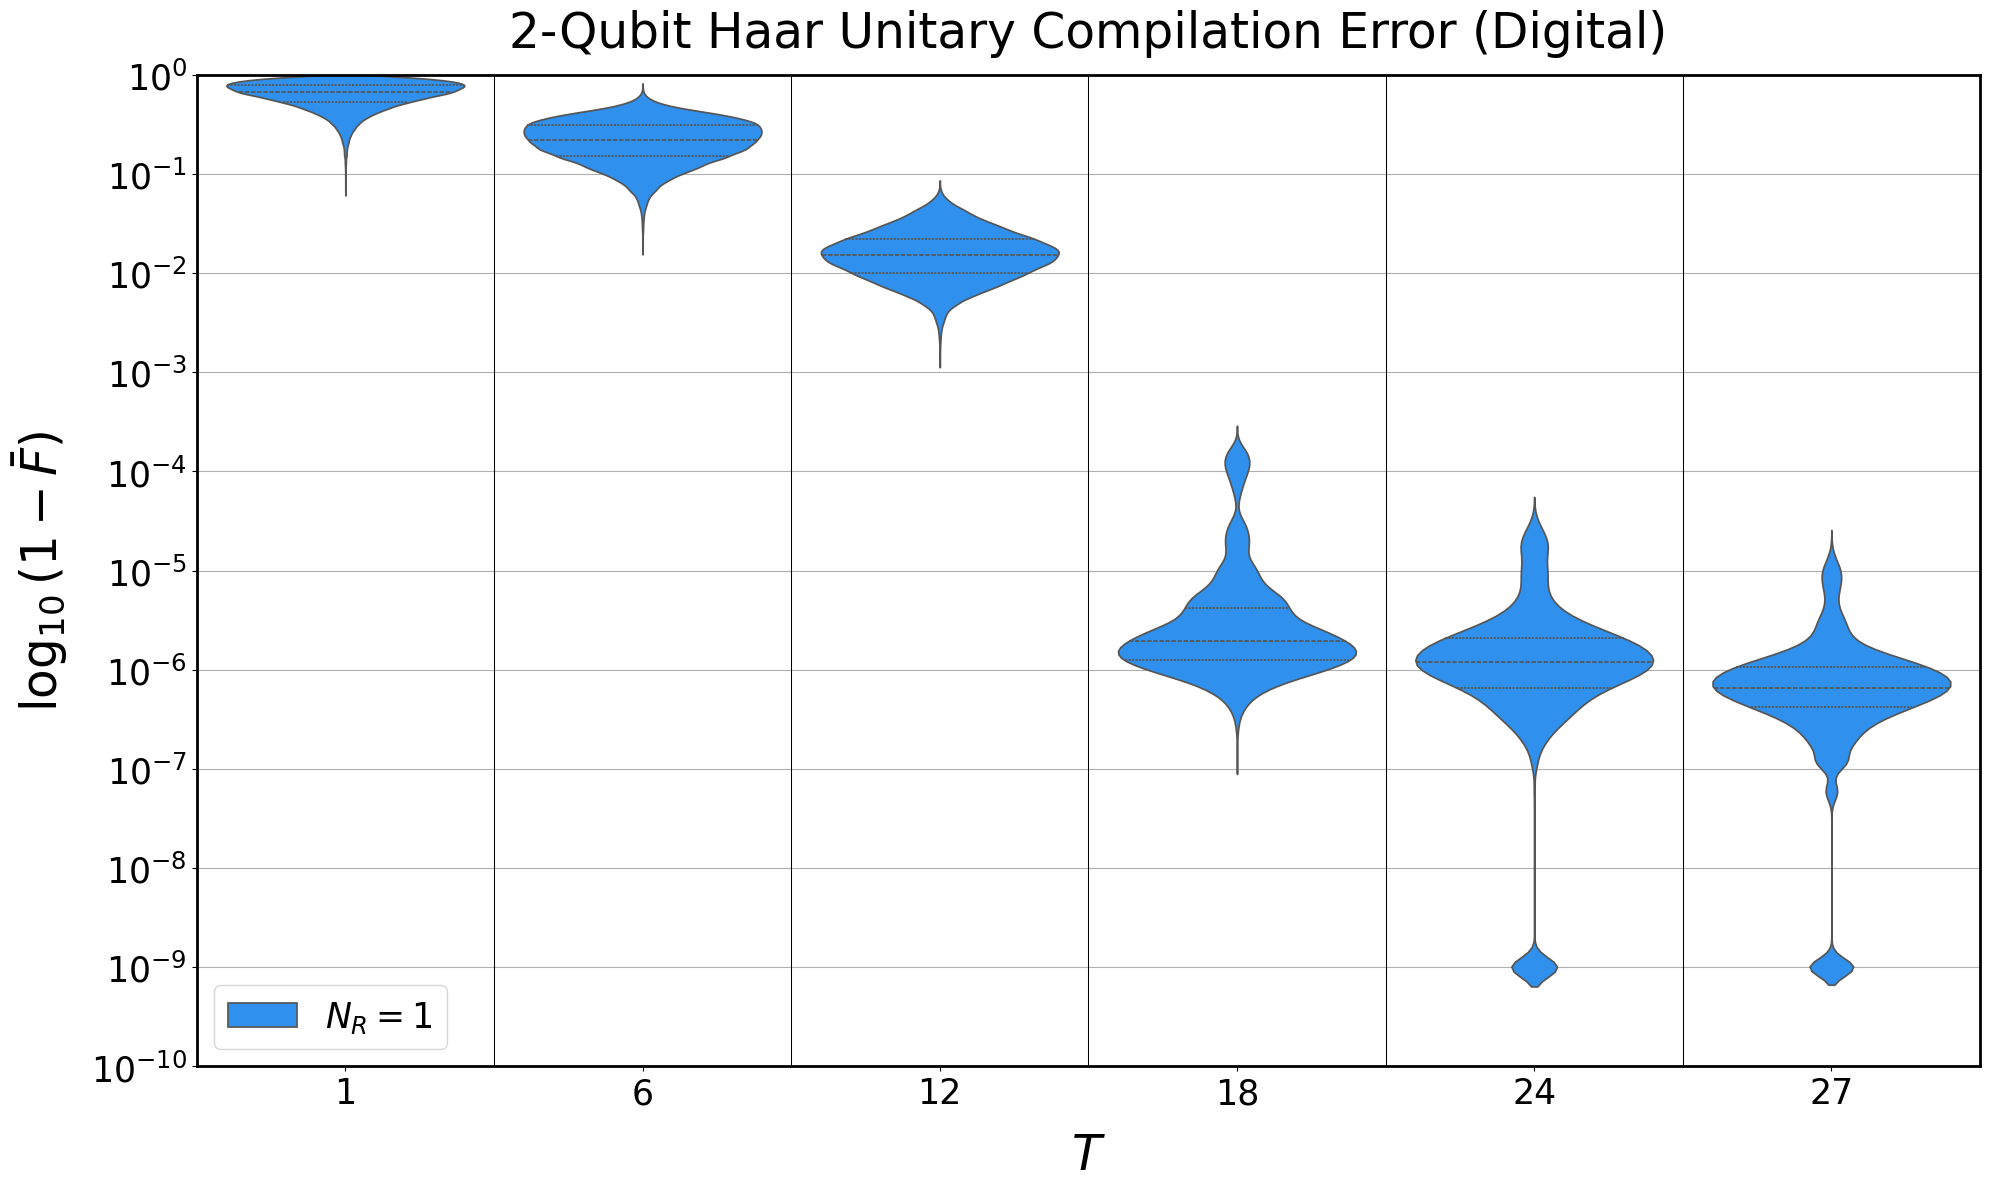

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Initialize variables to store global min and max y-values
global_min_y = float('inf')
global_max_y = float('-inf')
global_min_fidelity = float('inf')
global_max_fidelity = float('-inf')

custom_palette = ['dodgerblue', 'gold', 'violet'] 
plt.close('all')  # Close previous figures to avoid conflicts
N_ctrls = [1,2]
resies = [1,4,5,6,7,8,9]
resies = [1]
for N_ctrl in N_ctrls:
    
    if N_ctrl == 2:
        trots = [1, 10, 11, 12, 13, 14, 16, 17,18, 20, 22, 24, 26, 28]
        trots = np.arange(1, 50, 1)
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8]
    else:
        trots = np.arange(1, 50, 1)

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))]

    # Aggregate average fidelity by Trotter_Step and Reservoir Count
    aggregated_fidelity = data_df.groupby(['Trotter_Step', 'Reservoir Count'])['Avg_Fidelity'].mean().reset_index()

    # Get the min and max fidelity from aggregated results
    current_min_fidelity = aggregated_fidelity['Avg_Fidelity'].min()
    current_max_fidelity = aggregated_fidelity['Avg_Fidelity'].max()

    # Explode test results into separate rows to plot each error individually
    test_results_df_error = data_df.explode('Error_Test_Results').dropna(subset=['Error_Test_Results'])

    # Get min and max y-values for the current N_ctrl (log-error test results)
    current_min_y = test_results_df_error['Error_Test_Results'].min()
    current_max_y = test_results_df_error['Error_Test_Results'].max()

    # Update global min/max values
    global_min_y = min(global_min_y, current_min_y)
    global_max_y = max(global_max_y, current_max_y)
    global_min_fidelity = min(global_min_fidelity, current_min_fidelity)
    global_max_fidelity = max(global_max_fidelity, current_max_fidelity)

# Add a slight margin to avoid cutoff on the plot
margin_factor = 0.1
global_min_y -= margin_factor * abs(global_min_y)
global_max_y += margin_factor * abs(global_max_y)

print(f"global_min_y: {global_min_y}, global_max_y: {global_max_y}")
print(f"global_min_fidelity: {global_min_fidelity}, global_max_fidelity: {global_max_fidelity}")

# Now that we have the global y-limits, we can proceed to plotting
for N_ctrl in N_ctrls:
    if N_ctrl == 2:
        trots = [1, 6, 8,10, 12,13,14, 16, 18,20,22,24,25,26,27,28]
        # trots = [1,2,3,4,5,6]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8,9,10]

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['Trotter_Step'].isin(trots)]
    data_df = data_df[data_df['Reservoir Count'].isin(resies)]

    # Explode test results into separate rows to plot each error individually
    test_results_df = data_df.explode('Error_Test_Results')

    # Find the common Trotter steps across all reservoir counts
    grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'Reservoir Count']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # Filter the DataFrame to only include those Trotter steps
    test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

    # Drop rows with NaN values in 'Error_Test_Results' to avoid errors
    test_results_df = test_results_df.dropna(subset=['Error_Test_Results'])

    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(20, 12))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    # Violin plot for Error_Test_Results (log10(1 - Test Results))
    sns.violinplot(x='Trotter_Step', y='Error_Test_Results', hue='Reservoir Count', data=test_results_df, 
                   ax=axs, palette=custom_palette, density_norm='width', inner='quartile', saturation=0.85)

    # Set titles and labels with padding
    # axs.set_title(f"$\\log_{{10}}(1 - \\bar{{F}}) \\, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$", fontsize=30, pad=20)
    axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Digital)", fontsize=35, pad=20)
    
    axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding


    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)

    # Set the global Y-limits
    axs.set_ylim(global_min_y, global_max_y)

    # Set Y-ticks and labels
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    min_tick = min(whole_y_ticks)
    max_tick = max(whole_y_ticks)
    whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
    print(whole_y_ticks)
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set tick parameters
    axs.tick_params(axis='y', labelsize=25)
    axs.tick_params(axis='x', labelsize=25)

    # Add vertical lines to separate groups
    unique_trotter_steps = test_results_df['Trotter_Step'].unique()
    positions = range(1, len(unique_trotter_steps), 1)
    for pos in positions:
        axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

    # Prevent clipping of y-axis ticks/labels
    # plt.tight_layout(pad=3.0)
    # plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

    # Show the plot for the current N_ctrl
    plt.tight_layout()
    plt.show()



In [114]:
25//2

12

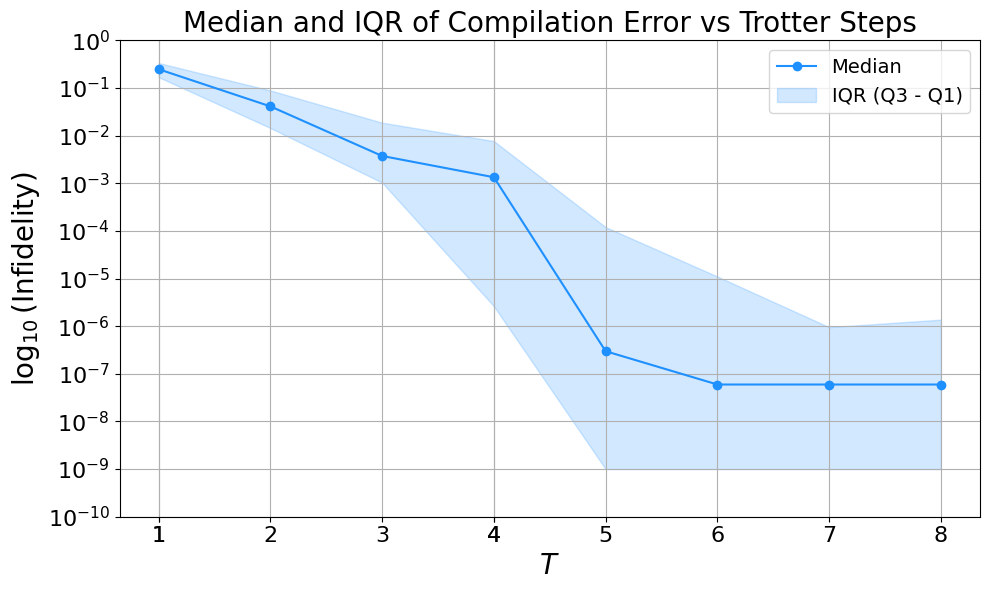

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to compute median and IQR for each Trotter step
def compute_error_statistics(data_df):
    statistics = {}
    grouped = data_df.groupby('Trotter_Step')['infidelities']  # Use 'infidelities' column in linear scale
    for trotter_step, values in grouped:
        exploded_values = values.explode().dropna()  # Explode lists into individual values
        if not exploded_values.empty:
            median = np.median(exploded_values)
            q1 = np.percentile(exploded_values, 25)  # 25th percentile
            q3 = np.percentile(exploded_values, 75)  # 75th percentile
            statistics[trotter_step] = (median, q1, q3)
    return statistics

# Function to plot median with IQR as a shaded region and log scale applied after
def plot_error_with_iqr(data_df, N_ctrl,N_R, xlabel, ylabel, title):
    # Filter data for the specific N_ctrl
    # filtered_df = data_df[data_df['N_C'] == N_ctrl]
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)]

    # Compute statistics (in linear scale)
    statistics = compute_error_statistics(filtered_df)

    # Prepare data for plotting (apply log scale after)
    trotter_steps = sorted(statistics.keys())
    medians = [np.log10(median) for median, _, _ in statistics.values()]
    q1 = [np.log10(q1) for _, q1, _ in statistics.values()]
    q3 = [np.log10(q3) for _, _, q3 in statistics.values()]

    # Plot median and IQR
    fig, axs = plt.subplots(figsize=(10, 6))
    axs.plot(trotter_steps, medians, label='Median', marker='o', color='dodgerblue')
    axs.fill_between(trotter_steps, q1, q3, color='dodgerblue', alpha=0.2, label='IQR (Q3 - Q1)')
    num_ticks = 10  # Adjust this for more or fewer ticks
    x_ticks = np.linspace(min(trotter_steps), max(trotter_steps), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])
    # Customize y-axis ticks with scientific notation
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Add labels and title
    axs.set_xlabel(xlabel, fontsize=20)
    axs.set_ylabel(ylabel, fontsize=20)
    axs.set_title(title, fontsize=20)
    axs.legend(fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=16)  # Larger tick labels
    axs.grid(True)

    plt.tight_layout()
    plt.show()

# Example Usage:
# Replace `N_ctrl` with the specific control qubit count you want to plot
plot_error_with_iqr(
    data_df=all_data_df,
    N_ctrl=1,
    N_R = 1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps'
)



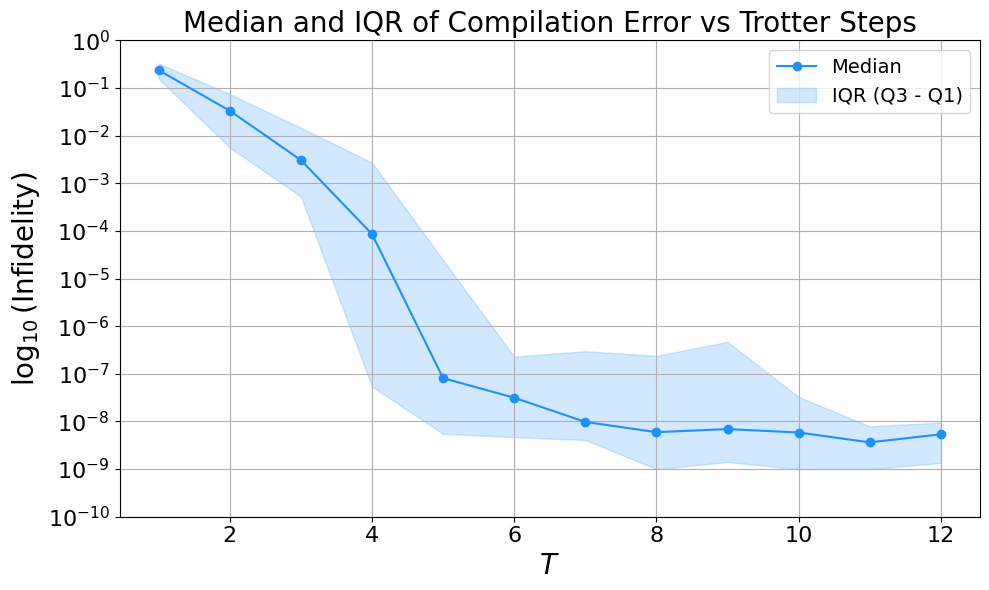

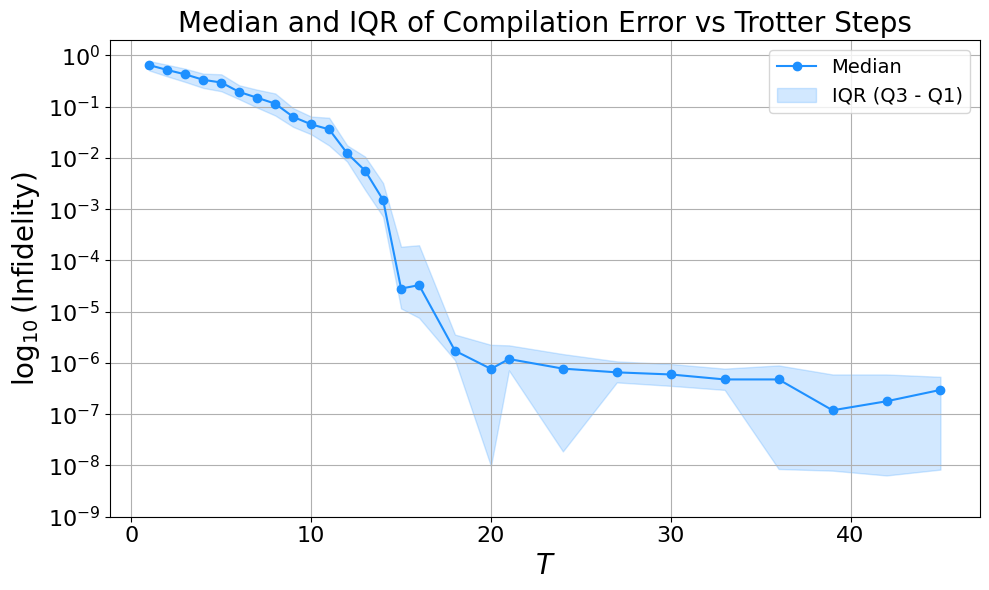

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to compute median and IQR for each Trotter step
def compute_error_statistics(data_df):
    statistics = {}
    grouped = data_df.groupby('Trotter_Step')['infidelities']  # Use 'infidelities' column in linear scale
    for trotter_step, values in grouped:
        exploded_values = values.explode().dropna()  # Explode lists into individual values
        if not exploded_values.empty:
            median = np.median(exploded_values)
            q1 = np.percentile(exploded_values, 25)  # 25th percentile
            q3 = np.percentile(exploded_values, 75)  # 75th percentile
            statistics[trotter_step] = (median, q1, q3)
    return statistics

# Function to plot median with IQR as a shaded region and log scale applied after
def plot_error_with_iqr(data_df, N_ctrl,N_R, xlabel, ylabel, title):
    # Filter data for the specific N_ctrl
    # filtered_df = data_df[data_df['N_C'] == N_ctrl]
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)]

    # Compute statistics (in linear scale)
    statistics = compute_error_statistics(filtered_df)

    # Prepare data for plotting (apply log scale after)
    trotter_steps = sorted(statistics.keys())
    medians = [np.log10(median) for median, _, _ in statistics.values()]
    q1 = [np.log10(q1) for _, q1, _ in statistics.values()]
    q3 = [np.log10(q3) for _, _, q3 in statistics.values()]

    # Plot median and IQR
    fig, axs = plt.subplots(figsize=(10, 6))
    axs.plot(trotter_steps, medians, label='Median', marker='o', color='dodgerblue')
    axs.fill_between(trotter_steps, q1, q3, color='dodgerblue', alpha=0.2, label='IQR (Q3 - Q1)')

    # Customize y-axis ticks with scientific notation
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Add labels and title
    axs.set_xlabel(xlabel, fontsize=20)
    axs.set_ylabel(ylabel, fontsize=20)
    axs.set_title(title, fontsize=20)
    axs.legend(fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=16)  # Larger tick labels
    axs.grid(True)

    plt.tight_layout()
    plt.show()

# Example Usage:
# Replace `N_ctrl` with the specific control qubit count you want to plot
plot_error_with_iqr(
    data_df=all_data_df,
    N_ctrl=1,
    N_R = 1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps'
)


# Example Usage:
# Replace `N_ctrl` with the specific control qubit count you want to plot
plot_error_with_iqr(
    data_df=all_data_df,
    N_ctrl=2,
    N_R = 1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps'
)


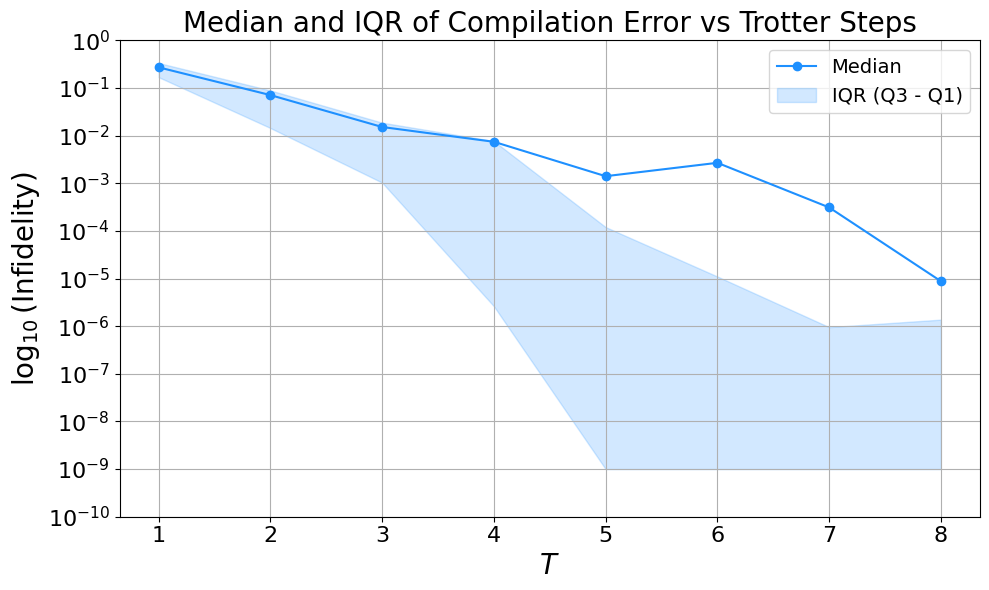

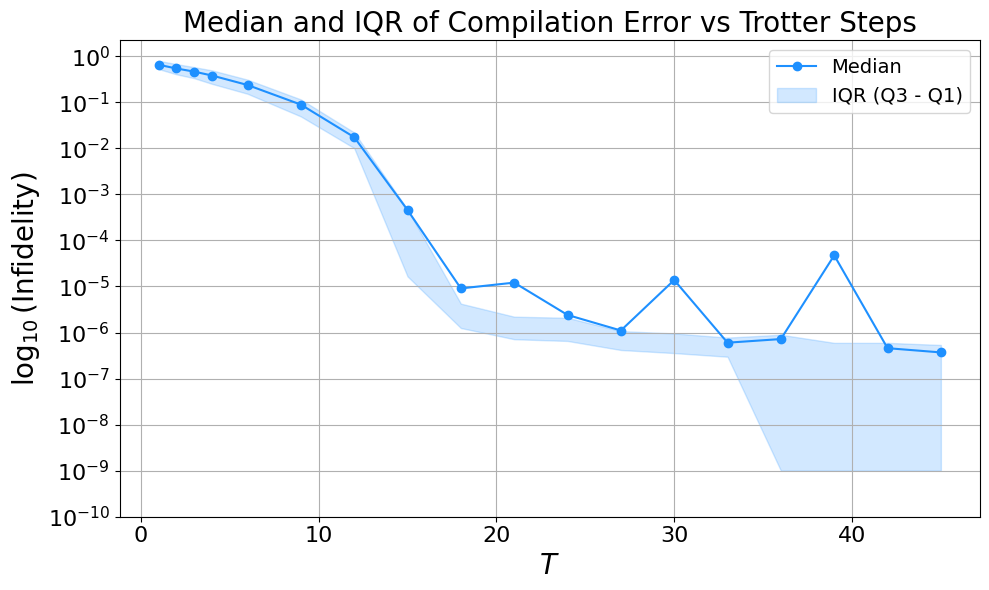

In [39]:
# Function to compute median and IQR for each Trotter step
def compute_error_statistics(data_df):
    statistics = {}
    grouped = data_df.groupby('Trotter_Step')['infidelities']  # Use 'infidelities' column in linear scale
    for trotter_step, values in grouped:
        exploded_values = values.explode().dropna()  # Explode lists into individual values
        if not exploded_values.empty:
            median = np.mean(exploded_values)
            q1 = np.percentile(exploded_values, 25)  # 25th percentile
            q3 = np.percentile(exploded_values, 75)  # 75th percentile
            statistics[trotter_step] = (median, q1, q3)
    return statistics

# Function to plot median with IQR as a shaded region and log scale applied after
def plot_error_with_iqr(data_df, N_ctrl,N_R, xlabel, ylabel, title):
    # Filter data for the specific N_ctrl
    # filtered_df = data_df[data_df['N_C'] == N_ctrl]
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Reservoir Count'] == N_R)]

    # Compute statistics (in linear scale)
    statistics = compute_error_statistics(filtered_df)

    # Prepare data for plotting (apply log scale after)
    trotter_steps = sorted(statistics.keys())
    medians = [np.log10(median) for median, _, _ in statistics.values()]
    q1 = [np.log10(q1) for _, q1, _ in statistics.values()]
    q3 = [np.log10(q3) for _, _, q3 in statistics.values()]

    # Plot median and IQR
    fig, axs = plt.subplots(figsize=(10, 6))
    axs.plot(trotter_steps, medians, label='Median', marker='o', color='dodgerblue')
    axs.fill_between(trotter_steps, q1, q3, color='dodgerblue', alpha=0.2, label='IQR (Q3 - Q1)')

    # Customize y-axis ticks with scientific notation
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Add labels and title
    axs.set_xlabel(xlabel, fontsize=20)
    axs.set_ylabel(ylabel, fontsize=20)
    axs.set_title(title, fontsize=20)
    axs.legend(fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=16)  # Larger tick labels
    axs.grid(True)

    plt.tight_layout()
    plt.show()

# Example Usage:
# Replace `N_ctrl` with the specific control qubit count you want to plot
plot_error_with_iqr(
    data_df=all_data_df,
    N_ctrl=1,
    N_R = 1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps'
)


# Example Usage:
# Replace `N_ctrl` with the specific control qubit count you want to plot
plot_error_with_iqr(
    data_df=all_data_df,
    N_ctrl=2,
    N_R = 1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps'
)


# Heatmap

global_min_fidelity: 0.30340537428855896, global_max_fidelity: 0.999997591972351


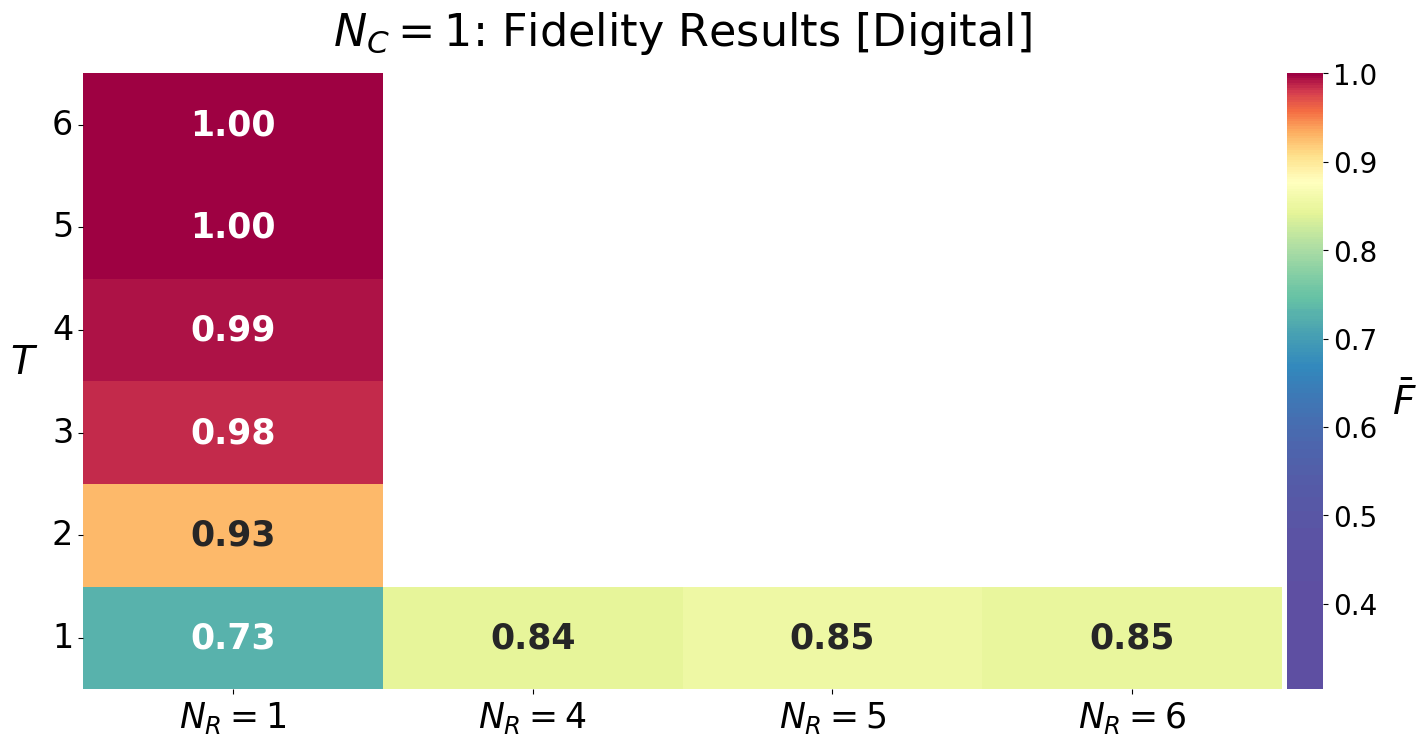

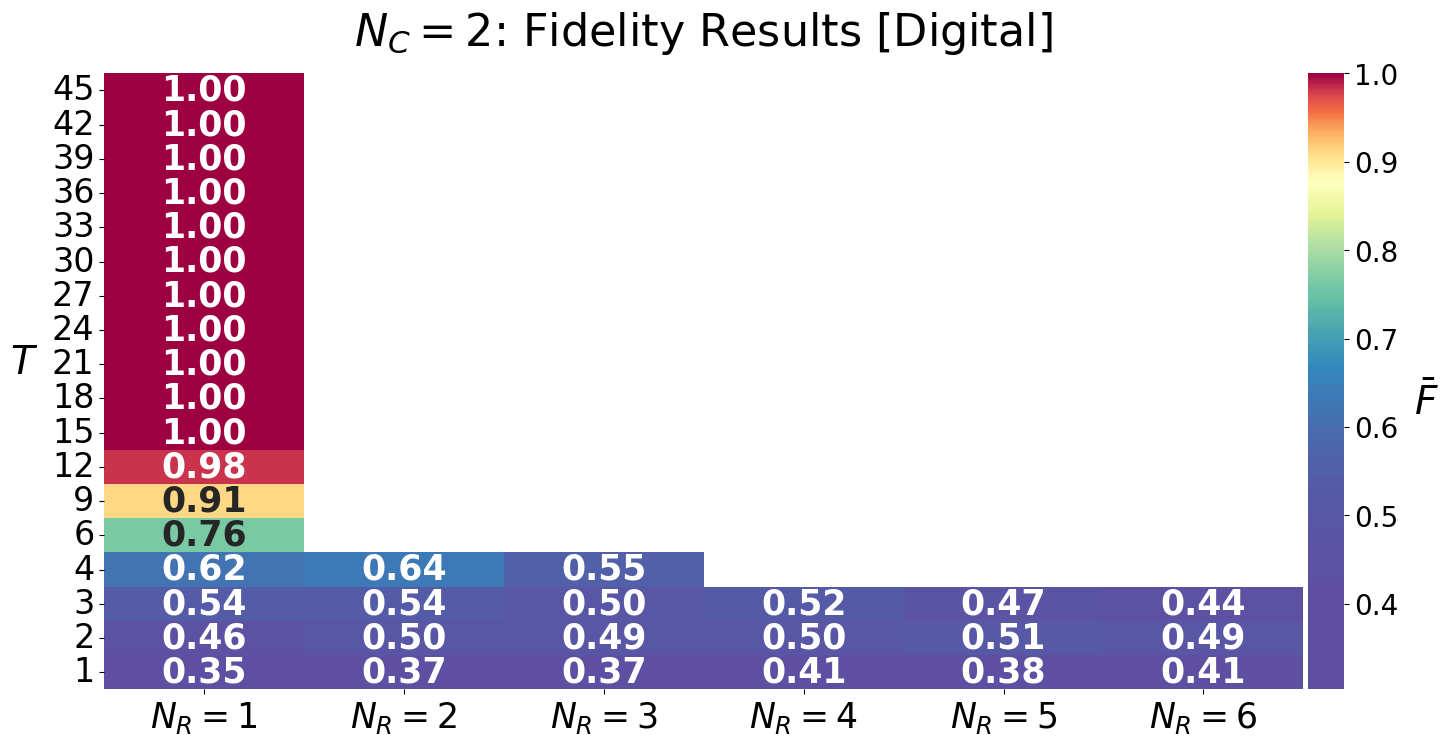

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm
width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(reservoir_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.inferno  # Base colormap for visual appeal

from matplotlib.colors import LinearSegmentedColormap
# Define custom colors
# colors = [
#     (0, 0, 0),        # Black for the minimum value
#     (0, 0, 1),        # Blue
#     (0, 1, 0),        # Green
#     (1, 1, 0),        # Yellow
#     (1, 0.65, 0),     # Orange
#     (1, 0, 0),        # Red for the maximum value
# ]

# # Modify value intervals to emphasize red
# value_intervals = [
#     global_min_fidelity,                        # Start at min fidelity
#     0.7 * global_min_fidelity + 0.3 * global_max_fidelity,  # Low range
#     0.85,                                       # Mid-high range
#     0.9,                                        # Higher fidelity
#     0.97,                                       # Near max fidelity
#     global_max_fidelity                         # Maximum fidelity
# ]

# # Normalize intervals between 0 and 1
# normalized_intervals = [
#     (val - global_min_fidelity) / (global_max_fidelity - global_min_fidelity) for val in value_intervals
# ]

# print("Normalized intervals:", normalized_intervals)

# # Create the custom colormap
# custom_colormap = LinearSegmentedColormap.from_list('nonlinear_colormap', list(zip(normalized_intervals, colors)))


base_colormap = sns.color_palette("Spectral", as_cmap=True).reversed()

N_ctrls = [1,2]

# N_ctrls = [1,2]
# global_min_fidelity *= 1.25 
print(f"global_min_fidelity: {global_min_fidelity}, global_max_fidelity: {global_max_fidelity}")
resies = [1,2,3,4,5,6]
for N_ctrl in N_ctrls:
    if N_ctrl == 3:
        trots = np.arange(1,50,1)
    elif N_ctrl == 2:
        trots = [1, 2,3,4, 6, 8, 10, 12, 14, 16, 20, 24]
        trots = np.arange(1,50,1)
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5,6]

    # Filter data for the current N_ctrl and specific Trotter steps
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))  & (all_data_df['Reservoir Count'].isin(resies))]

    # Compute average fidelity and standard deviation for each Trotter step and Reservoir Count
    averaged_data = data_df.groupby(['Trotter_Step', 'Reservoir Count']).agg(
        Average_Fidelity=('Avg_Fidelity', 'mean'),
        Std_Dev=('Avg_Fidelity', 'std')
    ).reset_index()

    # Pivot the data for the heatmap
    pivot_avg = averaged_data.pivot(index="Trotter_Step", columns="Reservoir Count", values="Average_Fidelity")
    pivot_std = averaged_data.pivot(index="Trotter_Step", columns="Reservoir Count", values="Std_Dev")

    # Create annotation matrix for Average Fidelity heatmap
    annotation_matrix_avg = pivot_avg.map("{:.2f}".format)

    # Define the custom colormap
    values = np.linspace(global_min_fidelity**2, 1, n_colors)**4
    colors = base_colormap(values)
    # custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_inferno', colors, N=n_colors)
    custom_colormap = LinearSegmentedColormap.from_list('vibrant', colors, N=n_colors)
    # Create the figure and axis for the heatmap
    fig, axs = plt.subplots(1, figsize=(16, 8))
    heatmap_ax_avg = axs

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(heatmap_ax_avg)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # Plot the average fidelity heatmap with annotations
    # sns.heatmap(
    #     pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, 
    #     ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'}, 
    #     annot_kws={"weight": "bold", "size": 14}, vmin=0.3, vmax=1.00
    # )
    sns.heatmap(
    pivot_avg, 
    annot=annotation_matrix_avg, 
    fmt="s", 
    cmap=custom_colormap, 
    ax=heatmap_ax_avg, 
    cbar_ax=cax, 
    cbar_kws={'label': 'Fidelity'}, 
    annot_kws={"weight": "bold", "size": 25}, 
     vmin=global_min_fidelity, vmax=1.0
    # norm=PowerNorm(gamma=0.5, vmin=global_min_fidelity, vmax=1.0)  # Adjust gamma (e.g., 0.5 for more contrast in low range)
)

    # Adjust the color bar
    cbar = heatmap_ax_avg.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\bar{F}$', rotation=0, labelpad=20, fontsize=28, weight='bold')

    # Customize the plot appearance
    heatmap_ax_avg.invert_yaxis()
    heatmap_ax_avg.set_title(f'$N_{{C}} = {N_ctrl}$: Fidelity Results [Digital]', fontsize=32, pad=20)
    heatmap_ax_avg.set_ylabel("$T$", labelpad=20, fontsize=28, rotation=0)
    heatmap_ax_avg.set_xticklabels([f'$N_R = {int(rc)}$' for rc in pivot_avg.columns], fontweight='bold', fontsize=25, rotation=0)
    heatmap_ax_avg.set_yticklabels([int(ts) for ts in pivot_avg.index], fontsize=24, rotation=0)
    heatmap_ax_avg.set_xlabel('')

    plt.show()

global_min_fidelity: 0.7606627225875855, global_max_fidelity: 0.9987784266471863


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_57073/81960604.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix_avg = pivot_num_params.applymap("{:.0f}".format)  # Ensures integer formatting


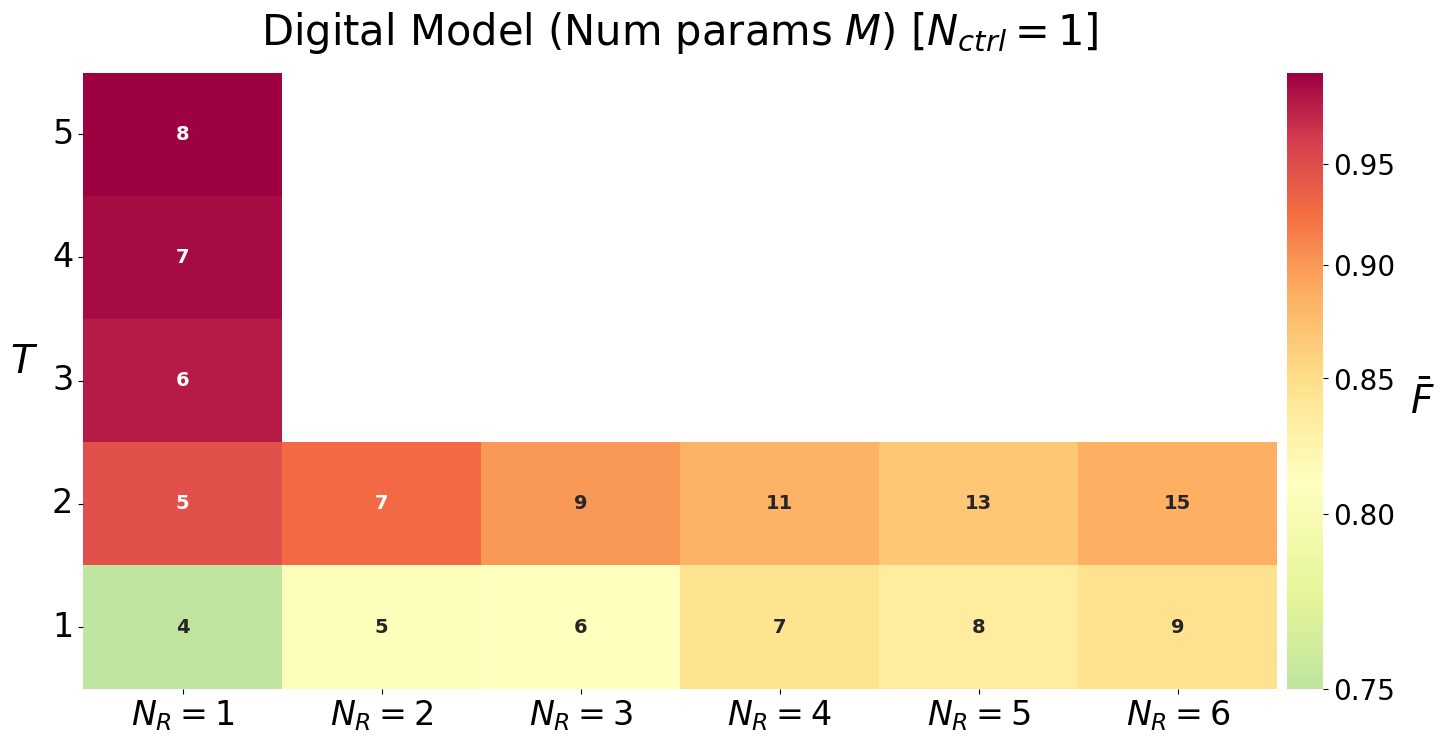

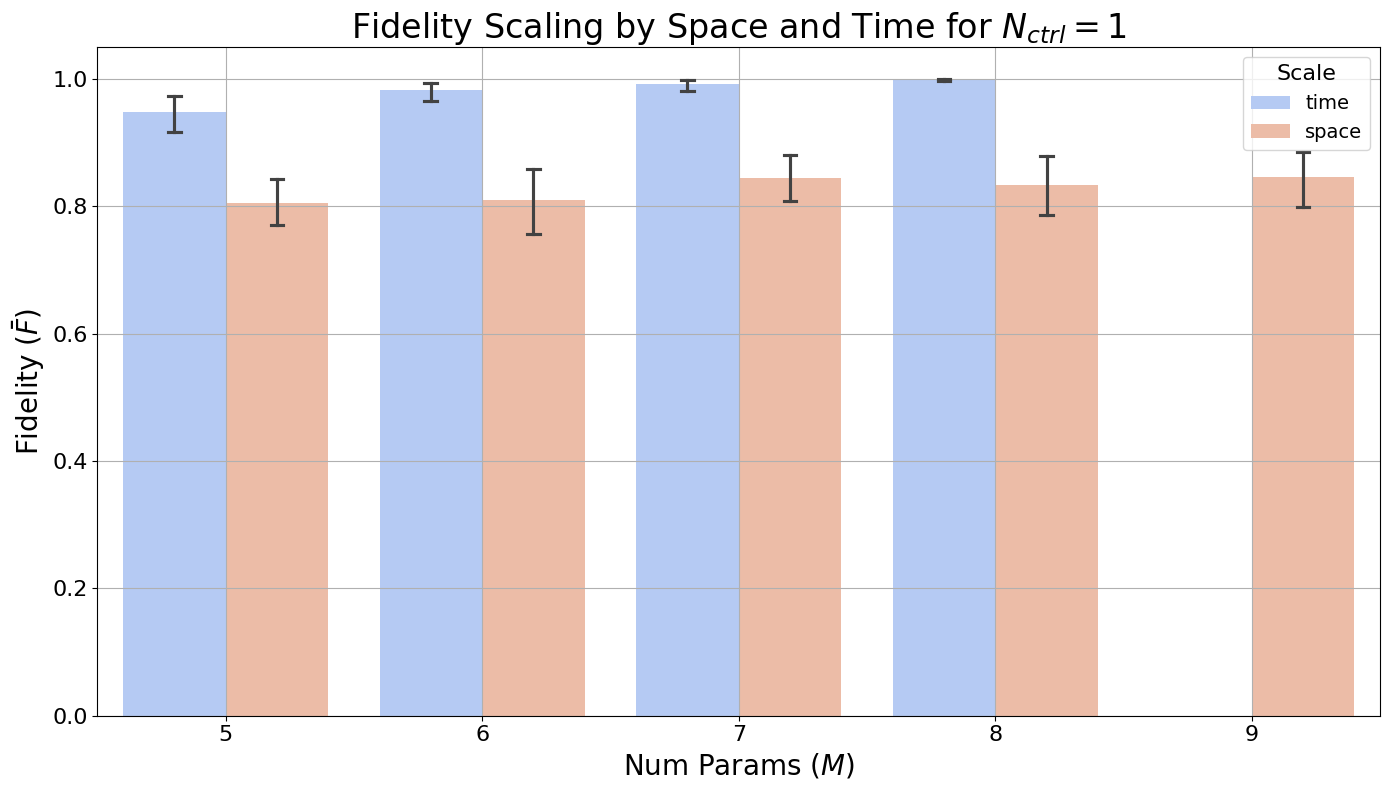

[-14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.
   0.]


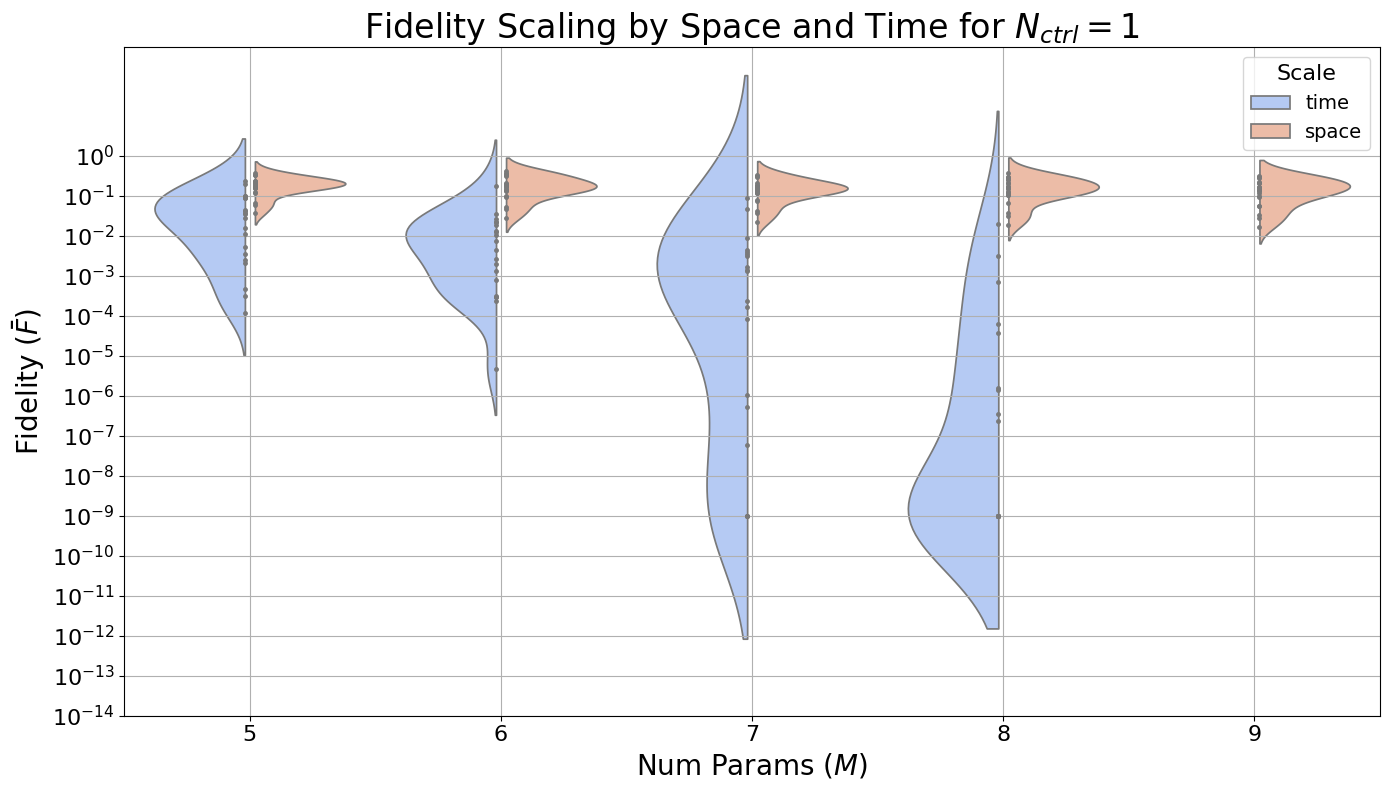

[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.]


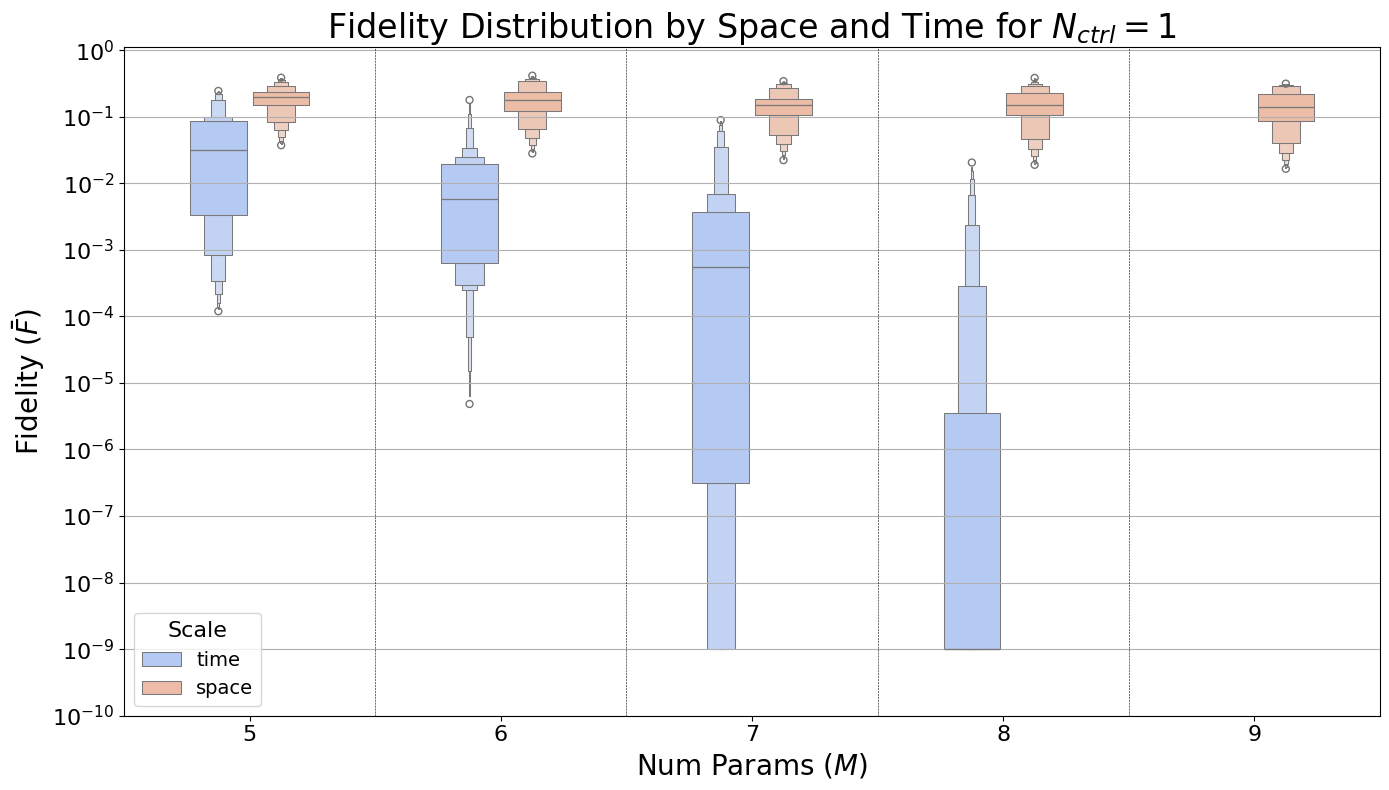

In [185]:

N_ctrls = [1]
# global_min_fidelity *= 1.25 
print(f"global_min_fidelity: {global_min_fidelity}, global_max_fidelity: {global_max_fidelity}")
N_ctrl == 1

if N_ctrl == 3:
    trots = np.arange(1,50,1)
elif N_ctrl == 2:
    trots = [1, 2,3,4, 6, 8, 10, 12, 14, 16, 20, 24]
elif N_ctrl == 1:
    trots = [1, 2, 3, 4, 5,6,7,8,9,10]

# Filter data for the current N_ctrl and specific Trotter steps
data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))]

# Compute average fidelity and standard deviation for each Trotter step and Reservoir Count
averaged_data = data_df.groupby(['Trotter_Step', 'Reservoir Count', 'N_params']).agg(
    Average_Fidelity=('Avg_Fidelity', 'mean'),
    Std_Dev=('Avg_Fidelity', 'std')
).reset_index()

# Pivot the data for the heatmap
pivot_avg = averaged_data.pivot(index="Trotter_Step", columns="Reservoir Count", values="Average_Fidelity")
pivot_std = averaged_data.pivot(index="Trotter_Step", columns="Reservoir Count", values="Std_Dev")
pivot_num_params = averaged_data.pivot(index="Trotter_Step", columns="Reservoir Count", values="N_params")

annotation_matrix_avg = pivot_num_params.applymap("{:.0f}".format)  # Ensures integer formatting



# # Create annotation matrix for Average Fidelity heatmap
# annotation_matrix_avg = pivot_avg.map("{:.4f}".format)

# Define the custom colormap
values = np.linspace(global_min_fidelity, 1, n_colors)**4
colors = base_colormap(values)
# custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_inferno', colors, N=n_colors)
custom_colormap = LinearSegmentedColormap.from_list('vibrant', colors, N=n_colors)
# Create the figure and axis for the heatmap
fig, axs = plt.subplots(1, figsize=(16, 8))
heatmap_ax_avg = axs

# Create a divider for the existing axes instance
divider = make_axes_locatable(heatmap_ax_avg)
cax = divider.append_axes("right", size="3%", pad=0.1)

# Plot the average fidelity heatmap with annotations
# sns.heatmap(
#     pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, 
#     ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'}, 
#     annot_kws={"weight": "bold", "size": 14}, vmin=0.3, vmax=1.00
# )
sns.heatmap(
pivot_avg, 
annot=annotation_matrix_avg, 
fmt="s", 
cmap=custom_colormap, 
ax=heatmap_ax_avg, 
cbar_ax=cax, 
cbar_kws={'label': 'Fidelity'}, 
annot_kws={"weight": "bold", "size": 14}, 
#  vmin=global_min_fidelity, vmax=1.0
norm=PowerNorm(gamma=0.7, vmin=global_min_fidelity, vmax=global_max_fidelity)  # Adjust gamma (e.g., 0.5 for more contrast in low range)
)

# Adjust the color bar
cbar = heatmap_ax_avg.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r'$\bar{F}$', rotation=0, labelpad=20, fontsize=28, weight='bold')

# Customize the plot appearance
heatmap_ax_avg.invert_yaxis()
heatmap_ax_avg.set_title(f'Digital Model (Num params $M$) [$N_{{ctrl}} = {N_ctrl}$]', fontsize=30, pad=20)
heatmap_ax_avg.set_ylabel("$T$", labelpad=20, fontsize=28, rotation=0)
heatmap_ax_avg.set_xticklabels([f'$N_R = {int(rc)}$' for rc in pivot_avg.columns], fontweight='bold', fontsize=24, rotation=0)
heatmap_ax_avg.set_yticklabels([int(ts) for ts in pivot_avg.index], fontsize=24, rotation=0)
heatmap_ax_avg.set_xlabel('')

plt.show()
# Plotting Fidelity vs Num Params with grouped bars

current_df = all_data_df[all_data_df['N_C'] == N_ctrl].copy()

# Add 'Scale' column based on conditions
current_df['Scale'] = 'other'  # Default
current_df.loc[current_df['Trotter_Step'] == 1, 'Scale'] = 'space'
current_df.loc[current_df['Reservoir Count'] == 1, 'Scale'] = 'time'
# Remove cases where both 'Reservoir Count == 1' and 'Trotter Step == 1'
current_df = current_df[~((current_df['Reservoir Count'] == 1) & (current_df['Trotter_Step'] == 1))]

# Keep only 'space' and 'time'
current_df = current_df[current_df['Scale'].isin(['space', 'time'])]


# Plotting grouped bar plot with error bars automatically calculated
plt.figure(figsize=(14, 8))

sns.barplot(
    data=current_df,
    x='N_params',
    y='Avg_Fidelity',
    hue='Scale',
    dodge=True,
    errorbar='ci',  # Automatically adds standard deviation as error bars
    palette='coolwarm',
    capsize=0.1  # Add caps to the error bars
)

# Customize plot appearance
plt.title('Fidelity Scaling by Space and Time for $N_{ctrl} = 1$', fontsize=24)
plt.xlabel('Num Params ($M$)', fontsize=20)
plt.ylabel('Fidelity ($\\bar{F}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Scale', fontsize=14, title_fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


# Plotting grouped bar plot with error bars automatically calculated
fig, axs = plt.subplots(1, figsize=(14, 8))
sns.violinplot(
    data=current_df,
    x='N_params',
    y='Avg Error',
    hue='Scale',
    density_norm='count', 
    inner="point",
   split = True,
   gap = 0.1,
   
    palette='coolwarm',
   
)

# Adjust y-tick labels
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]

min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
print(whole_y_ticks)
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Customize plot appearance
plt.title('Fidelity Scaling by Space and Time for $N_{ctrl} = 1$', fontsize=24)
plt.xlabel('Num Params ($M$)', fontsize=20)
plt.ylabel('Fidelity ($\\bar{F}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Scale', fontsize=14, title_fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
# Plotting boxenplot to show fidelity distribution
fig, axs = plt.subplots(1, figsize=(14, 8))

sns.boxenplot(
    data=current_df,
    x='N_params',
    y='Avg Error',
    hue='Scale',
    dodge=True,
    palette='coolwarm',
    width = .5,
    gap = 0.1,
    k_depth='proportion',  # Adjusts which quantiles are plotted
    trust_alpha=0.01,
)
unique_x_ticks = sorted(current_df['N_params'].unique()) 
positions = range(1, len(unique_x_ticks), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

# Adjust y-tick labels
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]

min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
print(whole_y_ticks)
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Customize plot appearance
plt.title('Fidelity Distribution by Space and Time for $N_{ctrl} = 1$', fontsize=24)
plt.xlabel('Num Params ($M$)', fontsize=20)
plt.ylabel('Fidelity ($\\bar{F}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Scale', fontsize=14, title_fontsize=16)
axs.yaxis.grid(True)
axs.xaxis.grid(False)
plt.tight_layout()
plt.show()

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_57073/1995295097.py:29: UserWarning: 
The palette list has fewer values (3) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(x='Trotter_Step', y='Error Test Results', hue='Reservoir Count', data=test_results_df,


[-3. -2. -1.  0.]


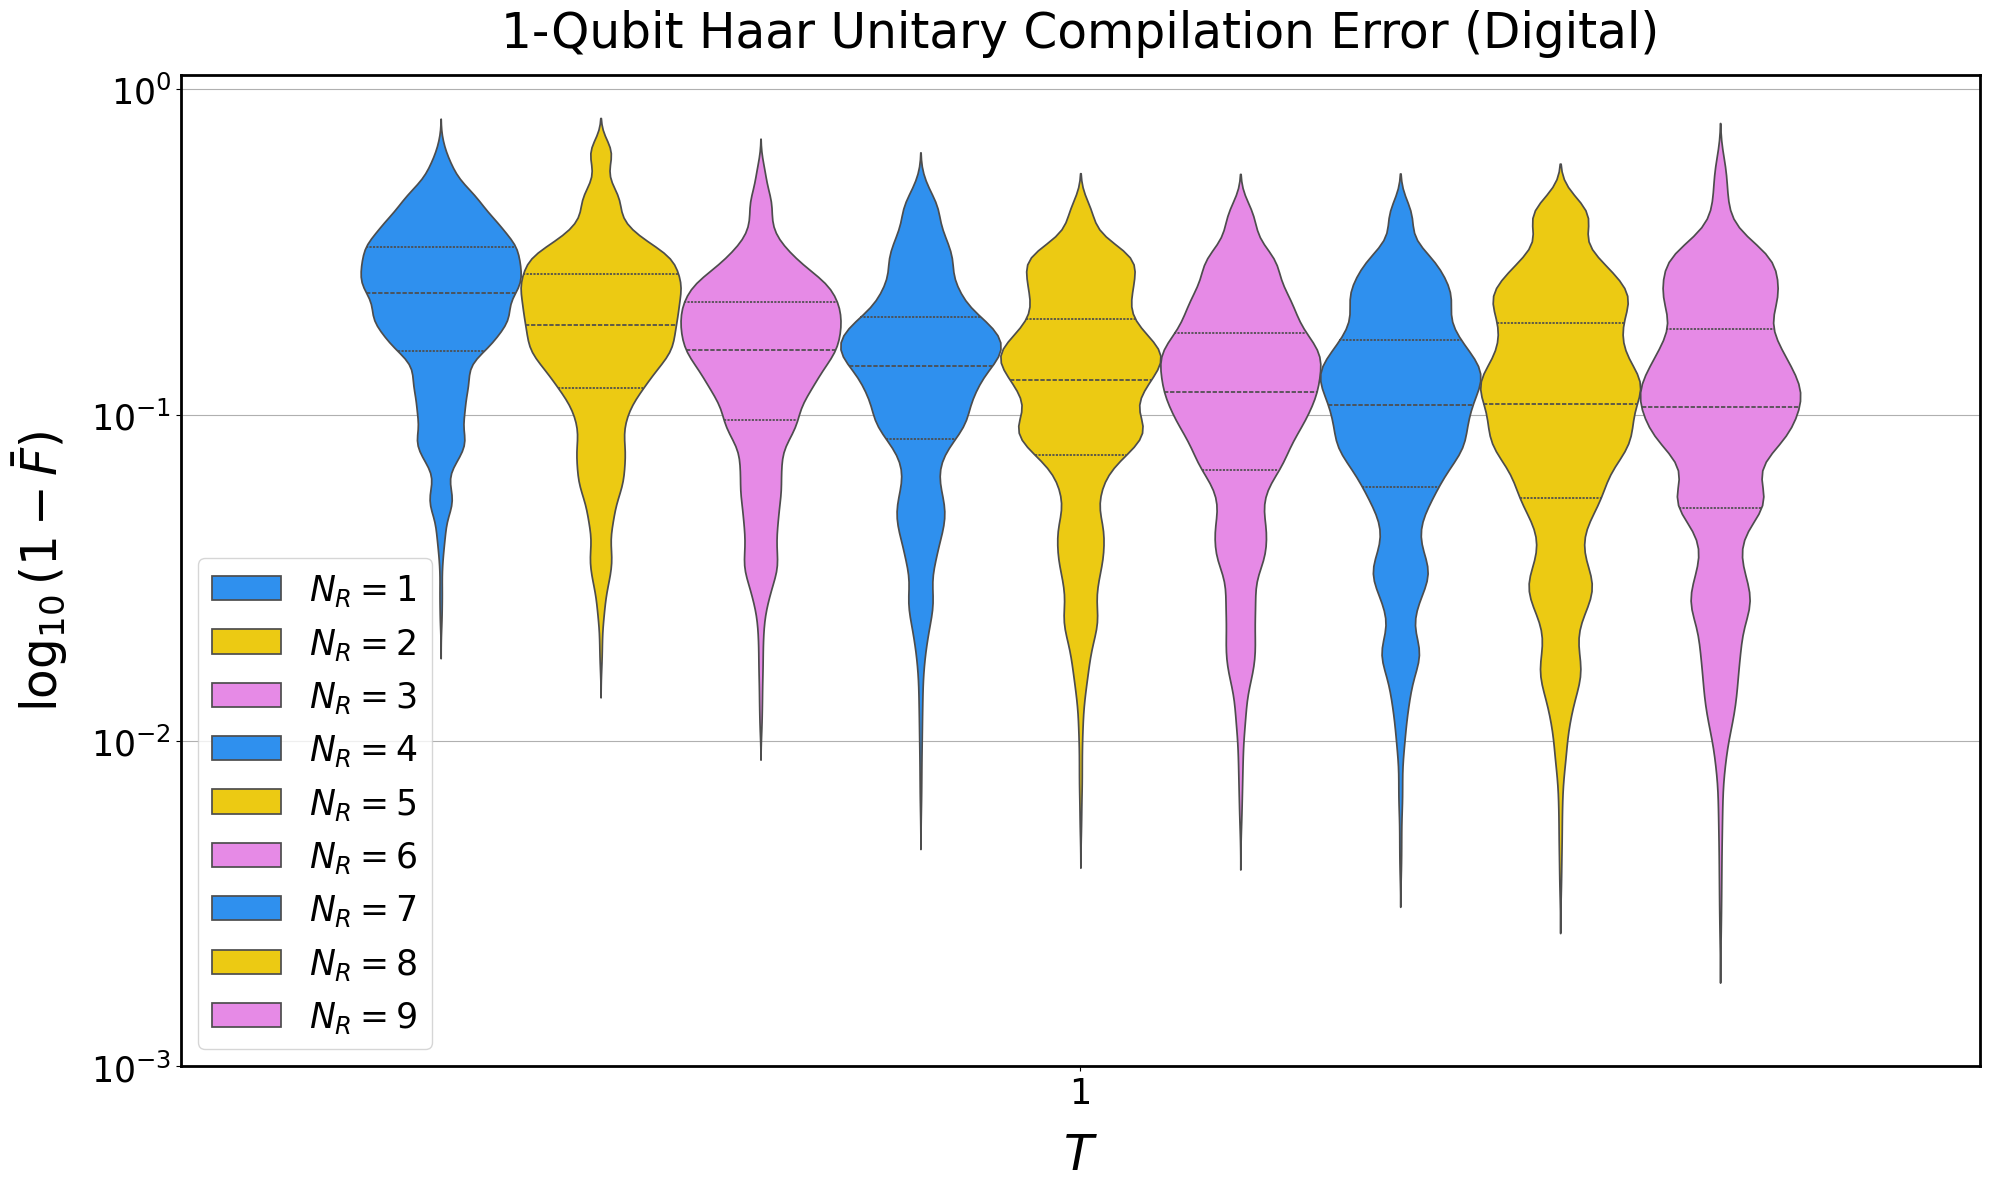

In [25]:
# Filter the DataFrame for specific N_C (control qubits)
trots = [1]
N_ctrl = 1
data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
data_df = data_df[data_df['Trotter_Step'].isin(trots)]
# data_df = data_df[data_df['Reservoir Count'].isin(resies)]

# Explode test results into separate rows to plot each error individually
test_results_df = data_df.explode('Error_Test_Results')

# Find the common Trotter steps across all reservoir counts
grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'Reservoir Count']).size().unstack(fill_value=0)
valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

# Filter the DataFrame to only include those Trotter steps
test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

# Drop rows with NaN values in 'Error_Test_Results' to avoid errors
test_results_df = test_results_df.dropna(subset=['Error_Test_Results'])

# Plot for each control qubit
fig, axs = plt.subplots(1, figsize=(20, 12))

# Set the linewidth of the outside border (spines)
for spine in axs.spines.values():
    spine.set_linewidth(2)  # Set linewidth to 2 pixels

# Violin plot for Error_Test_Results (log10(1 - Test Results))
sns.violinplot(x='Trotter_Step', y='Error_Test_Results', hue='Reservoir Count', data=test_results_df, 
                ax=axs, palette=custom_palette, density_norm='width', inner='quartile', saturation=0.85)

# Set titles and labels with padding
# axs.set_title(f"$\\log_{{10}}(1 - \\bar{{F}}) \\, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$", fontsize=30, pad=20)
axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Digital)", fontsize=35, pad=20)

axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding


# Add grid lines
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)

# Customize the legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)

# Set the global Y-limits
# axs.set_ylim(global_min_y, global_max_y)

# Set Y-ticks and labels
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
print(whole_y_ticks)
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Set tick parameters
axs.tick_params(axis='y', labelsize=25)
axs.tick_params(axis='x', labelsize=25)

# Add vertical lines to separate groups
unique_trotter_steps = test_results_df['Trotter_Step'].unique()
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

# Prevent clipping of y-axis ticks/labels
# plt.tight_layout(pad=3.0)
# plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

# Show the plot for the current N_ctrl
plt.tight_layout()
plt.show()


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_8299/3284691493.py:24: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Trotter_Step', y='Avg Error', hue='Reservoir Count', data=data_filtered,


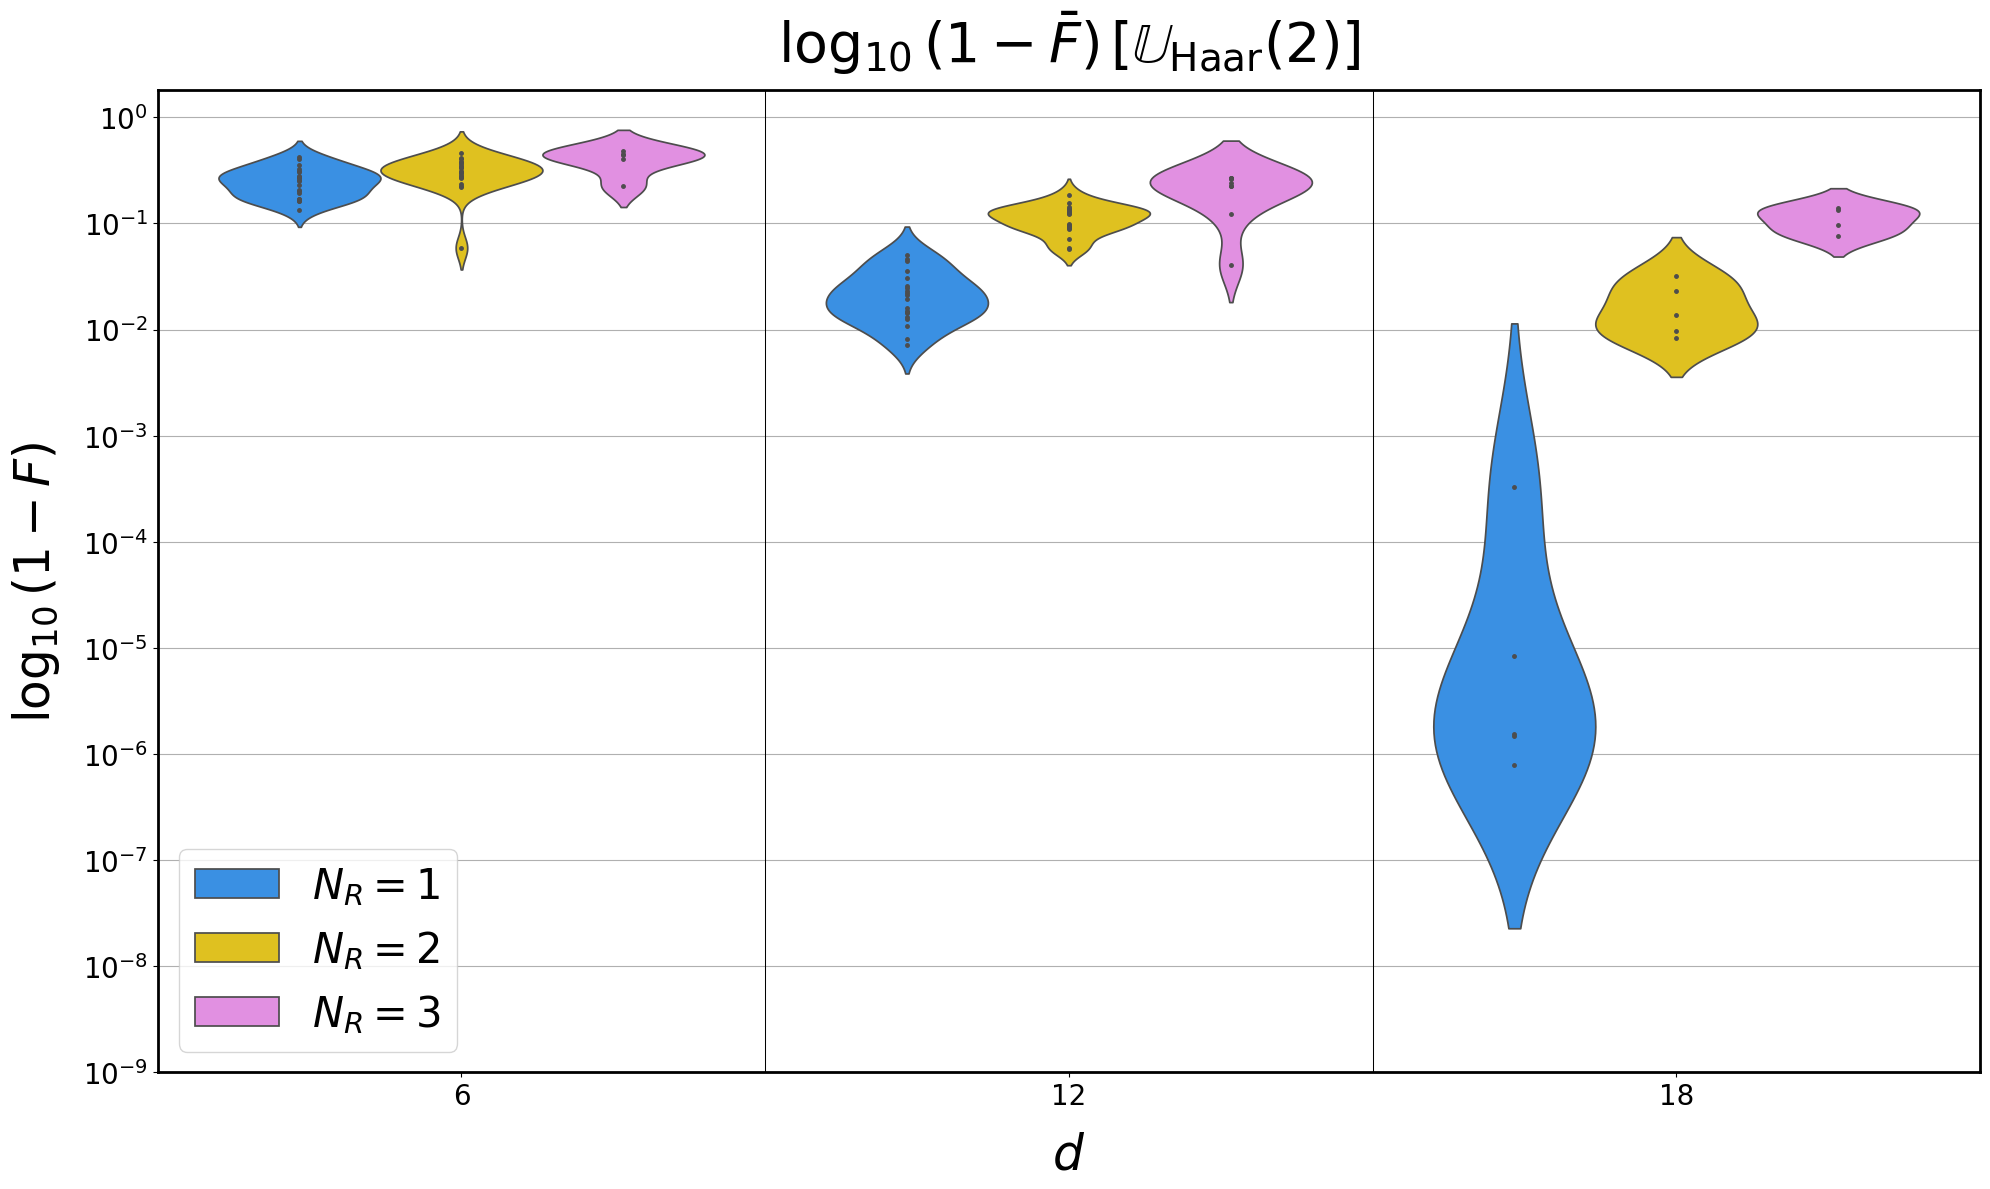

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_8299/3284691493.py:74: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Trotter_Step', y='Error Test Results', hue='Reservoir Count', data=test_results_df,


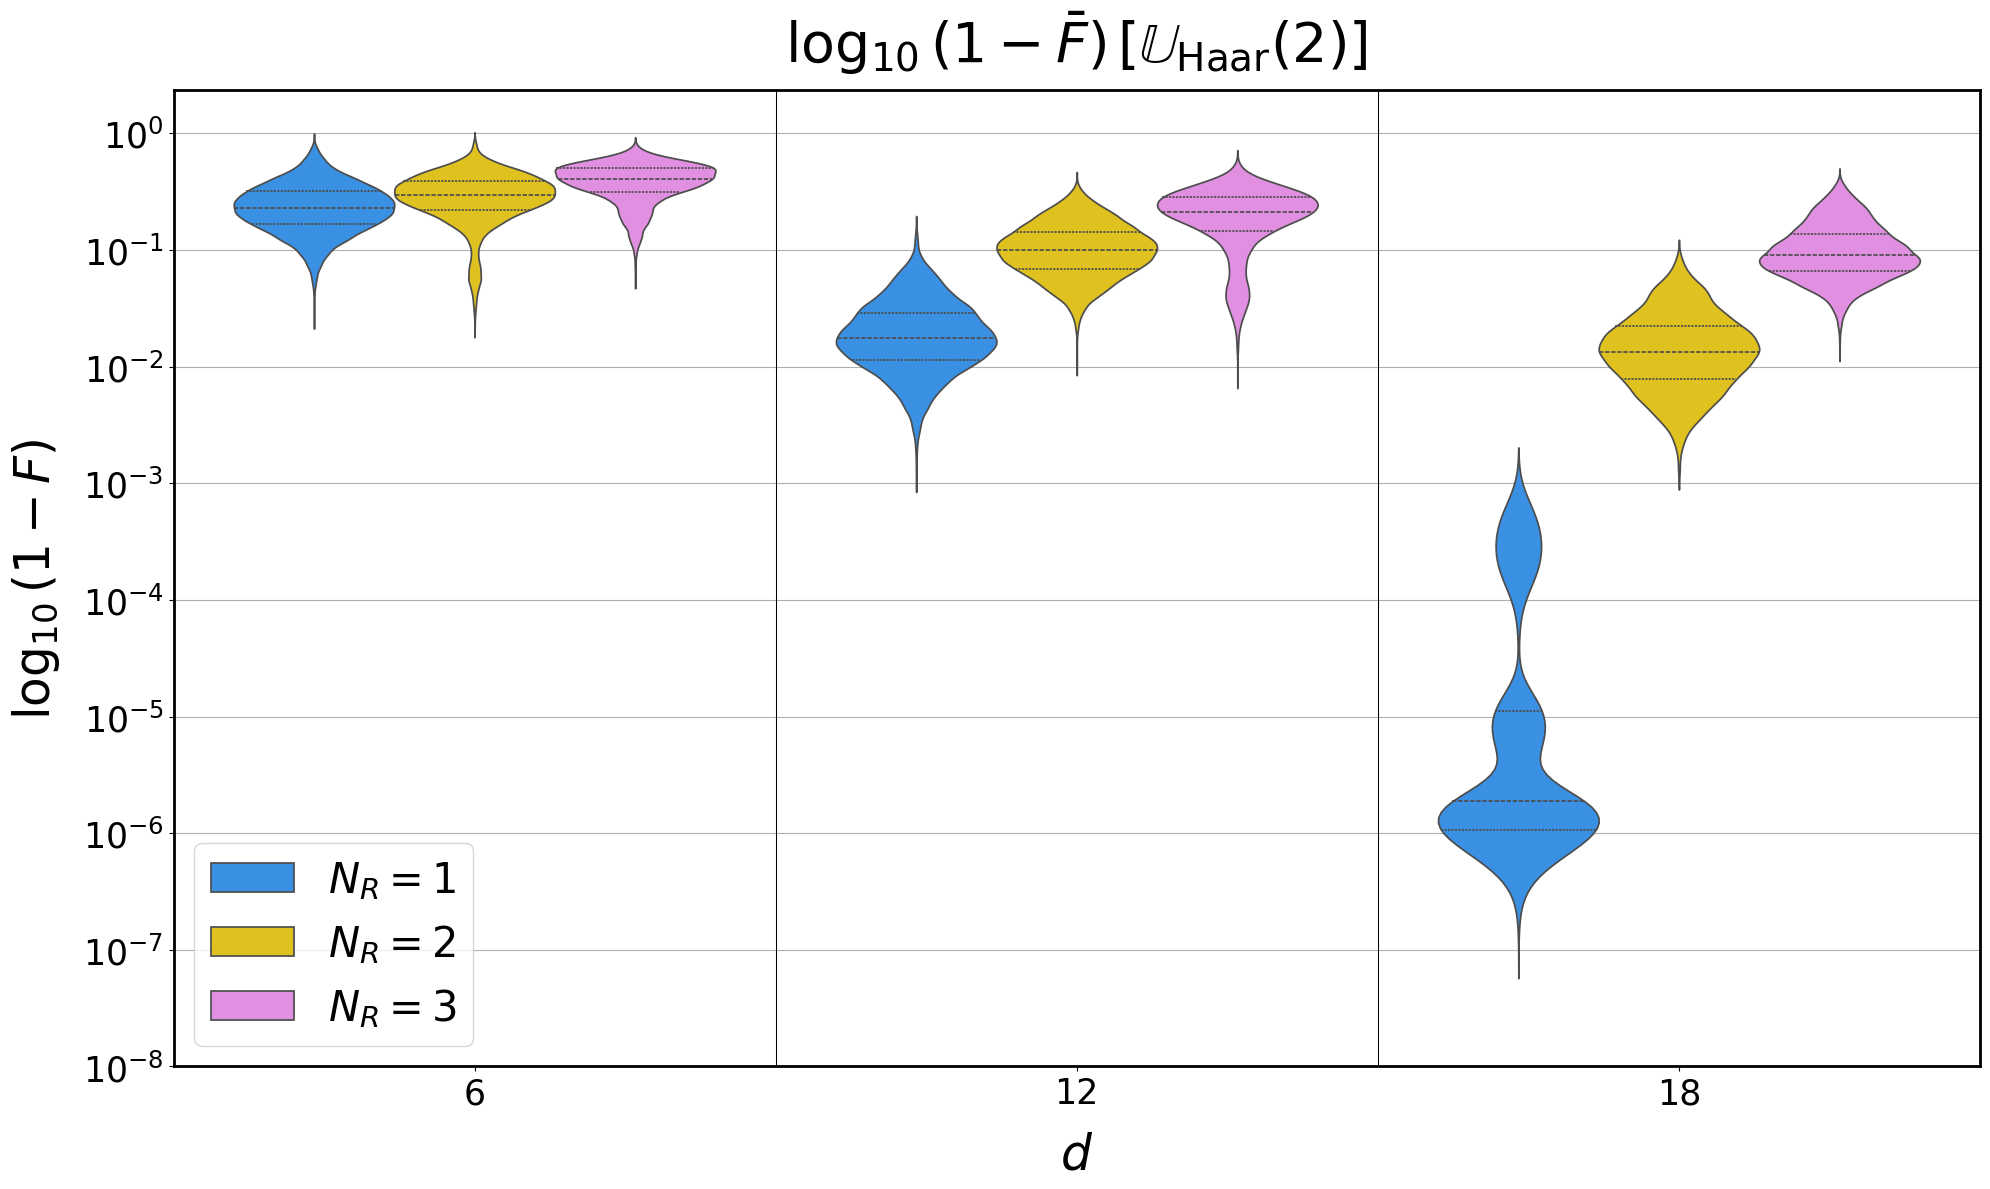

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
custom_palette = ['dodgerblue', 'gold', 'violet'] 
# Make sure to clear previous figures
plt.close('all')

# Define Trotter_Steps to Filter
trots =  [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]

# Filter the DataFrame for specific Trotter_Steps
data_filtered = data_df[data_df['Trotter_Step'].isin(trots)]

### First Violin Plot for Average Error ###

fig, axs = plt.subplots(1, figsize=(20, 12))

# Set the linewidth of the outside border (spines)
for spine in axs.spines.values():
    spine.set_linewidth(2)  # Set linewidth to 2 pixels

# Violin Plot for Average Error (log10(1 - avg_fidelity))
sns.violinplot(x='Trotter_Step', y='Avg Error', hue='Reservoir Count', data=data_filtered, 
               ax=axs, palette=custom_palette, scale='width', inner="point")

# Set titles and labels with padding
axs.set_title(r'$\log_{10}(1 - \bar{F}) \, [\mathbb{U}_{\text{Haar}}(2)]$', fontsize=40, pad=20)
axs.set_xlabel('$d$', fontsize=35, labelpad=15)  # X-axis label with padding
axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=35, labelpad=15)  # Y-axis label with padding

# Add grid lines
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)

# Customize the legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=30)

# Set Y-ticks and labels
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Set tick parameters
axs.tick_params(axis='y', labelsize=20) 
axs.tick_params(axis='x', labelsize=20) 

# Add vertical lines to separate groups
unique_trotter_steps = data_filtered['Trotter_Step'].unique()
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

# Show the plot
plt.tight_layout()
plt.show()

### Second Violin Plot for Error_Test_Results ###

# Explode test results into separate rows to plot each error individually
test_results_df = data_df.explode('Error_Test_Results')
test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(trots)]

fig, axs = plt.subplots(1, figsize=(20, 12))

# Set the linewidth of the outside border (spines)
for spine in axs.spines.values():
    spine.set_linewidth(2)  # Set linewidth to 2 pixels

# Violin plot for Error_Test_Results (log10(1 - Test Results))
sns.violinplot(x='Trotter_Step', y='Error_Test_Results', hue='Reservoir Count', data=test_results_df, 
               ax=axs, palette=custom_palette, scale='width', inner='quartile', saturation=0.75)

# Set titles and labels with padding
axs.set_title(r'$\log_{10}(1 - \bar{F}) \, [\mathbb{U}_{\text{Haar}}(2)]$', fontsize=40, pad=20)
axs.set_xlabel('$d$', fontsize=35, labelpad=15)  # X-axis label with padding
axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=35, labelpad=15)  # Y-axis label with padding

# Add grid lines
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)

# Customize the legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=30)

# Set Y-ticks and labels
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Set tick parameters
axs.tick_params(axis='y', labelsize=25) 
axs.tick_params(axis='x', labelsize=25) 

# Add vertical lines to separate groups
unique_trotter_steps = test_results_df['Trotter_Step'].unique()
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black',linewidth=0.75)

# Show the plot
plt.tight_layout()
plt.show()

### <b>N_ctrl = 3</b>

In [56]:
base_path = '/Users/sophieblock/QRCCapstone/digital_results_trainable_global/'
train_sizes = [20]
N_ctrls = [1]

data = {'1': {}}

reservoir_counts = [1]

        
for N_ctrl,train_size in zip(N_ctrls,train_sizes):
    data2 = data[str(N_ctrl)]

    gate_prefixes = [f'U{N_ctrl}']
    
    ctrl_path = os.path.join(base_path,f"trainsize_{train_size}_optimized/")
    for gate_prefix in gate_prefixes:
        
        for folder_name in sorted(os.listdir(ctrl_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name

                for bath_status in ['bath_True', 'bath_False']:
                    data2[gate] = {}
                    for subfolder in sorted(os.listdir(os.path.join(ctrl_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            
                            
                        
                            for trotter_folder in sorted(os.listdir(os.path.join(ctrl_path, gate, subfolder)), key=extract_last_number):
                                
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    trotter_path = os.path.join(ctrl_path, gate, subfolder, trotter_folder, bath_status)
                                    
                                    if not os.path.exists(trotter_path):
                                        
                                        continue
                                    files_in_folder = os.listdir(trotter_path)
                                    
                                    #if len(files_in_folder) == 0:
                                        #print(trotter_path)
                                    costs = 1
                                    infidelity = 1
                                    step = None
                                    run = None
                                    
                                    for i, file in enumerate(files_in_folder):
                                        if not file.startswith('.'):
                                            pickle_file = os.path.join(trotter_path, file)
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                costs, infidelity, total_params, test_results = read_jax_file(pickle_file, gate)
                                                if i == 0 or infidelity < data2[gate][reservoir_count][trotter_step].get('infidelity', float('inf')):
                                                    if reservoir_count not in data2[gate]:
                                                        data2[gate][reservoir_count] = {}
                                                    if trotter_step not in data2[gate][reservoir_count]:
                                                        data2[gate][reservoir_count][trotter_step] = {}
                                                    data_point = {
                                                        'costs': costs,
                                                        'infidelity': infidelity,
                                                        'test_results': test_results,
                                                        'param_count': total_params,
                                                        'run': pickle_file.split('.')[-2]
                                                    }
                                                    data2[gate][reservoir_count][trotter_step] = data_point

In [ ]:
from matplotlib.ticker import FuncFormatter
# Use test_results to compute fidelity data
fidelity_data = {}
infidelity_data = {}
custom_palette = ['dodgerblue', 'gold', 'violet'] 
N_ctrl = 1
trots = np.arange(3, 45, 1)

for gate, gate_data in data[str(N_ctrl)].items():
    for reservoir_count, trotter_data in gate_data.items():
        #if not reservoir_count in reservoir_counts:
        #    continue
        for trotter_step, results in trotter_data.items():
            #if not trotter_step in trots:
            #    continue
            fidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
            infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
            test_results = results['test_results']
            test_results = np.clip(test_results, 0, 1)
            # Check if there are invalid infidelities
            invalid_infidelities = np.array(test_results)[(np.array(test_results) < 0) | (np.array(test_results) > 1)]
            if np.any(np.array(test_results) < 0) or np.any(np.array(test_results) > 1):
                print(f"Invalid infidelities found in {trotter_step} for {reservoir_count}")
                print(f"invalid_infidelities: {invalid_infidelities}")
                continue
            avg_infidelity = np.mean(test_results)
            fidelities = 1 - np.array(test_results)  # Convert infidelities to fidelities
            average_fidelity = np.mean(fidelities)
            if average_fidelity is not None:
                fidelity_data[trotter_step][reservoir_count].append(average_fidelity)
            infidelity_data[trotter_step][reservoir_count].append([avg_infidelity])
all_trotter_steps = sorted(fidelity_data.keys())
print(all_trotter_steps)
# Create subplots for each plot type
fig, axes = plt.subplots(2,figsize=(14, 18)) 
store_results = []
# Prepare data for violin plot with log(infidelity)
violin_plot_data = []
for trotter_step, res_data in fidelity_data.items():
    if not trotter_step in trots:
            continue
    for reservoir_count, fidelities in res_data.items():
        for fidelity in fidelities:
            infidelity = 1 - fidelity
            log_infidelity = np.log10(infidelity)
            violin_plot_data.append((trotter_step, reservoir_count, log_infidelity))

df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'Reservoir Count', 'Log(Infidelity)'])
violin_ax = axes[0]
# Violin plot for log(infidelity)
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='Reservoir Count', data=df_violin, ax=violin_ax,
               palette=custom_palette, density_norm='width',inner="quartile", bw_adjust=.75)


for patch in violin_ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))



violin_ax.yaxis.grid(True)
violin_ax.xaxis.grid(False)
#axs[1].set_yscale('log')
violin_ax.set_axisbelow(True)
violin_ax.set_title(f'Digital: $\log_{{10}}(1 - F)$', fontsize=25)
violin_ax.set_xlabel('$d$ (depth)', fontsize=20)
violin_ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=20)
# Customizing the legend
handles, labels = violin_ax.get_legend_handles_labels()
print(handles,labels)
violin_ax.legend(handles, [f'$N_C = 3$, $N_R = {label}$' for label in labels], title_fontsize=16, loc='lower left', fontsize=18)

violin_ax.set_xticks(violin_ax.get_xticks())
violin_ax.set_xticklabels(violin_ax.get_xticklabels(), fontsize=16)
violin_ax.set_yticks(violin_ax.get_yticks())
violin_ax.set_yticklabels(violin_ax.get_yticklabels(), fontsize=16)

# Customize y-axis labels to show scientific notation
def scientific_formatter(value, tick_number):
    return f"$10^{{{int(value)}}}$"

#violin_ax.yaxis.set_major_formatter(FuncFormatter(scientific_formatter))


y_ticks = violin_ax.get_yticks()

whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
print(whole_y_ticks)
# whole_y_ticks = [-4,-3,-2,-1,0]
violin_ax.set_yticks(whole_y_ticks)
violin_ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
violin_ax.tick_params(axis='y', labelsize=16)
violin_ax.tick_params(axis='x', labelsize=16)

violin_ax.set_axisbelow(True)

unique_trotter_steps = df_violin['Trotter_Step'].unique()
group_width = len(df_violin['Reservoir Count'].unique())
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    violin_ax.axvline(x=pos - 0.5, color='black', linestyle='--',linewidth=0.4)
# Set y-axis limit to mitigate extra space
# violin_ax.set_ylim(-4.3, 0)


plt.subplots_adjust(hspace=0.5)
# Prepare data for fidelity box plot
fidelity_box_data2 = []
for trotter_step, res_data in fidelity_data.items():
    for reservoir_count, fidelities in res_data.items():
        for fidelity in fidelities:
            fidelity_box_data2.append((trotter_step, reservoir_count, fidelity))

# Prepare data for fidelity box plot using test results
fidelity_box_data = []
for trotter_step, res_data in fidelity_data.items():
    for reservoir_count, fidelities in res_data.items():
        for fidelity in fidelities:
            if reservoir_count > 1:
                continue
            num_params = trotter_step * N_ctrl * reservoir_count + 3
            fidelity_box_data.append((num_params, reservoir_count, fidelity))

df_fidelity_box = pd.DataFrame(fidelity_box_data, columns=['Number of Parameters', 'Reservoir Count', 'Fidelity'])
axs = axes[1]
# Box plot for fidelity
sns.boxplot(x='Number of Parameters', y='Fidelity', hue='Reservoir Count', data=df_fidelity_box, ax=axs,
            palette=custom_palette, medianprops={"color": "r", "linewidth": 1}, whis=(5, 95))

for patch in axs.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))

axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)
axs.set_title(r'Fidelity Distribution (Digital)')
axs.set_xlabel('$P$', fontsize=20)
axs.set_ylabel(r'$\text{Fidelity}$', fontsize=20)
axs.set_xticks(axs.get_xticks())
axs.set_xticklabels(axs.get_xticklabels(), fontsize=16)
axs.set_yticks(axs.get_yticks())
axs.set_yticklabels(axs.get_yticklabels(), fontsize=16)
axs.legend(title='$N_{R}$')


plt.show()



### <b> N_ctrl = 1,2 </b>

In [15]:
base_path = '/Users/sophieblock/QRCCapstone/digital_results_trainable_global/'
train_sizes = [10,10,20]

N_ctrls = [1,2,3]

data = {'1': {},'2': {},'3': {}}

reservoir_counts = [1, 2,3]

        
for N_ctrl,train_size in zip(N_ctrls,train_sizes):
    data2 = data[str(N_ctrl)]

    gate_prefixes = [f'U{N_ctrl}']
    
    ctrl_path = os.path.join(base_path,f"trainsize_{train_size}_optimized_by_cost3")
    for gate_prefix in gate_prefixes:
        
        for folder_name in sorted(os.listdir(ctrl_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name

                for bath_status in ['bath_True', 'bath_False']:
                    data2[gate] = {}
                    for subfolder in sorted(os.listdir(os.path.join(ctrl_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            
                            
                        
                            for trotter_folder in sorted(os.listdir(os.path.join(ctrl_path, gate, subfolder)), key=extract_last_number):
                                
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    trotter_path = os.path.join(ctrl_path, gate, subfolder, trotter_folder, bath_status)
                                    
                                    if not os.path.exists(trotter_path):
                                        
                                        continue
                                    files_in_folder = os.listdir(trotter_path)
                                    
                                    #if len(files_in_folder) == 0:
                                        #print(trotter_path)
                                    costs = 1
                                    infidelity = 1
                                    step = None
                                    run = None
                                    
                                    for i, file in enumerate(files_in_folder):
                                        if not file.startswith('.'):
                                            pickle_file = os.path.join(trotter_path, file)
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                costs, infidelity, total_params, test_results = read_jax_file(pickle_file, gate)
                                                if i == 0 or infidelity < data2[gate][reservoir_count][trotter_step].get('infidelity', float('inf')):
                                                    if reservoir_count not in data2[gate]:
                                                        data2[gate][reservoir_count] = {}
                                                    if trotter_step not in data2[gate][reservoir_count]:
                                                        data2[gate][reservoir_count][trotter_step] = {}
                                                    data_point = {
                                                        'costs': costs,
                                                        'infidelity': infidelity,
                                                        'test_results': test_results,
                                                        'param_count': total_params,
                                                        'run': pickle_file.split('.')[-2]
                                                    }
                                                    data2[gate][reservoir_count][trotter_step] = data_point

In [ ]:
from matplotlib.ticker import FuncFormatter
# Use test_results to compute fidelity data
fidelity_data = {}
infidelity_data = {}
custom_palette = ['dodgerblue', 'gold', 'violet'] 
N_ctrl = 1
if N_ctrl == 1:
    trots = [1,2, 3, 4, 5,6, 7,8,9,10]
elif N_ctrl == 2:
    trots = [1, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 26, 28, 30]
    trots = [1, 4,5,6,7, 8,9,10,11,12,14,16,18,20,22,24,26,28]
else:
    trots = np.arange(1, 45, 1)

for gate, gate_data in data[str(N_ctrl)].items():
    for reservoir_count, trotter_data in gate_data.items():
        #if not reservoir_count in reservoir_counts:
        #    continue
        for trotter_step, results in trotter_data.items():
            if not trotter_step in trots:
                continue
            fidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
            infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
            test_results = results['test_results']
            test_results = np.clip(test_results, 0, 1)
            # Check if there are invalid infidelities
            invalid_infidelities = np.array(test_results)[(np.array(test_results) < 0) | (np.array(test_results) > 1)]
            if np.any(np.array(test_results) < 0) or np.any(np.array(test_results) > 1):
                print(f"Invalid infidelities found in {trotter_step} for {reservoir_count}")
                print(f"invalid_infidelities: {invalid_infidelities}")
                continue
            avg_infidelity = np.mean(test_results)
            fidelities = 1 - np.array(test_results)  # Convert infidelities to fidelities
            average_fidelity = np.mean(fidelities)
            if average_fidelity is not None:
                fidelity_data[trotter_step][reservoir_count].append(average_fidelity)
            infidelity_data[trotter_step][reservoir_count].append([avg_infidelity])
all_trotter_steps = sorted(fidelity_data.keys())
print(all_trotter_steps)
# Create subplots for each plot type
fig, axs = plt.subplots(2, figsize=(16, 18)) 
store_results = []
# Prepare data for violin plot with log(infidelity)
violin_plot_data = []
for trotter_step, res_data in fidelity_data.items():
    if not trotter_step in trots:
            continue
    for reservoir_count, fidelities in res_data.items():
        for fidelity in fidelities:
            infidelity = 1 - fidelity
            log_infidelity = np.log10(infidelity)
            violin_plot_data.append((trotter_step, reservoir_count, log_infidelity))

df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'Reservoir Count', 'Log(Infidelity)'])

# Violin plot for log(infidelity)
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='Reservoir Count', data=df_violin, ax=axs[0],
               palette=custom_palette, scale='width',inner="point", bw_adjust=.75)


for patch in axs[0].artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))

violin_ax = axs[0]

violin_ax.yaxis.grid(True)
violin_ax.xaxis.grid(False)
#axs[1].set_yscale('log')
violin_ax.set_axisbelow(True)
violin_ax.set_title(r'Log(Infidelity) Distribution (Digital)')
violin_ax.set_xlabel('$N_{trots}$', fontsize=20)
violin_ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=20)
violin_ax.set_xticks(violin_ax.get_xticks())
violin_ax.set_xticklabels(violin_ax.get_xticklabels(), fontsize=16)
violin_ax.set_yticks(violin_ax.get_yticks())
violin_ax.set_yticklabels(violin_ax.get_yticklabels(), fontsize=16)
violin_ax.legend(title='$N_{R}$')
# Customize y-axis labels to show scientific notation
def scientific_formatter(value, tick_number):
    return f"$10^{{{int(value)}}}$"

y_ticks = violin_ax.get_yticks()

whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
violin_ax.set_yticks(whole_y_ticks)
violin_ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
violin_ax.set_axisbelow(True)

unique_trotter_steps = df_violin['Trotter_Step'].unique()
group_width = len(df_violin['Reservoir Count'].unique())
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    violin_ax.axvline(x=pos - 0.5, color='black', linestyle='--',linewidth=0.4)

 
# Prepare data for fidelity box plot
fidelity_box_data2 = []
for trotter_step, res_data in fidelity_data.items():
    for reservoir_count, fidelities in res_data.items():
        for fidelity in fidelities:
            if reservoir_count != 1:
                continue
            fidelity_box_data2.append((trotter_step, reservoir_count, fidelity))

# Prepare data for fidelity box plot using test results
fidelity_box_data = []
for trotter_step, res_data in fidelity_data.items():
    for reservoir_count, fidelities in res_data.items():
        for fidelity in fidelities:
            # if reservoir_count != 1:
            #     continue
            num_params = trotter_step * N_ctrl * reservoir_count + 3
            fidelity_box_data.append((trotter_step, reservoir_count, fidelity))

df_fidelity_box = pd.DataFrame(fidelity_box_data, columns=['Trotter_Step', 'Reservoir Count', 'Fidelity'])

# Box plot for fidelity
sns.boxplot(x='Trotter_Step', y='Fidelity', hue='Reservoir Count', data=df_fidelity_box, ax=axs[1],
            palette=custom_palette, medianprops={"color": "r", "linewidth": 1}, whis=(5, 95))

for patch in axs[1].artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))

axs[1].yaxis.grid(True)
axs[1].xaxis.grid(False)
axs[1].set_axisbelow(True)
axs[1].set_title(r'Fidelity Distribution (Digital)')
axs[1].set_xlabel('$P$', fontsize=20)
axs[1].set_ylabel(r'$\text{Fidelity}$', fontsize=20)
axs[1].set_xticks(axs[1].get_xticks())
axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=16)
axs[1].set_yticks(axs[1].get_yticks())
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=16)
axs[1].legend(title='$N_{R}$')


plt.show()



In [ ]:
data

In [ ]:
results_dict = {}
for N_ctrl in [1,2,3]:
    infidelity_data = {}
    results_dict[N_ctrl] = {}
    fidelity_data = results_dict[N_ctrl]
    for gate, gate_data in data[str(N_ctrl)].items():
        for reservoir_count, trotter_data in gate_data.items():
            #if not reservoir_count in reservoir_counts:
            #    continue
            for trotter_step, results in trotter_data.items():
                if not trotter_step in trots:
                    continue
                fidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
                infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
                test_results = results['test_results']
                test_results = np.clip(test_results, 0, 1)
                # Check if there are invalid infidelities
                invalid_infidelities = np.array(test_results)[(np.array(test_results) < 0) | (np.array(test_results) > 1)]
                if np.any(np.array(test_results) < 0) or np.any(np.array(test_results) > 1):
                    print(f"Invalid infidelities found in {trotter_step} for {reservoir_count}")
                    print(f"invalid_infidelities: {invalid_infidelities}")
                    continue
                avg_infidelity = np.mean(test_results)
                fidelities = 1 - np.array(test_results)  # Convert infidelities to fidelities
                average_fidelity = np.mean(fidelities)
                if average_fidelity is not None:
                    fidelity_data[trotter_step][reservoir_count].append(average_fidelity)
                infidelity_data[trotter_step][reservoir_count].append([avg_infidelity])


results_dict.keys()

results_dict[1]

In [ ]:
fidelity_data

In [ ]:


def get_num_params(trotter_steps, N_c,N_r):
     return trotter_steps*(N_c*N_r) 
trots = np.arange(1, 45, 1)


all_results = []
for N_ctrl in [1,2,3]:
    fidelity_data = results_dict[N_ctrl]
    for trotter_step, res_data in fidelity_data.items():
        # if not trotter_step in trots:
        #         continue
        for reservoir_count, fidelities in res_data.items():
            if reservoir_count == 1 and N_ctrl == 1:
                print(trotter_step,fidelities)
            num_params = get_num_params(trotter_step, N_ctrl,reservoir_count)
            for fidelity in fidelities:
                infidelity = 1 - fidelity
                log_infidelity = np.log10(infidelity)
                all_results.append((N_ctrl, trotter_step, reservoir_count,num_params, log_infidelity, infidelity))

df_data = pd.DataFrame(all_results, columns=['N_C','Trotter_Step', 'N_R','num_params', 'Log(Infidelity)', 'infidelity'])
df_filtered = df_data[df_data['N_R'] == 1]



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define success criteria (infidelity less than a threshold)
success_threshold = 1e-2  # Corresponds to fidelity > 0.99

# Initialize a plot
plt.figure(figsize=(10, 6))

# Group the data by N_C and Trotter_Step
for N_C_value in df_filtered['N_C'].unique():
    df_grouped = df_filtered[df_filtered['N_C'] == N_C_value]
    
    # Group by Trotter_Step and calculate success probability for each N_C value
    success_probabilities = df_grouped.groupby('num_params').apply(
        lambda group: np.mean(group['infidelity'] < success_threshold)
    ).reset_index(name='Success Probability')
    
    # Plot success probability for this value of N_C
    plt.plot(success_probabilities['num_params'], 
             success_probabilities['Success Probability'], 
             marker='o', 
             label=f'$N_C = {N_C_value}$')

# Set titles and labels
plt.title('Success Probability by Trotter_Step for different N_C values')
plt.xlabel('Number of Parameters')
plt.ylabel('Success Probability')

# Add a legend to differentiate the curves
plt.legend()

# Show plot
plt.show()


In [ ]:
df_filtered_nc1 =  df_data[df_data['N_C'] == 1]
df_filtered_nc1

In [ ]:
# Define success criteria (infidelity less than a threshold)
success_threshold = 1e-3  # Corresponds to fidelity > 0.99

# Group by Trotter_Step and calculate success probability
success_probabilities = df_filtered_nc1.groupby('Trotter_Step').apply(
    lambda group: np.mean(group['infidelity'] < success_threshold)
).reset_index(name='Success Probability')

# Plot the success probability
plt.figure(figsize=(10, 6))
plt.plot(success_probabilities['Trotter_Step'], success_probabilities['Success Probability'], marker='o')

# Set titles and labels
plt.title('Success Probability by Trotter_Step')
plt.xlabel('Trotter_Step')
plt.ylabel('Success Probability')

# Show plot
plt.show()


In [ ]:
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

# Define data structures and parameters
fidelity_data = {}
infidelity_data = {}
custom_palette = ['dodgerblue', 'gold', 'violet'] 
N_ctrl = 1
if N_ctrl == 1:
    trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
elif N_ctrl == 2:
    # trots = [1, 6, 9, 12, 15, 18, 21, 24, 27, 30]
    trots = [1,4,8,12,16,20,24]
else:
    trots = np.arange(1, 45, 1)

# Set Seaborn theme and style before plotting
sns.set_theme(style="whitegrid", palette=custom_palette)  # Set a theme globally
sns.set_style("whitegrid", {'axes.grid': True, 'axes.edgecolor': 'black', 'xtick.bottom': True, 'ytick.left': True})
global_min_fidelity = float('inf')
global_max_fidelity = 0
# Process data to gather infidelity results
for gate, gate_data in data[str(N_ctrl)].items():
    for reservoir_count, trotter_data in gate_data.items():
        if reservoir_count not in reservoir_counts:
            continue
        for trotter_step, results in trotter_data.items():
            if trotter_step not in trots:
                continue

            test_results = results['test_results']
            test_results = np.clip(test_results,0,1)  # Ensure values are between 0 and 1
            infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, []).extend(test_results)



print("global_min_fidelity: ",global_min_fidelity)
print("global_max_fidelity: ",global_max_fidelity)
#global_min_fidelity = 0.22338146

# Create subplots
fig, axs = plt.subplots(1, figsize=(18, 10)) 

# Prepare data for violin plot with log(infidelity)
violin_plot_data = []
for trotter_step, res_data in infidelity_data.items():
    for reservoir_count, infidelities in res_data.items():
        log_infidelities = [np.log10(infidelity) if infidelity > 0 else -np.inf for infidelity in infidelities]
        violin_plot_data.extend([(trotter_step, reservoir_count, log_inf) for log_inf in log_infidelities])

df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'Reservoir Count', 'Log(Infidelity)'])

# Violin plot for log(infidelity)
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='Reservoir Count', data=df_violin, ax=axs,
               palette=custom_palette, density_norm='width', inner='quartile', bw_adjust=0.75)

# Set the linewidth of the outside border (spines)
for spine in axs.spines.values():
    spine.set_linewidth(2)  # Set linewidth to 2 pixels

# Configure grid and title
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)
# axs.set_title(f'$\log_{{10}}(1 - F)$ [$U_{{Haar}}(2)$]', fontsize=30, pad=20)  # Bar over F
axs.set_title(r'$\log_{10}(1 - \bar{F}) \, [\mathbb{U}_{\text{Haar}}(2)]$', fontsize=30, pad=20)

# Set axis labels and legend
axs.set_xlabel('$d$', fontsize=28)
axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=20)  # Set legend in upper right

# axs.legend(title='$N_{R}$', title_fontsize=16, loc='lower left', fontsize=16)

# Adjust y-tick labels to scientific notation
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Set tick parameters
axs.tick_params(axis='y', labelsize=20) 
axs.tick_params(axis='x', labelsize=18) 

# Add vertical lines between groups
unique_trotter_steps = df_violin['Trotter_Step'].unique()
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

plt.show()


In [ ]:

# Define data structures and parameters
fidelity_data = {}
infidelity_data = {}
infidelity_data_averaged = {}
custom_palette = ['dodgerblue', 'gold', 'violet'] 
N_ctrl = 2
if N_ctrl == 1:
    trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
elif N_ctrl == 2:
    trots = [1,4,8,12,16,20,24]
else:
    trots = np.arange(1, 45, 1)

# Set Seaborn theme and style before plotting
sns.set_theme(style="whitegrid", palette=custom_palette)  # Set a theme globally
sns.set_style("whitegrid", {'axes.grid': True, 'axes.edgecolor': 'black', 'xtick.bottom': True, 'ytick.left': True})

# # Process data to gather infidelity results
for gate, gate_data in data[str(N_ctrl)].items():
    for reservoir_count, trotter_data in gate_data.items():
        if reservoir_count not in reservoir_counts:
            continue
        for trotter_step, results in trotter_data.items():
            if trotter_step not in trots:
                continue
            infidelity_data_averaged.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
                
            test_results = np.clip(results['test_results'], 0, 1)  # Ensure values are between 0 and 1
            infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, []).extend(test_results)
            average_infidelity = np.mean(test_results)
            
            infidelity_data_averaged[trotter_step][reservoir_count].append(average_infidelity)
# Process data to gather infidelity results
# for gate, gate_data in data[str(N_ctrl)].items():
#     for reservoir_count, trotter_data in gate_data.items():
#         if reservoir_count not in reservoir_counts:
#             continue
#         for trotter_step, results in trotter_data.items():
#             if trotter_step not in trots:
#                 continue

#             # Ensure values are between 0 and 1
#             test_results = [1-float(res) for res in results['test_results']]
#             # test_results = np.clip(results['test_results'], 0, 1)  
            
#             # Calculate IQR
#             q25, q75 = np.percentile(test_results, [25, 75])
#             iqr = q75 - q25
#             lower_bound = q25 - 1.5 * iqr
#             upper_bound = q75 + 1.5 * iqr
            
#             # Get the indices of the filtered results
#             filtered_indices = np.where((test_results >= lower_bound) & (test_results <= upper_bound))[0]
#             filtered_results = test_results[filtered_indices]

#             # Get min/max and their indices before filtering
#             min_unfiltered_idx = np.argmin(test_results)
#             max_unfiltered_idx = np.argmax(test_results)
#             min_unfiltered = test_results[min_unfiltered_idx]
#             max_unfiltered = test_results[max_unfiltered_idx]
#             min_filtered_idx = np.argmin(filtered_results)
#             max_filtered_idx = np.argmax(filtered_results)
#             min_filtered = filtered_results[min_filtered_idx]
#             max_filtered = filtered_results[max_filtered_idx]
#             min_filtered_global_idx = filtered_indices[min_filtered_idx]
#             max_filtered_global_idx = filtered_indices[max_filtered_idx]

#             # Print min/max with their indices
#             print(f"Trotter_Step: {trotter_step}, Reservoir Count: {reservoir_count}")
#             print(f"  Before filtering: Min = {min_unfiltered:.6f} (Index = {min_unfiltered_idx}), "
#                   f"Max = {max_unfiltered:.6f} (Index = {max_unfiltered_idx})")
#             print(f"  After filtering: Min = {min_filtered} (Original Index = {min_filtered_global_idx}), "
#                   f"Max = {max_filtered} (Original Index = {max_filtered_global_idx})")

#             # Store filtered results in infidelity_data
#             infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, []).extend(filtered_results)
            

# Create subplots
fig, axs = plt.subplots(1, figsize=(18, 10)) 

# Prepare data for violin plot with log(infidelity)
violin_plot_data = []
for trotter_step, res_data in infidelity_data_averaged.items():
     
    for reservoir_count, infidelities in res_data.items():
        for infidelity in infidelities:
            log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
        
            violin_plot_data.append((trotter_step, reservoir_count, log_infidelity))

df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'Reservoir Count', 'Log(Infidelity)'])
# print(df_violin)
# Violin plot for log(infidelity)
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='Reservoir Count', data=df_violin, ax=axs,
               palette=custom_palette, density_norm='width',inner="point", bw_adjust=0.5,bw_method='scott',cut=1.5)

# Set the linewidth of the outside border (spines)
for spine in axs.spines.values():
    spine.set_linewidth(2)  # Set linewidth to 2 pixels

# Configure grid and title
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)
# axs.set_title(f'$\log_{{10}}(1 - F)$ [$U_{{Haar}}(2)$]', fontsize=30, pad=20)  # Bar over F
axs.set_title(r'$\log_{10}(1 - \bar{F}) \, [\mathbb{U}_{\text{Haar}}(2)]$', fontsize=30, pad=20)

# Set axis labels and legend
axs.set_xlabel('$d$', fontsize=28)
axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=20)  # Set legend in upper right

# axs.legend(title='$N_{R}$', title_fontsize=16, loc='lower left', fontsize=16)

# Adjust y-tick labels to scientific notation
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick+2,max_tick+1,1)
axs.set_yticks(whole_y_ticks)


axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Set tick parameters
axs.tick_params(axis='y', labelsize=20) 
axs.tick_params(axis='x', labelsize=20) 

# Add vertical lines between groups
unique_trotter_steps = df_violin['Trotter_Step'].unique()
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

plt.show()


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(reservoir_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.inferno  # Base colormap for visual appeal

# Define a custom colormap to enhance visual differentiation
values = np.linspace(0, 1, n_colors)**4  # Modify the distribution of the colormap
colors = base_colormap(values)
custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_plasma', colors, N=n_colors)
fidelity_data = {}
#trots = [1, 3, 6, 9,12, 15,18,21,24,27]

for gate, gate_data in data[str(N_ctrl)].items():
    for reservoir_count, trotter_data in gate_data.items():
        
        for trotter_step, results in trotter_data.items():
            #if trotter_step not in trots:
            #    continue
            fidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
            infid = results['infidelity']
            
            average_fidelity = 1 - infid if infid else None
            if average_fidelity is not None:
                fidelity_data[trotter_step][reservoir_count].append(average_fidelity)



# Prepare data for bar plot
averaged_data = {}
standard_deviation_data = {}
for trotter_step, res_data in fidelity_data.items():
    if trotter_step in trots:
       # if trotter_step not in trots:
       #     continue
        for reservoir_count, fidelities in res_data.items():
            if fidelities:
                all_fidelities = np.array(fidelities)
                averaged_data.setdefault(trotter_step, {})[reservoir_count] = np.mean(all_fidelities)
                standard_deviation_data.setdefault(trotter_step, {})[reservoir_count] = np.std(all_fidelities)

fig, axs = plt.subplots(1, figsize=(16, 8)) 
all_trotter_steps = sorted(averaged_data.keys())
heatmap_ax_avg = axs
heatmap_df = pd.DataFrame([(trotter_step, reservoir_count, avg_fidelity, std_dev)
                           for trotter_step, res_data, std_data in zip(averaged_data.keys(), averaged_data.values(), standard_deviation_data.values())
                           for reservoir_count, avg_fidelity, std_dev in zip(res_data.keys(), res_data.values(), std_data.values())],
                          columns=['Trotter_Step', 'Reservoir Count', 'Average Fidelity', 'Std Dev'])


pivot_avg = heatmap_df.pivot(index="Trotter_Step", columns="Reservoir Count", values="Average Fidelity")

# Create annotation matrices for the heatmaps
annotation_matrix_avg = pivot_avg.applymap("{:.4f}".format)

# Create a divider for the existing axes instance
divider = make_axes_locatable(heatmap_ax_avg)
cax = divider.append_axes("right", size="3%", pad=0.1)

# Plot the average fidelity heatmap with annotations
sns.heatmap(pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'},  annot_kws={"weight": "bold", "size": 18}, vmin=0.3, vmax=1.0)

# Adjust the color bar
cbar = heatmap_ax_avg.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)  # Adjust the color bar tick label size
cbar.set_label(r'$\bar{F}$', rotation=0, labelpad=20, fontsize=28, weight='bold')  # Rotate and set label size and weight

heatmap_ax_avg.invert_yaxis()
heatmap_ax_avg.set_title('Two-qubit Random Unitaries [Digital Model]', fontsize=30, pad=20)
heatmap_ax_avg.set_ylabel("$d$", labelpad=20, fontsize=28, rotation=0)
heatmap_ax_avg.set_xticklabels([f'$N_R = {rc+1}$' for rc in range(len(heatmap_ax_avg.get_xticklabels()))], fontweight='bold', fontsize=28, rotation=0)
heatmap_ax_avg.set_yticklabels(all_trotter_steps, fontsize=24, rotation=0)
heatmap_ax_avg.set_xlabel('')

plt.show()

In [ ]:

# Prepare data for fidelity box plot
fidelity_box_data = []
for trotter_step, res_data in fidelity_data.items():
    for reservoir_count, fidelities in res_data.items():
        for fidelity in fidelities:
            fidelity_box_data.append((trotter_step, reservoir_count, fidelity))
# Prepare data for fidelity box plot using test results
fidelity_box_data = []
for trotter_step, res_data in fidelity_data.items():
    for reservoir_count, fidelities in res_data.items():
        for fidelity in fidelities:
            fidelity_box_data.append((trotter_step, reservoir_count, fidelity))

df_fidelity_box = pd.DataFrame(fidelity_box_data, columns=['Trotter_Step', 'Reservoir Count', 'Fidelity'])

# Box plot for fidelity
sns.boxplot(x='Trotter_Step', y='Fidelity', hue='Reservoir Count', data=df_fidelity_box, ax=axs[1],
            palette='YlOrRd', medianprops={"color": "r", "linewidth": 1}, whis=(5, 95))

for patch in axs[1].artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))

axs[1].yaxis.grid(True)
axs[1].xaxis.grid(False)
axs[1].set_axisbelow(True)
axs[1].set_title(r'Fidelity Distribution (Digital)')
axs[1].set_xlabel('$N_{trots}$', fontsize=20)
axs[1].set_ylabel(r'$\text{Fidelity}$', fontsize=20)
axs[1].set_xticks(axs[1].get_xticks())
axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=16)
axs[1].set_yticks(axs[1].get_yticks())
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=16)
axs[1].legend(title='$N_{R}$')
plt.show()

In [ ]:
def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                # Attempt to load the pickle file
                df = pickle.load(f)
                
            return True
        else:
            return False
    except EOFError:
        return False
def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0
def read_jax_file(file_path, gate_name):
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        costs = [float(i) for i in df['costs'][0]]
        infidelity = df['avg_infidelity'][0]
        num_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
        test_results = [float(i) for i in df['test_results'][0]]  # Add this line to read the test results if needed
        return costs, infidelity, num_params, test_results


N_ctrl = 2

factor = 0.1
data = {'0': {}, '1': {},'2': {}}
base_path = f'/Users/sophieblock/QRCCapstone/digital_results_trainable_global/noise_ZX_sym_bath_bath/bath_factor_{factor}'

bath_qubit_counts = data.keys()
reservoir_counts = [1, 2]

training_size = 10  
for bath_idx,num_bath in enumerate(data.keys()):
    data2 = data[num_bath]
    gate_prefixes = [f'U{N_ctrl}']
    ctrl_path = os.path.join(base_path, f"{num_bath}_num_baths/trainsize_{10}/")

    #print(f"Processing path: {ctrl_path}")  # Debug print

    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(ctrl_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                data2[gate] = {}
                gate_path = os.path.join(ctrl_path, gate)
               # print(f"Processing gate: {gate_path}")  # Debug print

                for subfolder in sorted(os.listdir(os.path.join(ctrl_path, gate)), key=extract_last_number):
                    if 'reservoirs_' in subfolder:
                        reservoir_count = extract_last_number(subfolder)
                       

                        subfolder_path = os.path.join(gate_path, subfolder)
                        #print(f"Processing subfolder: {subfolder_path}")  # Debug print

                        for trotter_folder in sorted(os.listdir(os.path.join(ctrl_path, gate, subfolder)), key=extract_last_number):
                            if 'trotter_step_' in trotter_folder:
                                trotter_step = extract_last_number(trotter_folder)
                                if bath_idx == 0:
                                    #print("HEHEDJARISDGFAESDFK")
                                    trotter_path = os.path.join(subfolder_path, trotter_folder, 'bath_False')
                                else:
                                    trotter_path = os.path.join(subfolder_path, trotter_folder)
                               #print(f"Processing subfolder: {trotter_path}")  # Debug print
                                if not os.path.exists(trotter_path):
                                    print(f"Path does not exist: {trotter_path}")  # Debug print
                                    continue

                                files_in_folder = os.listdir(trotter_path)
                                #print(files_in_folder)
                                for i, file in enumerate(files_in_folder):
                                    if not file.startswith('.'):
                                        pickle_file = os.path.join(trotter_path, file)
                                        #print(pickle_file)
                                        if is_valid_pickle_file(Path(pickle_file)):
                                            #print(f"Reading file: {pickle_file}")  # Debug print
                                            costs, infidelity, total_params, test_results = read_jax_file(pickle_file, gate)
                                            if i == 0 or infidelity < data2[gate][reservoir_count][trotter_step].get('infidelity', float('inf')):
                                                if reservoir_count not in data2[gate]:
                                                    data2[gate][reservoir_count] = {}
                                                if trotter_step not in data2[gate][reservoir_count]:
                                                    data2[gate][reservoir_count][trotter_step] = {}
                                                data2[gate][reservoir_count][trotter_step] = {
                                                    'costs': costs,
                                                    'infidelity': infidelity,
                                                    'test_results': test_results,
                                                    'param_count': total_params,
                                                    'run': pickle_file.split('.')[-2]
                                                }


/Users/sophieblock/QRCCapstone/digital_results_trainable_global/noise_ZX_sym_bath_bath/bath_factor_0.1/0_num_baths/trainsize_10/U2_0/reservoirs_1/trotter_step_1/bath_False/data_run_0.pickle

In [ ]:
trots = [1,5,10,15,20]
# Initialize your plotting parameters
width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(bath_qubit_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.plasma  # Base colormap for visual appeal

# Define a custom colormap to enhance visual differentiation
values = np.linspace(0, 1, n_colors)**4  # Modify the distribution of the colormap
colors = base_colormap(values)
custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_plasma', colors, N=n_colors)

# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 1
infidelity_data = {}
# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count == target_res:
                
            
                for trotter_step, data_point in trotter_data.items():
                    if trotter_step in trots:
                    
                        trotter_steps.add(trotter_step)  # Keep track of trotter steps
                        fidelity = 1 - data_point['infidelity']  # Calculate fidelity from infidelity
                        fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                        test_results = data_point['test_results']
                        test_results = np.clip(test_results, 0, 1)  # Ensure values are between 0 and 1

                        # Store infidelities directly
                        infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(test_results)

# Calculate average fidelity and standard deviation for plotting
averaged_data = {}
standard_deviation_data = {}
for trotter_step, bath_data in fidelity_data.items():
    
    for num_bath, fidelities in bath_data.items():
        averaged_data.setdefault(trotter_step, {})[num_bath] = np.mean(fidelities)
        standard_deviation_data.setdefault(trotter_step, {})[num_bath] = np.std(fidelities)

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = width / n_groups
positions = np.array(range(len(trotter_steps)))  # Base positions for each trotter step group


# Plot data
for idx, num_bath in enumerate(bath_qubit_counts):
    means = [averaged_data[ts].get(num_bath, 0) for ts in sorted(trotter_steps)]
    std_devs = [standard_deviation_data[ts].get(num_bath, 0) for ts in sorted(trotter_steps)]
    if int(num_bath) == 0:
        label = 'No Noise'
    else:
        label = f'$N_{{bath}} = {num_bath}$'
    ax.bar(positions + idx * bar_width, means, bar_width, yerr=std_devs, capsize=4, align='center',  label=label,zorder=3)

ax.set_xlabel(r'$N_{trots}$',fontsize=16)

ax.set_ylabel(r'$\bar{F}$',rotation=0,fontsize = 16,labelpad=20)
ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}:$ Non-Markovian Noise (digital model)',fontsize=18)
ax.set_xticks(positions + bar_width * (n_groups - 1) / 2)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_xticklabels(sorted(trotter_steps),fontsize=16)
ax.legend(loc='lower right',fontsize=15)
ax.grid(zorder=0)
ax.set_ylim([0.2, 1.01])  # Assuming fidelity values range from 0 to 1
ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.7, zorder=1)

plt.tight_layout()
plt.show()


# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 2
infidelity_data = {}
# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count == target_res:
                
            
                for trotter_step, data_point in trotter_data.items():
                    if trotter_step in trots:
                    
                        trotter_steps.add(trotter_step)  # Keep track of trotter steps
                        fidelity = 1 - data_point['infidelity']  # Calculate fidelity from infidelity
                        fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                        test_results = data_point['test_results']
                        test_results = np.clip(test_results, 0, 1)  # Ensure values are between 0 and 1

                        # Store infidelities directly
                        infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(test_results)

# Calculate average fidelity and standard deviation for plotting
averaged_data = {}
standard_deviation_data = {}
for trotter_step, bath_data in fidelity_data.items():
    
    for num_bath, fidelities in bath_data.items():
        averaged_data.setdefault(trotter_step, {})[num_bath] = np.mean(fidelities)
        standard_deviation_data.setdefault(trotter_step, {})[num_bath] = np.std(fidelities)

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = width / n_groups
positions = np.array(range(len(trotter_steps)))  # Base positions for each trotter step group


# Plot data
for idx, num_bath in enumerate(bath_qubit_counts):
    means = [averaged_data[ts].get(num_bath, 0) for ts in sorted(trotter_steps)]
    std_devs = [standard_deviation_data[ts].get(num_bath, 0) for ts in sorted(trotter_steps)]
    if int(num_bath) == 0:
        label = 'No Noise'
    else:
        label = f'$N_{{bath}} = {num_bath}$'
    ax.bar(positions + idx * bar_width, means, bar_width, yerr=std_devs, capsize=4, align='center',  label=label,zorder=3)

ax.set_xlabel(r'$N_{trots}$',fontsize=16)

ax.set_ylabel(r'$\bar{F}$',rotation=0,fontsize = 16,labelpad=20)
ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}:$ Non-Markovian Noise (digital model)',fontsize=18)
ax.set_xticks(positions + bar_width * (n_groups - 1) / 2)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_xticklabels(sorted(trotter_steps),fontsize=16)
ax.legend(loc='lower right',fontsize=15)
ax.grid(zorder=0)
ax.set_ylim([0.2, 1.01])  # Assuming fidelity values range from 0 to 1
ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.7, zorder=1)

plt.tight_layout()
plt.show()

In [ ]:
infidelity_data

In [ ]:
# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
infidelity_data = {}
target_res = 1
# Extract fidelity data for plotting

# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count == target_res:
                for trotter_step, data_point in trotter_data.items():
                    if trotter_step in trots:
                        fidelity = 1 - data_point['infidelity']  # Calculate fidelity from infidelity
                        fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                        test_results = data_point['test_results']
                        test_results = np.clip(test_results, 0, 1)  # Ensure values are between 0 and 1
                        infidelity_res = np.array(test_results)
                        infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(infidelity_res)

# Create violin plot
fig, ax = plt.subplots(figsize=(16, 9))

violin_plot_data = []
for trotter_step, res_data in infidelity_data.items():
    for num_bath, infidelities in res_data.items():
        for infidelity in infidelities:
            log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
            violin_plot_data.append((trotter_step, num_bath, log_infidelity))

df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'Num Bath', 'Log(Infidelity)'])

sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='Num Bath', data=df_violin, ax=ax,
               palette='plasma',  density_norm='width', inner="point", bw_adjust=.75,hue_order=bath_qubit_counts)
# Customize legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
new_handles = [handles[0], handles[1], handles[2]]

legend = ax.legend(handles=new_handles, labels=new_labels, title_fontsize=16, loc='lower left', fontsize=20)
legend.get_frame().set_edgecolor('black')

unique_trotter_steps = df_violin['Trotter_Step'].unique()
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.set_axisbelow(True)


ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}$ - $\log_{{10}}(1 - F)$ Non-Markovian Noise (digital model)', fontsize=25)
ax.set_xlabel('$N_{trots}$', fontsize=20)
ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=20)
y_ticks = ax.get_yticks()
print(y_ticks)
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

#ax.legend(title='$N_{B}$', title_fontsize=16, loc='lower left', fontsize=16)

# Apply scientific notation to y-axis labels
#ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'$10^{{{int(x)}}}$'))
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)

plt.tight_layout()
plt.show()
# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
infidelity_data = {}
target_res = 2

# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count == target_res:
                for trotter_step, data_point in trotter_data.items():
                    if trotter_step in trots:
                        fidelity = 1 - data_point['infidelity']  # Calculate fidelity from infidelity
                        fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                        test_results = data_point['test_results']
                        test_results = np.clip(test_results, 0, 1)  # Ensure values are between 0 and 1
                        infidelity_res = np.array(test_results)
                        infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(infidelity_res)

# Create violin plot
fig, ax = plt.subplots(figsize=(16, 9))

violin_plot_data = []
for trotter_step, res_data in infidelity_data.items():
    for num_bath, infidelities in res_data.items():
        for infidelity in infidelities:
            log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
            violin_plot_data.append((trotter_step, num_bath, log_infidelity))

df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'Num Bath', 'Log(Infidelity)'])

sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='Num Bath', data=df_violin, ax=ax,
               palette='plasma', density_norm='width', inner='quartile', bw_adjust=.75)
# Customize legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
new_handles = [handles[0], handles[1], handles[2]]

legend = ax.legend(handles=new_handles, labels=new_labels, title_fontsize=16, loc='lower left', fontsize=20)
legend.get_frame().set_edgecolor('black')

unique_trotter_steps = df_violin['Trotter_Step'].unique()
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.set_axisbelow(True)



unique_trotter_steps = df_violin['Trotter_Step'].unique()
group_width = len(df_violin['Num Bath'].unique())
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.set_axisbelow(True)
ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}$ - $\log_{{10}}(1 - F)$ Non-Markovian Noise (digital model)', fontsize=25)
ax.set_xlabel('$N_{trots}$', fontsize=20)
ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=20)

y_ticks = ax.get_yticks()
print(y_ticks)
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

#ax.legend(title='$N_{B}$', title_fontsize=16, loc='lower left', fontsize=16)

# Apply scientific notation to y-axis labels
#ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'$10^{{{int(x)}}}$'))
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)

plt.tight_layout()
plt.show()

In [ ]:
# Prepare data for plotting for target_res = 1
target_res = 1
fidelity_data = {}  # Data structure for storing fidelity information
infidelity_data = {}

for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count == target_res:
                for trotter_step, data_point in trotter_data.items():
                    if trotter_step in trots:
                        fidelity = 1 - data_point['infidelity']  # Calculate fidelity from infidelity
                        fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                        test_results = data_point['test_results']
                        test_results = np.clip(test_results, 0, 1)  # Ensure values are between 0 and 1
                        infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(test_results)

# Convert the data to a DataFrame for plotting
fidelity_box_data = []
for trotter_step, res_data in fidelity_data.items():
    for reservoir_count, fidelities in res_data.items():
        for fidelity in fidelities:
            fidelity_box_data.append((trotter_step, reservoir_count, fidelity))

df_fidelity_box = pd.DataFrame(fidelity_box_data, columns=['Trotter_Step', 'Reservoir Count', 'Fidelity'])

# Ensure the data types are correct
df_fidelity_box['Trotter_Step'] = df_fidelity_box['Trotter_Step'].astype(str)
df_fidelity_box['Reservoir Count'] = df_fidelity_box['Reservoir Count'].astype(str)
df_fidelity_box['Fidelity'] = df_fidelity_box['Fidelity'].astype(float)

# Debug print to check the DataFrame
print(df_fidelity_box.head())

# Create box plot
fig, ax = plt.subplots(figsize=(16, 9))

# Box plot for fidelity
sns.boxplot(x='Trotter_Step', y='Fidelity', hue='Reservoir Count', data=df_fidelity_box, ax=ax,
            palette='plasma', medianprops={"color": "r", "linewidth": 1}, whis=(5, 95))

# Add vertical lines to differentiate the groups
unique_trotter_steps = df_fidelity_box['Trotter_Step'].unique()
group_width = len(df_fidelity_box['Reservoir Count'].unique())
positions = range(1, len(unique_trotter_steps))
for pos in positions:
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)
# Customize plot
ax.set_xlabel(r'$N_{trots}$', fontsize=20)
ax.set_ylabel(r'$\bar{F}$', rotation=0, fontsize=20, labelpad=20)
ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}:$ Non-Markovian Noise (digital model)', fontsize=24)
ax.set_xticks(ax.get_xticks())
ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)
ax.set_ylim([0.2, 1.01])  # Assuming fidelity values range from 0 to 1
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.7, zorder=1)

# Customize legend
legend_labels = {0: 'No Noise', 1: 'N_bath = 1', 2: 'N_bath = 2'}
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [legend_labels[int(label)] for label in labels], fontsize=18,loc="lower right")
plt.tight_layout()
plt.show()


# Repeat for target_res = 2
target_res = 2
fidelity_data = {}  # Data structure for storing fidelity information
infidelity_data = {}

for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count == target_res:
                for trotter_step, data_point in trotter_data.items():
                    if trotter_step in trots:
                        fidelity = 1 - data_point['infidelity']  # Calculate fidelity from infidelity
                        fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                        test_results = data_point['test_results']
                        test_results = np.clip(test_results, 0, 1)  # Ensure values are between 0 and 1
                        infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(test_results)

# Convert the data to a DataFrame for plotting
fidelity_box_data = []
for trotter_step, res_data in fidelity_data.items():
    for reservoir_count, fidelities in res_data.items():
        for fidelity in fidelities:
            fidelity_box_data.append((trotter_step, reservoir_count, fidelity))

df_fidelity_box = pd.DataFrame(fidelity_box_data, columns=['Trotter_Step', 'Reservoir Count', 'Fidelity'])

# Ensure the data types are correct
df_fidelity_box['Trotter_Step'] = df_fidelity_box['Trotter_Step'].astype(str)
df_fidelity_box['Reservoir Count'] = df_fidelity_box['Reservoir Count'].astype(str)
df_fidelity_box['Fidelity'] = df_fidelity_box['Fidelity'].astype(float)

# Debug print to check the DataFrame
print(df_fidelity_box.head())

# Create box plot
fig, ax = plt.subplots(figsize=(16, 9))

# Box plot for fidelity
sns.boxplot(x='Trotter_Step', y='Fidelity', hue='Reservoir Count', data=df_fidelity_box, ax=ax,
            palette='plasma', medianprops={"color": "r", "linewidth": 1}, whis=(5, 95))

# Add vertical lines to differentiate the groups
unique_trotter_steps = df_fidelity_box['Trotter_Step'].unique()
group_width = len(df_fidelity_box['Reservoir Count'].unique())
positions = range(1, len(unique_trotter_steps))
for pos in positions:
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

# Customize plot
ax.set_xlabel(r'$N_{trots}$', fontsize=22)
ax.set_ylabel(r'$\bar{F}$', rotation=0, fontsize=20, labelpad=20)
ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}:$ Non-Markovian Noise (digital model)', fontsize=24)
ax.set_xticks(ax.get_xticks())
ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)
ax.set_ylim([0.2, 1.01])  # Assuming fidelity values range from 0 to 1
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.7, zorder=1)

# Customize legend
legend_labels = {0: 'No Noise', 1: 'N_bath = 1', 2: 'N_bath = 2'}
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [legend_labels[int(label)] for label in labels], fontsize=20,loc="lower right")

plt.tight_layout()
plt.show()